# Iron Draco
This notebook presents the mixture model of 3 gaussians built for Iron Draco data. The data is taken from the S5 Collaboration. With quality cut, we obtained 371 stars with good measurements to feed the model. The mixture model is built with 16 parameters, including radial velocity, metallicity and proper motion parameters of the smcnod and a set of parameters for the background components. We fit a Gaussian mixture model to this data using `emcee`.

In [1]:
# Imports
%matplotlib inline
import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table
import emcee
import corner
from collections import OrderedDict
import time
from astropy import table 
from astropy.io import ascii
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from scipy.signal import find_peaks
from scipy import interpolate
#import uncertainties.umath as um
#from uncertainties import ufloat
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

import imp
from astropy.io import fits as pyfits
import pandas as pd
import scipy.optimize as optim

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Iron Data Loading

In [2]:
#data loading for DESI iron

ironrv = t1 = table.Table(pyfits.open('/home/jupyter-jianiding/desi_jiani/desi/rvtab-hpxcoadd-all.fits')[1].data)
t1_fiber = table.Table(pyfits.open('/home/jupyter-jianiding/desi_jiani/desi/rvtab-hpxcoadd-all.fits')[2].data)
t4 = table.Table(pyfits.open('/home/jupyter-jianiding/desi_jiani/desi/rvtab-hpxcoadd-all.fits')[4].data)

t1_comb = table.hstack((t1,t1_fiber,t4))


In [3]:
len(set(t1_comb['REF_ID_2']))

4636780

In [4]:
#isochrone loading with a age = 10 Gyr 
#Properties for the isochrone 
#MIX-LEN  Y      Z          Zeff        [Fe/H] [a/Fe]
# 1.9380  0.2459 5.4651E-04 5.4651E-04  -1.50   0.00 
iso_file = pd.read_csv('./draco_files/isochrone_10_1.csv')


# Colorcut for better selection

In [5]:
print('# before unique selection:', len(t1_comb))

# do a unique selection based on TARGET ID. Keep the first one for duplicates 
# (and first one has the smallest RV error)
t1_unique = table.unique(t1_comb, keys='TARGETID_1', keep='first')
print('# after unique selection:', len(t1_unique))


# before unique selection: 6165491
# after unique selection: 6165491


In [6]:
#taken from 
#https://docs.astropy.org/en/stable/generated/examples/coordinates/rv-to-gsr.html
def rv_to_gsr(c, v_sun=None):
    """Transform a barycentric radial velocity to the Galactic Standard of Rest
    (GSR).

    The input radial velocity must be passed in as a

    Parameters
    ----------
    c : `~astropy.coordinates.BaseCoordinateFrame` subclass instance
        The radial velocity, associated with a sky coordinates, to be
        transformed.
    v_sun : `~astropy.units.Quantity`, optional
        The 3D velocity of the solar system barycenter in the GSR frame.
        Defaults to the same solar motion as in the
        `~astropy.coordinates.Galactocentric` frame.

    Returns
    -------
    v_gsr : `~astropy.units.Quantity`
        The input radial velocity transformed to a GSR frame.

    """
    if v_sun is None:
        v_sun = coord.Galactocentric().galcen_v_sun.to_cartesian()

    gal = c.transform_to(coord.Galactic)
    cart_data = gal.data.to_cartesian()
    unit_vector = cart_data / cart_data.norm()

    v_proj = v_sun.dot(unit_vector)

    return c.radial_velocity + v_proj

import astropy.coordinates as coord
import astropy.units as u
coord.galactocentric_frame_defaults.set('latest')


icrs = coord.SkyCoord(ra=t1_unique['TARGET_RA_1']*u.deg, dec=t1_unique['TARGET_DEC_1']*u.deg,
                      radial_velocity=t1_unique['VRAD']*u.km/u.s, frame='icrs')
t1_unique['VGSR'] = rv_to_gsr(icrs)


In [7]:
testiron=t1_unique

In [8]:

rv_to_gsr(coord.SkyCoord(ra=t1_unique['TARGET_RA_1'][0]*u.deg, dec=t1_unique['TARGET_DEC_1'][0]*u.deg,radial_velocity=562.24*u.km/u.s, frame='icrs'))




<Quantity 751.08025957 km / s>

In [9]:
testiron['VRAD']

<Column name='VRAD' dtype='float64' length=6165491>
-153.35164842621234
  562.2448118068785
  -664.723433964925
  927.7256655350733
 -189.1042395617996
 -63.33780019165631
-242.85233789513228
-1497.2932182108973
-211.69607063391578
  824.0758636523179
 -4.334275715865353
-208.28050882110827
                ...
 -4.477999342469084
-128.14338486335814
-230.97015148117512
-13.305563983841772
 -4.183617438491704
  4.510502111403419
 -266.3513640909413
 26.169878177898056
 -77.62883012500534
  -80.8463818239352
-40.131787338282145
-12.105519028453427

In [10]:
testiron

<Table length=6165491>
        VRAD             VRAD_ERR      ...  EBV_3           VGSR       
                                       ...                 km / s      
      float64            float64       ... float32        float64      
------------------- ------------------ ... -------- -------------------
-153.35164842621234  1.120922887830958 ...  0.08381   35.48861114433785
  562.2448118068785  34.20041505480173 ...  0.08041   751.2439896640269
  -664.723433964925  40.69067655523486 ... 0.086104 -476.41436186207693
  927.7256655350733  78.97368833886587 ... 0.079957  1116.8210496795368
 -189.1042395617996 1.1350036828292196 ... 0.067478 -0.5041940587350666
 -63.33780019165631 0.8947084795088475 ... 0.067718  125.33777074517678
-242.85233789513228 0.7705668865841997 ...  0.08266  -54.87817270389269
-1497.2932182108973 1352.5569448398394 ...      nan -1309.4955914739746
-211.69607063391578 0.4171228775193569 ... 0.056267 -21.324287206616418
                ...                ... ...      ...                 ...
-230.97015148117512 4.0351617583251445 ... 0.083245  -65.16367362667239
-13.305563983841772 0.6270941698973826 ... 0.090071  152.03310405105577
 -4.183617438491704  3.601923359425857 ...      nan  175.34096693019282
  4.510502111403419 10.695847901188687 ...      nan  189.05596102911673
 -266.3513640909413  5.769669299294671 ...      nan  -81.57208043679893
 26.169878177898056 1.5193260268324151 ...      nan  209.29891113237028
 -77.62883012500534  4.073534117277838 ...      nan  107.67498131866502
  -80.8463818239352 1.6814610772734377 ...      nan  109.29871714254055
-40.131787338282145  2.182673623497061 ...      nan  147.93655444793507
-12.105519028453427 22.655019498813097 ...      nan  177.57565390220518

In [11]:
#dust extinction correction
testiron['gmag'], testiron['rmag'], testiron['zmag'] = [22.5-2.5*np.log10(testiron['FLUX_'+_]) for _ in 'GRZ']

testiron['gmag0'] = testiron['gmag'] - testiron['EBV_2'] * 3.186
testiron['rmag0'] = testiron['rmag'] - testiron['EBV_2'] * 2.140
testiron['zmag0'] =testiron['zmag'] - testiron['EBV_2'] * 1.196
testiron['gmagerr'], testiron['rmagerr'], testiron['zmagerr'] = [2.5/np.log(10)*(np.sqrt(1./testiron['FLUX_IVAR_'+_])/testiron['FLUX_'+_]) for _ in 'GRZ']



/tmp/ipykernel_336306/50440347.py:2: RuntimeWarning: divide by zero encountered in log10
  testiron['gmag'], testiron['rmag'], testiron['zmag'] = [22.5-2.5*np.log10(testiron['FLUX_'+_]) for _ in 'GRZ']
/tmp/ipykernel_336306/50440347.py:2: RuntimeWarning: invalid value encountered in log10
  testiron['gmag'], testiron['rmag'], testiron['zmag'] = [22.5-2.5*np.log10(testiron['FLUX_'+_]) for _ in 'GRZ']
/tmp/ipykernel_336306/50440347.py:7: RuntimeWarning: divide by zero encountered in true_divide
  testiron['gmagerr'], testiron['rmagerr'], testiron['zmagerr'] = [2.5/np.log(10)*(np.sqrt(1./testiron['FLUX_IVAR_'+_])/testiron['FLUX_'+_]) for _ in 'GRZ']
/tmp/ipykernel_336306/50440347.py:7: RuntimeWarning: invalid value encountered in sqrt
  testiron['gmagerr'], testiron['rmagerr'], testiron['zmagerr'] = [2.5/np.log(10)*(np.sqrt(1./testiron['FLUX_IVAR_'+_])/testiron['FLUX_'+_]) for _ in 'GRZ']


/tmp/ipykernel_336306/2311551445.py:3: RuntimeWarning: invalid value encountered in log10
  ydata = np.log10(testiron['rmagerr'])


Text(0, 0.5, 'log10(rmagerr)')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


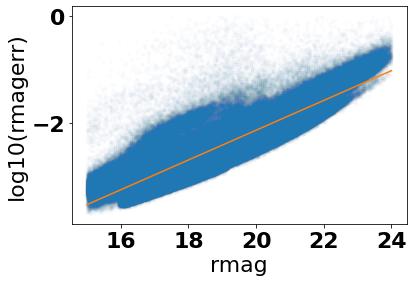

In [12]:
#error in the r mag
xdata = testiron['rmag']
ydata = np.log10(testiron['rmagerr'])
def betw(x,x1,x2): return (x>x1)&(x<x2)
xnew = xdata[betw(xdata, 15,24)&betw(ydata,-4,0)]
ynew = ydata[betw(xdata, 15,24)&betw(ydata,-4,0)]
#plotting stream regions
plt.plot(xnew, ynew,'.',alpha=0.01)

def log10_error_func(x, a, b):
    return a * x + b

from scipy.optimize import curve_fit
popt, pcov = curve_fit(log10_error_func, xnew, ynew)

xdata = np.linspace(15,24,100)
plt.plot(xdata, log10_error_func(xdata, *popt))
plt.xlabel('rmag')
plt.ylabel('log10(rmagerr)')

In [13]:
#quality cut, exclude nans and RA/DEC cut
iqk,=np.where((testiron['TARGET_RA_1'] > 257) & (testiron['TARGET_RA_1'] < 263) & (testiron['TARGET_DEC_1'] > 55.9) & (testiron['TARGET_DEC_1'] < 59.9) & (testiron['RVS_WARN']==0) &(testiron['RR_SPECTYPE']!='QSO')&(testiron['VSINI']<50)
             
      &(~np.isnan(testiron["PMRA_ERROR"])) &(~np.isnan(testiron["PMDEC_ERROR"])) &(~np.isnan(testiron["PMRA_PMDEC_CORR"])) &(testiron["FEH"] >-3.8)&(testiron["FEH"] <-0.3) &(testiron["LOGG"] <4))    






In [14]:
#making CMD diagram for the data
ra0 = 260.0517
dec0 =  57.9153
rad0 =1.6

stars = SkyCoord(ra=testiron['TARGET_RA_1'], dec=testiron['TARGET_DEC_1'], unit=u.deg)

# Calculate the angular separation between stars and the reference point
separations = stars.separation(SkyCoord(ra=ra0, dec=dec0, unit=u.deg))

testiron['dist1'] = separations


In [15]:
ind = (testiron['dist1'][iqk] <0.3)
dm=19.53


In [16]:
#making cut for the horizontal branch
dm_m92_harris = 14.59
m92ebv = 0.023
m92ag = m92ebv * 3.184
m92ar = m92ebv * 2.130
m92_hb_r = np.array([20.5, 20.8, 20.38, 20.2, 19.9, 19.8])
m92_hb_col = np.array([-0.25, -0.15, -0., 0.15, 0.25,0.33])
m92_hb_g = m92_hb_r + m92_hb_col
des_m92_hb_g = m92_hb_g - 0.104 * (m92_hb_g - m92_hb_r) + 0.01
des_m92_hb_r = m92_hb_r - 0.102 * (m92_hb_g - m92_hb_r) + 0.02
des_m92_hb_g = des_m92_hb_g- dm_m92_harris
des_m92_hb_r = des_m92_hb_r  - dm_m92_harris

In [17]:
dm_m92_harris = 14.59
m92ebv = 0.023
m92ag = m92ebv * 3.184
m92ar = m92ebv * 2.130
m92_hb_r = np.array([17.3, 15.8, 15.38, 15.1, 15.05, 15.0,14.95,14.9])
m92_hb_col = np.array([-0.39, -0.3, -0.2, -0.0, 0.1,0.2,0.3,0.4])
m92_hb_g = m92_hb_r + m92_hb_col
des_m92_hb_g = m92_hb_g - 0.104 * (m92_hb_g - m92_hb_r) + 0.01
des_m92_hb_r = m92_hb_r - 0.102 * (m92_hb_g - m92_hb_r) + 0.02
des_m92_hb_g = des_m92_hb_g - m92ag - dm_m92_harris
des_m92_hb_r = des_m92_hb_r - m92ar - dm_m92_harris

In [18]:
xcut = (((iso_file['DECam_g']-iso_file['DECam_r']) < 1.8)& ((iso_file['DECam_g']-iso_file['DECam_r']) > -0.5))

ycut = (((iso_file['DECam_r']+dm) < 21)& ((iso_file['DECam_r']+dm) > 15.5))
fiso = interpolate.interp1d(((iso_file['DECam_g'].values)-(iso_file['DECam_r']).values)[xcut&ycut][-5:-1],((iso_file['DECam_r'].values)+dm)[xcut&ycut][-5:-1],kind='cubic',fill_value='extrapolate')



def extrapolate_poly(x, y, x_new):
    # Perform polynomial regression
    coeffs = np.polyfit(x, y, 1)

    # Extrapolate the polynomial
    y_new = np.polyval(coeffs, x_new)
    return y_new



In [19]:
((iso_file['DECam_g'].values)-(iso_file['DECam_r']).values)[xcut&ycut]

array([0.5079, 0.5103, 0.5127, 0.5152, 0.5178, 0.5202, 0.5229, 0.5258,
       0.5263, 0.5268, 0.5273, 0.5279, 0.5285, 0.529 , 0.5296, 0.5301,
       0.5308, 0.5313, 0.5376, 0.5445, 0.5522, 0.5593, 0.5676, 0.5762,
       0.5838, 0.5919, 0.5998, 0.6078, 0.6163, 0.6246, 0.6331, 0.6406,
       0.6455, 0.6416, 0.6455, 0.6573, 0.6694, 0.6816, 0.6943, 0.7067,
       0.7193, 0.7321, 0.7447, 0.7576, 0.7712, 0.7852, 0.7996, 0.8141,
       0.8291, 0.8443, 0.8596, 0.8752, 0.8906, 0.9066, 0.9224, 0.9386,
       0.9553, 0.9725, 0.9898, 1.0071, 1.0241, 1.041 , 1.0579, 1.0745,
       1.0911, 1.1075, 1.1237, 1.1399, 1.1559, 1.1714])

In [20]:
isox = np.arange(1.18,1.5,0.1)

In [21]:
fiso=extrapolate_poly(((iso_file['DECam_g'].values)-(iso_file['DECam_r']).values)[xcut&ycut][-5:-1],((iso_file['DECam_r'].values)+dm)[xcut&ycut][-5:-1], isox)




In [22]:
fiso

array([16.39664694, 16.10803956, 15.81943218, 15.5308248 ])

In [23]:
# making actual selections/cuts -- CMD cut and color-color cut

# CMD cut for RGB

def cmd_selection(t, dm, dotter_g, dotter_r, gw=0.5):
    '''
    function for making the CMD cut 
    :param t datafile: data input
    :param dm float: distance modulus 
    :param dotter_g: isochrone g mag
    :param dotter_r: isochrone r mag
    :param gw: width in the CMD selection
    :return: color cut index 
    '''
    grw = np.sqrt(0.1**2 + (3*10**log10_error_func(dotter_r+dm, *popt))**2)
    gw = gw # RGB width in g
    rmin = 16
    rmax = 21
    grmin = -0.5
    grmax = 1.3
    magrange = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax) & (t['gmag0'] - t['rmag0'] > grmin)
    gr = t['gmag0'] - t['rmag0']
    grmax1 = np.interp(t['rmag0'], dotter_r[::-1] + dm, dotter_g[::-1] - dotter_r[::-1]+grw[::-1], left=np.nan, right=np.nan)
    grmax2 = np.interp(t['rmag0'], dotter_r[::-1] + dm + gw, dotter_g[::-1] - dotter_r[::-1]+grw[::-1], left=np.nan, right=np.nan)
    grmax3 = np.interp(t['rmag0'], dotter_r[::-1] + dm - gw, dotter_g[::-1] - dotter_r[::-1]+grw[::-1], left=np.nan, right=np.nan)
    grmax = np.max(np.array([grmax1, grmax2, grmax3]), axis=0)
    grmin1 = np.interp(t['rmag0'], dotter_r[::-1] + dm, dotter_g[::-1] - dotter_r[::-1]-grw[::-1], left=np.nan, right=np.nan)
    grmin2 = np.interp(t['rmag0'], dotter_r[::-1] + dm - gw, dotter_g[::-1] - dotter_r[::-1]-grw[::-1], left=np.nan, right=np.nan)
    grmin3 = np.interp(t['rmag0'], dotter_r[::-1] + dm + gw, dotter_g[::-1] - dotter_r[::-1]-grw[::-1], left=np.nan, right=np.nan)
    grmin = np.min(np.array([grmin1, grmin2, grmin3]), axis=0)
    colorsel = (gr < grmax) & (gr > grmin)
    colorrange = magrange & colorsel

    # CMD cut for BHB
    grw_bhb = 0.5 # BHB width in gr
    gw_bhb = 0.5  # BHB width in g
    grmin_bhb = -0.45
    grmax_bhb = 0.4
    magrange_bhb = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax_bhb) & (t['gmag0'] - t['rmag0'] > grmin_bhb)

    gr_bhb = np.interp(t['rmag0'], des_m92_hb_r[::-1] + dm , des_m92_hb_g[::-1] - des_m92_hb_r[::-1], left=np.nan, right=np.nan)
    rr_bhb = np.interp(t['gmag0'] - t['rmag0'], des_m92_hb_g - des_m92_hb_r, des_m92_hb_r + dm,left=np.nan, right=np.nan)
    del_color_cmd_bhb = t['gmag0'] - t['rmag0'] - gr_bhb
    del_g_cmd_bhb = t['rmag0'] - rr_bhb
    colorrange_bhb = magrange_bhb & ((abs(del_color_cmd_bhb) < grw_bhb) | (abs(del_g_cmd_bhb) < gw_bhb))

    colorrange = colorrange | colorrange_bhb
    
    return colorrange




In [24]:
def cmd_selection(t, dm, g_r, iso_r, cwmin=0.1, dobhb=True):
    # width in g-r
    grw = np.sqrt(0.1**2 + (3*10**log10_error_func(iso_r+dm, *popt))**2)

    gw = 0.3# min width (size) in r 
    # color selection box, in case we want something different from the mag cuts made earlier
    rmin = 16
    rmax = 23
    grmin = -0.5
    grmax = 1.5
    magrange = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax) & (t['gmag0'] - t['rmag0'] > grmin)
    gr = t['gmag0'] - t['rmag0']
    grmax1 = np.interp(t['rmag0'], iso_r[::-1] + dm, g_r[::-1]+grw[::-1], left=np.nan, right=np.nan)
    grmax2 = np.interp(t['rmag0'], iso_r[::-1] + dm + gw, g_r[::-1]+grw[::-1], left=np.nan, right=np.nan)
    grmax3 = np.interp(t['rmag0'], iso_r[::-1] + dm - gw, g_r[::-1]+grw[::-1], left=np.nan, right=np.nan)
    grmax = np.max(np.array([grmax1, grmax2, grmax3]), axis=0)
    grmin1 = np.interp(t['rmag0'], iso_r[::-1] + dm, g_r[::-1]-grw[::-1], left=np.nan, right=np.nan)
    grmin2 = np.interp(t['rmag0'], iso_r[::-1] + dm - gw, g_r[::-1]-grw[::-1], left=np.nan, right=np.nan)
    grmin3 = np.interp(t['rmag0'], iso_r[::-1] + dm + gw, g_r[::-1]-grw[::-1], left=np.nan, right=np.nan)
    grmin = np.min(np.array([grmin1, grmin2, grmin3]), axis=0)
    ismall,=np.where(grmax-grmin < cwmin)
    grmin[ismall] = np.interp(t['rmag0'][ismall],iso_r[::-1] + dm, g_r[::-1]-cwmin/2, left=np.nan, right=np.nan)
    grmax[ismall] = np.interp(t['rmag0'][ismall],iso_r[::-1] + dm, g_r[::-1]+cwmin/2, left=np.nan, right=np.nan)
    colorsel = (gr < grmax) & (gr > grmin)
    colorrange = magrange & colorsel

    
    if dobhb:
        grw_bhb = 1.0 # BHB width in gr
        gw_bhb = 1.0 # BHB width in g
        grmin_bhb = -0.6
        grmax_bhb = 0.6
        magrange_bhb = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax_bhb) & (t['gmag0'] - t['rmag0'] > grmin_bhb)

        gr_bhb = np.interp(t['rmag0'], des_m92_hb_r[::-1] + dm , des_m92_hb_g[::-1] - des_m92_hb_r[::-1], left=np.nan, right=np.nan)
        rr_bhb = np.interp(t['gmag0'] - t['rmag0'], des_m92_hb_g - des_m92_hb_r, des_m92_hb_r + dm,left=np.nan, right=np.nan)
        del_color_cmd_bhb = t['gmag0'] - t['rmag0'] - gr_bhb
        del_g_cmd_bhb = t['rmag0'] - rr_bhb
        colorrange_bhb = magrange_bhb & ((abs(del_color_cmd_bhb) < grw_bhb) | (abs(del_g_cmd_bhb) < gw_bhb))
        colorrange = colorrange | colorrange_bhb

    return  colorrange


In [25]:
iso_r = np.append(iso_file['DECam_r'].values[xcut&ycut],fiso-dm)
g_r = np.append(((iso_file['DECam_g'].values)-(iso_file['DECam_r']).values)[xcut&ycut],isox)

In [26]:
colorcut = cmd_selection(testiron[iqk], dm, g_r,iso_r, cwmin=0.78, dobhb=True)


/tmp/ipykernel_336306/1227359104.py:11: RuntimeWarning: invalid value encountered in subtract
  magrange = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax) & (t['gmag0'] - t['rmag0'] > grmin)
/tmp/ipykernel_336306/1227359104.py:12: RuntimeWarning: invalid value encountered in subtract
  gr = t['gmag0'] - t['rmag0']
/tmp/ipykernel_336306/1227359104.py:33: RuntimeWarning: invalid value encountered in subtract
  magrange_bhb = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax_bhb) & (t['gmag0'] - t['rmag0'] > grmin_bhb)
/tmp/ipykernel_336306/1227359104.py:36: RuntimeWarning: invalid value encountered in subtract
  rr_bhb = np.interp(t['gmag0'] - t['rmag0'], des_m92_hb_g - des_m92_hb_r, des_m92_hb_r + dm,left=np.nan, right=np.nan)
/tmp/ipykernel_336306/1227359104.py:37: RuntimeWarning: invalid value encountered in subtract
  del_color_cmd_bhb = t['gmag0'] - t['rmag0'] - gr_bhb


In [27]:
len(testiron['gmag0'][iqk][colorcut])

499

Text(0.5, 0, 'gmag0-rmag0')

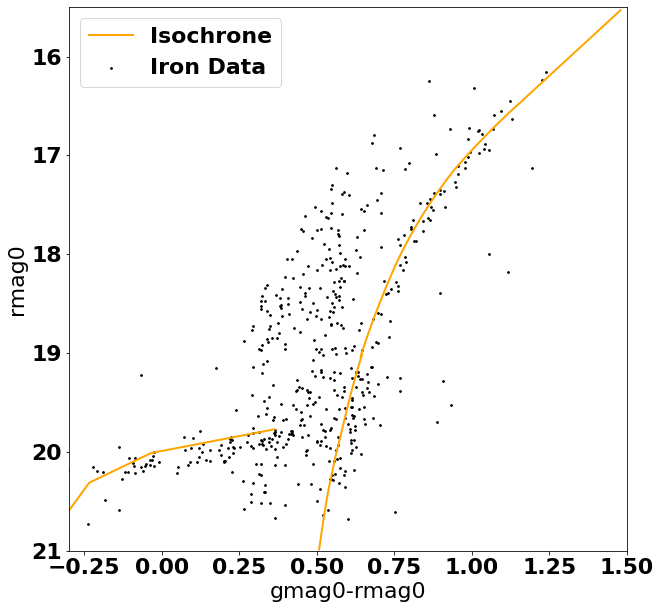

In [28]:
#colorcut for the sample 
#Investigating the data sample after colorcut 


plt.figure(figsize=(10,10))
plt.plot(g_r,iso_r+dm,c='orange',lw=2,label = 'Isochrone')
#plt.scatter(testiron['gmag0'][iqk]-testiron['rmag0'][iqk],testiron['rmag0'][iqk],s=1,c='k',alpha=1,label ='Iron Data',cmap='bwr')
#plt.colorbar()
plt.scatter(testiron['gmag0'][iqk][colorcut]-testiron['rmag0'][iqk][colorcut],testiron['rmag0'][iqk][colorcut],s=3,c='k',alpha=1,label ='Iron Data',cmap='bwr')
#plt.colorbar()
grw = np.sqrt(0.1**2 + (3*10**log10_error_func(iso_file['DECam_r']+dm, *popt))**2)



#plt.plot(iso_file['DECam_g']-iso_file['DECam_r']+grw, iso_file['DECam_r']+dm,'--r')
#plt.plot(iso_file['DECam_g']-iso_file['DECam_r']-grw, iso_file['DECam_r']+dm,'--r')
#plt.plot(iso_file['DECam_g']-iso_file['DECam_r']+grw, iso_file['DECam_r']+dm+0.3,'--k',label='Colorcut Region')
#plt.plot(iso_file['DECam_g']-iso_file['DECam_r']-grw, iso_file['DECam_r']+dm-0.3,'--k')
#plt.plot(iso_file['DECam_g']-iso_file['DECam_r']+grw, iso_file['DECam_r']+dm-1,'--k')
#plt.plot(iso_file['DECam_g']-iso_file['DECam_r']-grw, iso_file['DECam_r']+dm+1,'--k')

plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm, lw=2, color='orange')
#plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm-0.4,'--k')
#plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm+0.4,'--k')
#plt.plot(des_m92_hb_g-des_m92_hb_r-0.1, des_m92_hb_r+dm,'--r')
#plt.plot(des_m92_hb_g-des_m92_hb_r+0.1, des_m92_hb_r+dm,'--r')
plt.legend(loc=2)
plt.ylim(21, 15.5)
plt.xlim(-0.3,1.5)
plt.ylabel('rmag0')
plt.xlabel('gmag0-rmag0')


/tmp/ipykernel_336306/2728129723.py:1: RuntimeWarning: invalid value encountered in subtract
  plt.scatter(testiron['gmag0'][iqk]-testiron['rmag0'][iqk],testiron['rmag0'][iqk],s=3)


Text(0.5, 0, 'gmag0-rmag0')

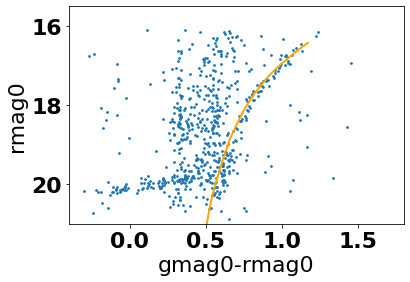

In [29]:
plt.scatter(testiron['gmag0'][iqk]-testiron['rmag0'][iqk],testiron['rmag0'][iqk],s=3)
plt.plot(iso_file['DECam_g']-iso_file['DECam_r'],iso_file['DECam_r']+dm,c='orange',lw=2)

plt.ylim(21, 15.5)
plt.xlim(-0.4,1.8)
plt.ylabel('rmag0')
plt.xlabel('gmag0-rmag0')

/tmp/ipykernel_336306/3926325756.py:3: RuntimeWarning: invalid value encountered in subtract
  plt.scatter(testiron['gmag0'][iqk]-testiron['rmag0'][iqk],testiron['rmag0'][iqk],s=1,c='k',alpha=1,label ='Iron Data',cmap='bwr')


Text(0.5, 0, 'gmag0-rmag0')

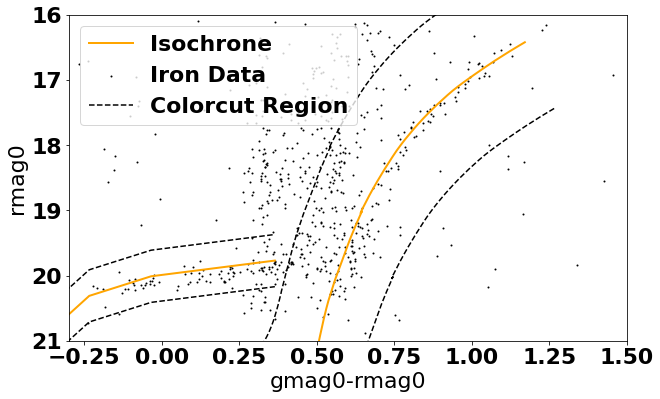

In [30]:
plt.figure(figsize=(10,6))
plt.plot(iso_file['DECam_g']-iso_file['DECam_r'],iso_file['DECam_r']+dm,c='orange',lw=2,label = 'Isochrone')
plt.scatter(testiron['gmag0'][iqk]-testiron['rmag0'][iqk],testiron['rmag0'][iqk],s=1,c='k',alpha=1,label ='Iron Data',cmap='bwr')
#plt.colorbar()
grw = np.sqrt(0.1**2 + (3*10**log10_error_func(iso_file['DECam_r']+dm, *popt))**2)



#plt.plot(iso_file['DECam_g']-iso_file['DECam_r']+grw, iso_file['DECam_r']+dm,'--r')
#plt.plot(iso_file['DECam_g']-iso_file['DECam_r']-grw, iso_file['DECam_r']+dm,'--r')
plt.plot(iso_file['DECam_g']-iso_file['DECam_r']+grw, iso_file['DECam_r']+dm+1,'--k',label='Colorcut Region')
plt.plot(iso_file['DECam_g']-iso_file['DECam_r']-grw, iso_file['DECam_r']+dm-1,'--k')
#plt.plot(iso_file['DECam_g']-iso_file['DECam_r']+grw, iso_file['DECam_r']+dm-1,'--k')
#plt.plot(iso_file['DECam_g']-iso_file['DECam_r']-grw, iso_file['DECam_r']+dm+1,'--k')

plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm, lw=2, color='orange')
plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm-0.4,'--k')
plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm+0.4,'--k')
#plt.plot(des_m92_hb_g-des_m92_hb_r-0.1, des_m92_hb_r+dm,'--r')
#plt.plot(des_m92_hb_g-des_m92_hb_r+0.1, des_m92_hb_r+dm,'--r')
plt.legend(loc=2)
plt.ylim(21, 16)
plt.xlim(-0.3,1.5)
plt.ylabel('rmag0')
plt.xlabel('gmag0-rmag0')

# Input data profile (FeH, radial velocity, pmra, pmdec)

In [31]:
print (len(testiron["VRAD"][iqk]))

655


In [32]:
#radial velocity 
up = -150
low = -500
vtest = testiron["VRAD"][iqk][colorcut]
vcut  = (vtest > low) & (vtest  < up)
rv = testiron["VRAD"][iqk][colorcut][vcut]
rverr = testiron["VRAD_ERR"][iqk][colorcut][vcut]
# metallicity
feh = testiron["FEH"][iqk][colorcut][vcut]
feherr = testiron["FEH_ERR"][iqk][colorcut][vcut]
# proper motions
pmra = testiron["PMRA_3"][iqk][colorcut][vcut]
pmraerr = testiron["PMRA_ERROR"][iqk][colorcut][vcut]
pmdec = testiron["PMDEC_3"][iqk][colorcut][vcut]
pmdecerr = testiron["PMDEC_ERROR"][iqk][colorcut][vcut]


Text(0, 0.5, 'LOGG')

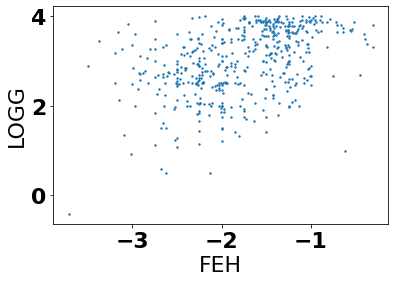

In [33]:
plt.scatter(testiron["FEH"][iqk][colorcut],testiron["LOGG"][iqk][colorcut],s=2)
plt.xlabel('FEH')
plt.ylabel('LOGG')

(array([190., 124.,  47.,  17.,  12.,   6.,   4.,   2.,   1.,   1.]),
 array([0.00115682, 0.04528904, 0.08942127, 0.1335535 , 0.17768573,
        0.22181795, 0.26595018, 0.31008241, 0.35421464, 0.39834686,
        0.44247909]),
 <BarContainer object of 10 artists>)

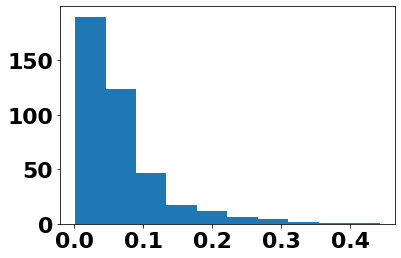

In [34]:
plt.hist(feherr)

Text(0.5, 0, 'pmdec')

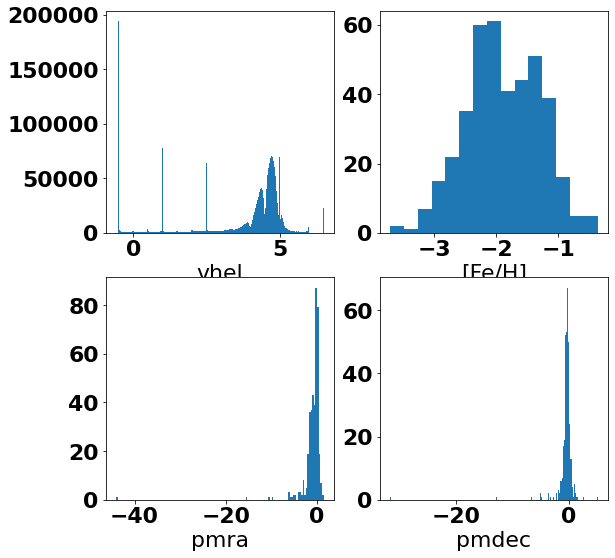

In [35]:
#vrad,feh,pm distribution

fig, axes = plt.subplots(2,2,figsize=(9,9))
axes[0,0].hist(testiron["LOGG"], bins='auto');
axes[0,0].set_xlabel("vhel")
axes[0,1].hist(feh, bins='auto');
axes[0,1].set_xlabel("[Fe/H]")
axes[1,0].hist(pmra, bins='auto');
axes[1,0].set_xlabel("pmra")
axes[1,1].hist(pmdec, bins='auto');
axes[1,1].set_xlabel("pmdec")

In the given code, pmnorm is defined as 1/(np.pi * pmmax**2), where pmmax is the magnitude of the maximum proper motion vector. This expression is used to normalize the proper motion likelihood function for the entire data set.

In more detail, the proper motion likelihood function represents the probability of observing a particular proper motion vector for a star, given its position on the sky and any other relevant information. In this code, a uniform background distribution is assumed, which means that the likelihood of observing any particular proper motion vector is assumed to be constant across the entire sky.

To normalize the proper motion likelihood function, the maximum value of the proper motion vector magnitude is computed (pmmax), and the inverse of the product of pi and the square of pmmax is taken (1/(np.pi * pmmax**2)). This value (pmnorm) is then used to scale the proper motion likelihood function so that its integral over the entire sky is equal to one. This ensures that the probability of observing any proper motion vector is properly normalized, given the assumptions made in the analysis.

We will model the smcnod data as a mixture of 2 gaussians. The parameters will be:

* pgal = fraction of stars in the galaxy
* pmra = Heliocentric proper motion, RA of the galaxy in mas/yr
* pmdec = Heliocentric proper motion, Dec of the galaxy in mas/yr
* vhel = mean velocity of the galaxy in km/s
* lsigv = log10 the velocity dispersion of the galaxy in km/s
* feh = mean metallicity of the galaxy in dex
* lsigfeh = log10 the metallicity dispersion of the galaxy in dex
* vbg1, lsigvbg1, fehbg1, lsigfeh1 = same parameters for 1st background component

In [36]:
def data_collect(datafile,ramin,ramax,decmin,decmax,fehmin,fehmax,vmin,vmax,logg,galdis,dm,cwmin,g_r,iso_r):
    '''
    function for collecting all the data input for the likelihood (you can change ra,dec,feh,colorcut range in the above notebook in this function)
    :param datafile: data table
    :param ramin,ramax float: ra range
    :param decmin,decmax float: dec range
    :param fehmin,fehmax float: metallicity range
    :param vmin,vmax: radial velocity range 
    :param galdis: gal proper motion dispersion 
    :param iso_file: isochrone file
    :param dm: distance modulus
    :param gw: width for the colorcut
    :return: rv,rverr,feh,feherr and the proper motion data
    Note that a constant (0.025) term is added to the diagonal terms of the covariance for the proper motion data 
    to account for the gal dispersion  
    '''
    
    #ra,dec, feh and quality cut
    iqk,=np.where((datafile['TARGET_RA_1'] > ramin) & (datafile['TARGET_RA_1'] < ramax) & (datafile['TARGET_DEC_1'] > decmin) & (datafile['TARGET_DEC_1'] < decmax) & (datafile['RVS_WARN']==0) &(datafile['RR_SPECTYPE']!='QSO')&(datafile['VSINI']<50)
             
      &(~np.isnan(datafile["PMRA_ERROR"])) &(~np.isnan(datafile["PMDEC_ERROR"])) &(~np.isnan(datafile["PMRA_PMDEC_CORR"])) &(datafile["FEH"] >fehmin)&(datafile["FEH"] <fehmax) &(datafile["LOGG"] <logg) )
    
    colorcut = cmd_selection(testiron[iqk], dm, g_r, iso_r, cwmin=cwmin, dobhb=True)
    up = vmin
    low = vmax
    
    vtest = datafile["VGSR"][iqk][colorcut]
    vcut  = (vtest > low) & (vtest  < up)
    rv = datafile["VGSR"][iqk][colorcut][vcut]
    rverr = datafile["VRAD_ERR"][iqk][colorcut][vcut]
# metallicity
    feh = datafile["FEH"][iqk][colorcut][vcut]
    feherr = datafile["FEH_ERR"][iqk][colorcut][vcut]
# proper motions
    pmra = datafile["PMRA_3"][iqk][colorcut][vcut]
    pmraerr = datafile["PMRA_ERROR"][iqk][colorcut][vcut]
    pmdec = datafile["PMDEC_3"][iqk][colorcut][vcut]
    pmdecerr = datafile["PMDEC_ERROR"][iqk][colorcut][vcut]
    
    N = len(rv)
    datacut = datafile[iqk][colorcut][vcut]
# Create 2-D arrays for proper motion
    pms = np.zeros((N,2)) 
    pms[:,0] = testiron["PMRA_3"][iqk][colorcut][vcut]
    pms[:,1] = testiron["PMDEC_3"][iqk][colorcut][vcut]

# pms array is computed and assigned to the variable pmmax. 
# This is essentially finding the magnitude of the maximum proper motion vector.
    pmmax = np.max(np.sqrt(np.sum(pms**2, axis=1)))
# normalize the proper motion likelihood function for the entire data set
    pmnorm = 1/(np.pi * pmmax**2)
# Covariance Matrix for gal
    pmcovs = np.zeros((N,2,2))
    
    pmcovs[:,0,0] = testiron["PMRA_ERROR"][iqk][colorcut][vcut]**2+galdis**2
    pmcovs[:,1,1] = testiron["PMDEC_ERROR"][iqk][colorcut][vcut]**2+galdis**2
    pmcovs[:,0,1] = testiron["PMRA_ERROR"][iqk][colorcut][vcut]*testiron["PMDEC_ERROR"][iqk][colorcut][vcut]*testiron["PMRA_PMDEC_CORR"][iqk][colorcut][vcut]
    pmcovs[:,1,0] = testiron["PMRA_ERROR"][iqk][colorcut][vcut]*testiron["PMDEC_ERROR"][iqk][colorcut][vcut]*testiron["PMRA_PMDEC_CORR"][iqk][colorcut][vcut]


    return [rv,rverr,feh,feherr,pms,pmcovs],datacut,pmnorm


    


    

In [37]:
#try 257/263 253/267

datasum,datacut,pmnorm =data_collect(testiron,253,267,55.9,59.9,-3.2,-0.5,50,-250,4,0.025,dm,0.75,g_r=g_r,iso_r=iso_r)




/tmp/ipykernel_336306/1227359104.py:11: RuntimeWarning: invalid value encountered in subtract
  magrange = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax) & (t['gmag0'] - t['rmag0'] > grmin)
/tmp/ipykernel_336306/1227359104.py:12: RuntimeWarning: invalid value encountered in subtract
  gr = t['gmag0'] - t['rmag0']
/tmp/ipykernel_336306/1227359104.py:33: RuntimeWarning: invalid value encountered in subtract
  magrange_bhb = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax_bhb) & (t['gmag0'] - t['rmag0'] > grmin_bhb)
/tmp/ipykernel_336306/1227359104.py:36: RuntimeWarning: invalid value encountered in subtract
  rr_bhb = np.interp(t['gmag0'] - t['rmag0'], des_m92_hb_g - des_m92_hb_r, des_m92_hb_r + dm,left=np.nan, right=np.nan)
/tmp/ipykernel_336306/1227359104.py:37: RuntimeWarning: invalid value encountered in subtract
  del_color_cmd_bhb = t['gmag0'] - t['rmag0'] - gr_bhb


In [38]:
pmnorm

0.0001079476356839067

In [39]:
np.min(datacut['rmag0']),np.max(datacut['rmag0'])

(16.156998, 20.723923)

Text(0.5, 0, 'gmag0-rmag0')

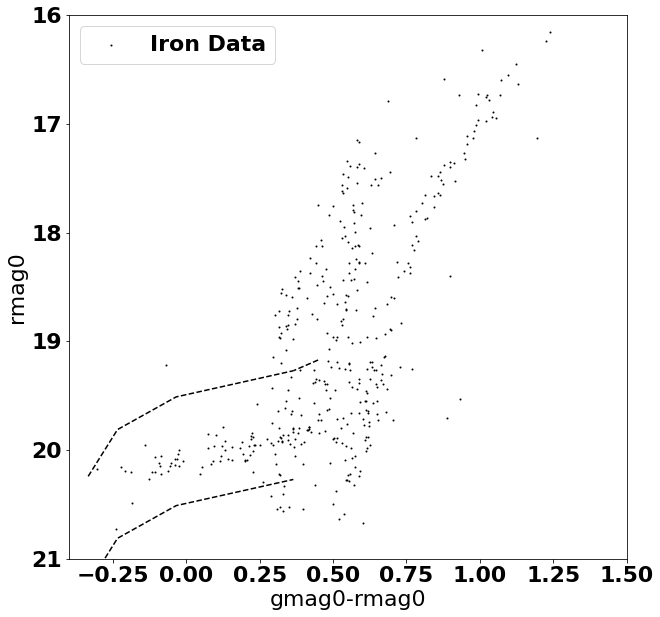

In [40]:
plt.figure(figsize=(10,10))
#plt.plot(iso_file['DECam_g']-iso_file['DECam_r'],iso_file['DECam_r']+dm,c='orange',lw=2,label = 'Isochrone')
plt.scatter(datacut['gmag0']-datacut['rmag0'],datacut['rmag0'],s=1,c='k',alpha=1,label ='Iron Data',cmap='bwr')
#plt.colorbar()
grw = np.sqrt(0.1**2 + (3*10**log10_error_func(iso_file['DECam_r']+dm, *popt))**2)

iso1= np.array(iso_file['DECam_r']+dm+0.75)
iso2= np.array(iso_file['DECam_r']+dm-1.0)
colordiff = np.array(datacut['gmag0']-datacut['rmag0'])
#plt.plot(iso_file['DECam_g']-iso_file['DECam_r']+grw, iso_file['DECam_r']+dm,'--r')
#plt.plot(iso_file['DECam_g']-iso_file['DECam_r']-grw, iso_file['DECam_r']+dm,'--r')
cut1= ((iso2>np.min(datacut['rmag0']))&(iso2<np.min(des_m92_hb_r+dm-0.5)))
cut3 = ((iso2<np.max(datacut['rmag0']))&(iso2>np.min(des_m92_hb_r+dm+0.5)))
cut2= (iso1>np.min(datacut['rmag0']))&(iso1<np.max(datacut['rmag0']))
#cut4 = ((iso2<np.max(datacut['rmag0']))&(iso2>np.min(des_m92_hb_r+dm+0.5)))
#plt.plot((iso_file['DECam_g']-iso_file['DECam_r']+grw)[cut2], iso1[cut2],'--k',label='Colorcut Region')
#plt.plot((iso_file['DECam_g']-iso_file['DECam_r']+grw)[cut3], iso1[cut3],'--k',label='Colorcut Region')
#plt.plot((iso_file['DECam_g']-iso_file['DECam_r']-grw)[cut1], iso2[cut1] ,'--k')
#plt.plot((iso_file['DECam_g']-iso_file['DECam_r']-grw)[cut3], iso2[cut3] ,'--k')
#plt.plot(iso_file['DECam_g']-iso_file['DECam_r']+grw, iso_cut1
#plt.plot(iso_file['DECam_g']-iso_file['DECam_r']-grw, iso_file['DECam_r']+dm+1,'--k')
#plt.plot([np.min((iso_file['DECam_g']-iso_file['DECam_r']-grw)[cut3]),np.min((iso_file['DECam_g']-iso_file['DECam_r']+grw)[cut2])],[np.max(datacut['rmag0']),np.max(datacut['rmag0'])],'--',c='k')
#plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm, lw=2, color='orange')
plt.plot(np.max(des_m92_hb_g-des_m92_hb_r),np.min(des_m92_hb_r+dm-0.5))
plt.plot((des_m92_hb_g-des_m92_hb_r)[des_m92_hb_g-des_m92_hb_r>-0.4], (des_m92_hb_r+dm-0.5)[des_m92_hb_g-des_m92_hb_r>-0.4],'--k')
plt.plot((des_m92_hb_g-des_m92_hb_r)[des_m92_hb_g-des_m92_hb_r>-0.4], (des_m92_hb_r+dm+0.5)[des_m92_hb_g-des_m92_hb_r>-0.4],'--k')
plt.plot([np.min((iso_file['DECam_g']-iso_file['DECam_r']-grw)[cut1]),np.max(des_m92_hb_g-des_m92_hb_r)],[np.max(iso2[cut1]),np.min(des_m92_hb_r+dm-0.5)],'--k')
#plt.a x= 0.3
#hor = 
#plt.axhline(y=np.min(datacut['rmag0']),xmin = 0.63,xmax =0.98,c='k',linestyle='--')
#plt.axvline(x=-0.33,ymin = 0.03,ymax = 0.25,c='k',linestyle='--')
#plt.plot(des_m92_hb_g-des_m92_hb_r-0.1, des_m92_hb_r+dm,'--r')
#plt.plot(des_m92_hb_g-des_m92_hb_r+0.1, des_m92_hb_r+dm,'--r')
plt.legend(loc=2)
plt.ylim(21, 16)
plt.xlim(-0.4,1.5)
plt.ylabel('rmag0')
plt.xlabel('gmag0-rmag0')
#plt.savefig('colorcut.pdf')

In [41]:
feherr

<Column name='FEH_ERR' dtype='float64' length=404>
 0.04601315762849361
 0.07884955285546036
0.018954339996158046
0.007361455757309046
0.024192843966714814
 0.05688507885745466
 0.06679052120150557
 0.06746721262394059
 0.06975272668028588
0.012668874236548755
 0.05030897471387144
0.013729568420479165
                 ...
 0.02075082542620461
 0.14585017069974762
   0.111172666921039
0.030475730763172792
 0.07774966422542806
 0.03875450610288898
0.024937940479096435
 0.02420329215255204
  0.0231520819226874
 0.08866378170231948
  0.0873618759773655
 0.06755168389693929

In [42]:
def two_gnfunc(dataarr, gnvals,params):
    '''
    function for model of the two gaussians
    :param dataarr: data array 
    :param params: parameter for the two gaussian distributions (center (center for gaussian narrow gaussian)
    sigma (sigma for gaussian narrow gaussian), center2 = (center2 for gaussian narrow gaussian),sigma2 = (sigma2 for gaussian narrow gaussian) 
    amp1 (fraction of area under narrow gaussian/area under broad gaussian)) 
    :return: normalizied two gaussian function
    '''
    
    center = params[0]
    sigma = params[1]
    center2 = params[2]
    sigma2 = params[3]
    Amp1 = params[4]
    
    #print(center, sigma, center2, sigma2, Amp1)
    
    gnvals = Amp1 * np.exp(-(dataarr-center)**2/(2*sigma*sigma))/sigma/np.sqrt(2*np.pi)\
            + (1-Amp1) * np.exp(-(dataarr-center2)**2/(2*sigma2*sigma2))/sigma2/np.sqrt(2*np.pi)
    return gnvals

In [43]:
def twogau_like( xvals,gnvals,params):
    #likelihood used in fitting (normalizied)
    modelvals = two_gnfunc(xvals, gnvals,params)
   
    mlikelihood = - np.sum(np.log(modelvals)) 
    
    #print(mlikelihood)
    return (mlikelihood)



def fitting_reunbin(x,y):

   

    #guess6= [x_0, fwhm,c2,w2, h2] bounds=[(-10,10),(0,10),(-10,10),(0,10),(1e-5,1-1e-5)]
   
   # global xdata,ydata
   # xdata=x
    #ydata=y
    #LL = -np.sum(stats.norm.logpdf(ydata, loc=yPred, scale=sd) )
    #print (x)
    #bds1=((-100,100),(0,100),(-100,100),(100,1000),(1e-5,1-1e-5))
    #optim = minimize(twogau_like, guess6,args=(x),method = 'TNC',bounds=bds1,  options={'maxfun':100000,'disp':True})
    res2 = optim.minimize(twogau_like,[0,1,0,2,0.3],args=(x,y),method = 'SLSQP',
                    bounds=[(-0.1,0.1),(0,0.3),(-0.1,0.1),(0.5,5),(1e-5,1-1e-5)],
                    options={'maxfun':100000,'disp':True})
    #np.sum(((y-two_gaussians(x, *optim1))**2)/(poisson.std(50,loc=0)**2))/(bins-len(guess6))
    
    #chisq1 = chisquare(y,two_gaussians(x, *optim1))[0]
    
    
 
    #if plot == True:
  #  plt.scatter(x,y, c='pink', label='measurement', marker='.', edgecolors=None)
  #  plt.plot(x, ypred, c='b', label='fit of Two Gaussians')
   # plt.title("Two Gaussian Fitting")
   # plt.ylabel("Number of pairs")
   # plt.xlabel("Velocity Difference")
   # plt.legend(loc='upper left')
    #plt.savefig('./halo02_results/halo02_2_2fit'+str(k)+'12grav2.5largebin.png')
    #plt.show()
        #plt.scatter(x,y, c='pink', label='measurement', marker='.', edgecolors=None)
       # plt.plot(x, (gaussian(x, p2[0], p2[1], p2[2], p2[3])), c='b', label='fit of 1 Gaussians')
        #plt.title("One gaussian fitting")
       # plt.xlabel("Velocity Difference")
        #plt.legend(loc='upper left')
        #plt.savefig('./halo02_results/halo02_2_1fit'+str(k)+'12grav2.5largebin.png')
        #plt.show()
    
    #return 
    #np.sum(np.absolute((one_gaussian(x, *optim2) - y)**2/one_gaussian(x, *optim2)))
    #if np.absolute(aic1)-np.absolute(aic2) < 0:
        #return LL1,p1
    #else:
        #return LL2,p2
         
    #if np.absolute(chisq1) < np.absolute(chisq2):
        
        #interen = integrate.quad(lambda x: Lorentz1D_mo_ra(x, *optim1), -np.absolute((optim1[2]/2*3))+optim1[1],np.absolute(optim1[2]/2*3)+optim1[1])[0]
        #intereb = simps(y, dx=np.absolute(x[0]-x[1]))
        

        
    return res2.x


In [44]:
dfm = pd.read_csv('metallicity_dist.csv')


In [45]:
dfm.keys()

Index(['x', '  y'], dtype='object')

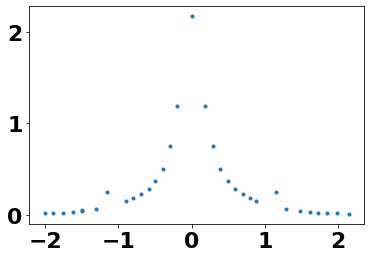

In [46]:
plt.plot(dfm['x'],dfm['  y'],'.')

In [47]:
popt, pcov = curve_fit(two_gnfunc, dfm['x'],dfm['  y'],p0=[0,0,1,2,0.8])

TypeError: two_gnfunc() takes 3 positional arguments but 6 were given

In [48]:
popt

array([ 0.27800583, -7.69268389])

In [49]:
parag = fitting_reunbin(dfm['x'],dfm['  y'])

Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.865424184476687
            Iterations: 5
            Function evaluations: 30
            Gradient evaluations: 5


/tmp/ipykernel_53936/4145482305.py:25: OptimizeWarning: Unknown solver options: maxfun
  res2 = optim.minimize(twogau_like,[0,1,0,2,0.3],args=(x,y),method = 'SLSQP',
/home/tingli/.conda/envs/myenv/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [50]:
parag=[0,0.5,0,1.5,0.9]

Text(0, 0.5, 'Number')

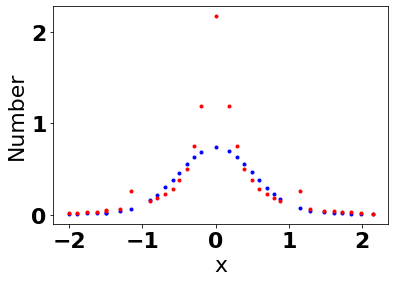

In [51]:
plt.plot(dfm['x'],two_gnfunc(dfm['x'],dfm['  y'],parag),'.',c='b')
plt.plot(dfm['x'],dfm['  y'],'.',c='r')
plt.xlabel('x')
plt.ylabel('Number')

In [52]:
def log_prior(x,loc,scale):
        return stats.norm.logpdf(x, loc=loc, scale=scale)

# Likelihood function

In [53]:
param_labels = ["pgal",
                "vhel","lsigv","feh","lsigfeh",
                "vbg1","lsigvbg1","fehbg1","lsigfeh1",
                "pmra","pmdec",
                "pmra1","pmdec1","lsigpmra1","lsigpmdec1"]
def full_like(theta):
    
    """ Likelihood and Prior """

    '''
    function for calculating the likelihood function 
    :param theta: parameters in the likelihood function 
    :return: final log likelihood
    Note that a constant (0.025) term is added to the diagonal terms of the covariance for the proper motion data 
    to account for the gal dispersion, so for the background pm dispersion, we need to first subtract the constant term,
    then add the parameter lsigpmra1 and lsigpmdec1 to the diagonal term for the background pm likelihood. 
    '''
    
    pgal, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    pmra_gal, pmdec_gal, pmra1, pmdec1, lsigpmra1, lsigpmdec1 = theta
    rv,rverr,feh,feherr,pms,pmcovs=datasum
    
    
    
    
    feherr=np.sqrt(feherr**2+0.15**2)
    #data input 
    galdis=0.025
    N = len(rv)
    pm0s = np.zeros((N,2))
    pm0s[:,0] = pmra_gal
    pm0s[:,1] = pmdec_gal
    
    #pm mean for bg
    bgpm0s = np.zeros((N,2))
    bgpm0s[:,0] = pmra1
    bgpm0s[:,1] = pmdec1
    
    pm0sp = np.zeros((N,2))
    pm0sp[:,0] = -0.04
    pm0sp[:,1] = -0.19
    
    #pm mean for bg
    bgpm0sp = np.zeros((N,2))
    bgpm0sp[:,0] = -2.1
    bgpm0sp[:,1] = -1.1
    
    
    # Covariance Matrix for bg
    bgpmcovs = np.zeros((N,2,2))


    bgpmcovs[:,0,0] = pmcovs[:,0,0]+(10**lsigpmra1)**2-galdis**2
    bgpmcovs[:,1,1] =  pmcovs[:,1,1]+(10**lsigpmdec1)**2-galdis**2
    bgpmcovs[:,0,1] = pmcovs[:,0,1]
    bgpmcovs[:,1,0] = pmcovs[:,1,0]
    
    
    # The prior is just a bunch of hard cutoffs
    if (pgal > 1) or (pgal < 0) or \
        (lsigv > 3) or (lsigvbg1 > 3) or \
        (lsigv < -1) or (lsigvbg1 < -1) or \
        (lsigfeh > 1) or (lsigfeh1 > 1) or (lsigfeh1 > 1) or \
        (lsigfeh < -3) or (lsigfeh1 < -3) or (lsigfeh1 < -3) or \
        (vhel > 600) or (vhel < -600) or (vbg1 > 500) or (vbg1 < -300) or \
        (pmra_gal <-4) or ((pmdec_gal) > 2) or ((pmdec_gal) < -4) or \
        (pmra_gal > 2) or \
        (pmra1 > 2) or (pmra1 < -4) or\
        (pmdec1 > 2) or (pmdec1 < -4) or\
        (lsigpmra1 > 1.3) or (lsigpmra1 < -1) or \
        (lsigpmdec1 > 1.3) or (lsigpmdec1 < -1) :
        return -1e10
    
    # Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))
    
    # Compute log likelihood in feh
    #feh covolved with double gaussian 
    #
    a=0.9
    sigma1=0.5
    sigma2= 1.5
    #lgal_feh = stats.norm.logpdf(feh, loc=feh0, scale=np.sqrt((feherr)**2 + (10**lsigfeh)**2))
    lgal_feh = a*stats.norm.logpdf(feh, loc=feh0, scale=np.sqrt((sigma1)**2 + (10**lsigfeh)**2))+(1-a)*stats.norm.logpdf(feh, loc=feh0, scale=np.sqrt(sigma2**2 + (10**lsigfeh)**2))
    #(1-a)*stats.norm.logpdf(feh, loc=feh0, scale=np.sqrt(sigma2^2**2 + (10**lsigsigma^feh)**2))
    lbg1_feh = a*stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt((sigma1)**2 + (10**lsigfeh1)**2))+(1-a)*stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(sigma2**2 + (10**lsigfeh1)**2))
    #stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt((feherr)**2 + (10**lsigfeh1)**2))
    
    # Compute log likelihood in proper motions
    #for i in range(N):
        
    #using multivariat gaussian for the pm likelihood
    lgal_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm0s[i], cov=pmcovs[i]) for i in range(N)]
    lbg1_pm = [stats.multivariate_normal.logpdf(pms[i], mean=bgpm0s[i], cov=bgpmcovs[i]) for i in range(N)]
    #lbg1_pmdec = stats.norm.logpdf(pmdec, loc=pmdec1, scale=np.sqrt(pmdecerr**2 + (10**lsigpmdec1)**2))
    #lbgpmra = stats.uniform.logpdf( pms[:,0],loc=pmra1, scale =bgpmcovs[:,0,0] )
    #lbgpmdec = stats.uniform.logpdf( pms[:,1], loc=pmdec1, scale =bgpmcovs[:,1,1] )
    # Combine the components
  
    lgal = np.log(pgal)+lgal_vhel+np.array(lgal_pm)+np.log(pmnorm)+lgal_feh
    lbg1 = np.log(1-pgal)+lbg1_vhel+np.log(pmnorm)+lbg1_feh+lbg1_pm
    ltot = np.logaddexp(lgal, lbg1)
    return ltot.sum()

def full_like_indi(theta,ii):
    
    """ Likelihood and Prior """

    '''
    function for calculating the posterior likelihood function for each star 
    :param theta: Best fitted parameters in the likelihood function 
    :param ii float: ith star
    :return: total posterior log likelihood for gal,background,  total posterior log likelihood and individual likelihood 
    for the vrad,pm, and Feh
    
    Note that a constant (0.025) term is added to the diagonal terms of the covariance for the proper motion data 
    to account for the gal dispersion, so for the background pm dispersion, we need to first subtract the constant term,
    then add the parameter lsigpmra1 and lsigpmdec1 to the diagonal term for the background pm likelihood. 
    '''
    
   
    pgal, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    pmra_gal, pmdec_gal, pmra1, pmdec1, lsigpmra1, lsigpmdec1 = theta
    rv,rverr,feh,feherr,pms,pmcovs=datasum
   
    feherr=np.sqrt(feherr**2+0.15**2)
    galdis=0.025
    N = len(rv)
    pm0s = np.zeros((N,2))
    pm0s[:,0] = pmra_gal
    pm0s[:,1] = pmdec_gal
    
    
    #pm mean for bg
    bgpm0s = np.zeros((N,2))
    bgpm0s[:,0] = pmra1
    bgpm0s[:,1] = pmdec1
    
    # Covariance Matrix for bg
    bgpmcovs = np.zeros((N,2,2))


    bgpmcovs[:,0,0] = pmcovs[:,0,0]+(10**lsigpmra1)**2-galdis**2
    bgpmcovs[:,1,1] =  pmcovs[:,1,1]+(10**lsigpmdec1)**2-galdis**2
    bgpmcovs[:,0,1] = pmcovs[:,0,1]
    bgpmcovs[:,1,0] = pmcovs[:,1,0]
    
    
    # The prior is just a bunch of hard cutoffs
    if (pgal > 1) or (pgal < 0) or \
        (lsigv > 3) or (lsigvbg1 > 3) or \
        (lsigv < -1) or (lsigvbg1 < -1) or \
        (lsigfeh > 1) or (lsigfeh1 > 1) or (lsigfeh1 > 1) or \
        (lsigfeh < -3) or (lsigfeh1 < -3) or (lsigfeh1 < -3) or \
        (vhel > 600) or (vhel < -600) or (vbg1 > 500) or (vbg1 < -300) or \
        (abs(pmra_gal) > 2) or (abs(pmdec_gal) > 2) or \
        (abs(pmra1) > 2) or (abs(pmdec1) > 2) or \
        (lsigpmra1 > 1.3) or (lsigpmra1 < -1) or \
        (lsigpmdec1 > 1.3) or (lsigpmdec1 < -1) :
        return -1e10
    
    # Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv[ii], loc=vhel, scale=np.sqrt(rverr[ii]**2 + (10**lsigv)**2))
    lbg1_vhel = stats.norm.logpdf(rv[ii], loc=vbg1, scale=np.sqrt(rverr[ii]**2 + (10**lsigvbg1)**2))
    
    # Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh[ii], loc=feh0, scale=np.sqrt(feherr[ii]**2 + (10**lsigfeh)**2))
    lbg1_feh = stats.norm.logpdf(feh[ii], loc=fehbg1, scale=np.sqrt(feherr[ii]**2 + (10**lsigfeh1)**2))
    
    # Compute log likelihood in proper motions
    #for i in range(N):
        
        #print (pms[i], "mean",pm0s[i], 'cov',pmcovs[i])
    lgal_pm = [stats.multivariate_normal.logpdf(pms[ii], mean=pm0s[ii], cov=pmcovs[ii])]
    lbg1_pm = [stats.multivariate_normal.logpdf(pms[ii], mean=bgpm0s[ii], cov=bgpmcovs[ii])]
    
    # Combine the components
    
    lgal = np.log(pgal)+lgal_vhel+lgal_pm+np.log(pmnorm)+lgal_feh
    lbg1 = np.log(1-pgal)+lbg1_vhel+lbg1_pm+np.log(pmnorm)+lbg1_feh
    
    ltot = np.logaddexp(lgal, lbg1)
    return  lgal,lbg1, ltot,[np.exp(lgal_vhel),np.exp(lgal_pm),np.exp(lgal_feh)]







def get_paramdict(theta):
    return OrderedDict(zip(param_labels, theta))

In [54]:
def project_model(theta, p1min=-600, p1max=350, p2min=-3.9, p2max=0.,key="vhel"):
    """ Turn parameters into p1 and p2 distributions """
    p1arr = np.linspace(p1min, p1max, 1000)
    p2arr = np.linspace(p2min, p2max, 1000)
    p3arr = np.linspace(-4,2,1000)
    params = get_paramdict(theta)
    
    if key == 'vhel':
        p10 = params["pgal"]*stats.norm.pdf(p1arr, loc=params["vhel"], scale=10**params["lsigv"])
        p11 = (1-params["pgal"])*stats.norm.pdf(p1arr, loc=params["vbg1"], scale=10**params["lsigvbg1"])

        #p20 = params["pgal"]*stats.norm.pdf(p2arr, loc=params["feh"], scale=10**params["lsigfeh"])
        #p21 = (1-params["pgal"])*stats.norm.pdf(p2arr, loc=params["fehbg1"], scale=10**params["lsigfeh1"])
        p20 = 0.548*stats.norm.pdf(p2arr, loc=-2.197, scale=10**(-0.399))
        p21 = (1-0.548)*stats.norm.pdf(p2arr, loc=-1.478, scale=10**(-0.440))
    else:
        p10 = params["pgal"]*stats.norm.pdf(p3arr, loc=params["pmra"], scale=0.025)
        p11 = (1-params["pgal"])*stats.norm.pdf(p3arr, loc=params["pmra1"], scale=10**params["lsigpmra1"])

        p20 = params["pgal"]*stats.norm.pdf(p3arr, loc=params["pmdec"], scale=0.025)
        p21 = (1-params["pgal"])*stats.norm.pdf(p3arr, loc=params["pmdec1"], scale=10**params["lsigpmdec1"])
        
    return p1arr, p10, p11, p2arr,p20,p21,p3arr
    

In [55]:
def plot_1d_distrs(theta,datasum,p1min=-600, p1max=350, p2min=-4, p2max=0.,key="vhel"):
    '''
    function for plotting the likelihood distribution of two quantities p1 versus p2 for the gal/bg 
    :param theta: likelihood parameters (prior/posterior) 
    :param datasum: data table
    :param p1min,p1max float: p1 range
    :param p2min,p2max float: p2 range
    :param vmin,vmax: radial velocity range 
    :param key: key="vhel" for plotting vrad versus Feh / key="pmra" for plotting pmra versus pmdec 

    :return: plotting 

    '''
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    model_output = project_model(theta,p1min, p1max, p2min, p2max,key=key)
    fig, axes = plt.subplots(1,2,figsize=(18,8))
    if key == "vhel":
        ax = axes[0]
        ax.hist(datasum[0], density=True, color='grey', bins=100)
        xp, p0, p1 = model_output[0:3]
        ax.plot(xp, p0 + p1, 'k-', label="Total", lw=3)
        ax.plot(xp, p1, ':', color=colors[2], label="bg1", lw=3)
        ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
        ax.set(xlabel="Vgsr (km/s)", ylabel="Prob. Density")
        ax.legend(fontsize='small')

        ax = axes[1]
        ax.hist(datasum[2], density=True, color='grey', bins='auto')
        xp, p0, p1 = model_output[3:6]
        ax.plot(xp, p0 + p1, 'k-', lw=3)
        ax.plot(xp, p1, ':', color=colors[2], label="bg1", lw=3)
        ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
        ax.set(xlabel="[Fe/H] (dex)", ylabel="Prob. Density")
    else:
        ax = axes[0]
        ax.hist(datasum[-2][:,0], density=True, color='grey', bins=100)
        xp, p0, p1 = model_output[0:3]
        xp=model_output[-1]
        ax.plot(xp, p0 + p1, 'k-', label="Total", lw=3)
        ax.plot(xp, p1, ':', color=colors[2], label="bg1", lw=3)
        ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
        ax.set(xlabel=r"$\rm{\mu_{\alpha}\cos(\delta) \ (mas/yr)}$", ylabel="Prob. Density",xlim=(-5,5), ylim=(0,1))
        ax.legend(fontsize='small')

        ax = axes[1]
        ax.hist(datasum[-2][:,1], density=True, color='grey', bins='auto')
        xp, p0, p1 = model_output[3:6]
        xp=model_output[-1]
        ax.plot(xp, p0 + p1, 'k-', lw=3)
        ax.plot(xp, p1, ':', color=colors[2], label="bg1", lw=3)
        ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
        ax.set(xlabel=r"$\rm{\mu_{\delta} \ (mas/yr)}$", ylabel="Prob. Density",xlim=(-5,5), ylim=(0,1))
    fig.savefig(str(key)+'distr1d.pdf')
    return fig

In [56]:
def plot_2d_distr(theta,datasum,key="vhel"):
    '''
    function for plotting the distribution of two quantities p1 versus p2 for the gal/bg 
    :param theta: likelihood parameters (prior/posterior) 
    :param datasum: data table
    :param key: key="vhel" for plotting vrad versus Feh / key="pmra" for plotting pmra versus pmdec 
    :return: plotting 

    '''
   
    fig, ax = plt.subplots(figsize=(18,8))
    if key == "vhel":
        ax.plot(datasum[2], datasum[0], 'k.',label='Sample')
        ax.set(xlabel="[Fe/H] (dex)", ylabel="Vgsr (km/s)", xlim=(-4,1), ylim=(-300,500))    
        params = get_paramdict(theta)
        colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
        ax.errorbar(params["feh"], params["vhel"],
               xerr=2*10**params["lsigfeh"], yerr=2*10**params["lsigv"],
               color=colors[0], marker='o', elinewidth=1, capsize=3, zorder=9999,label='Gal')
        ax.errorbar(params["fehbg1"], params["vbg1"],
               xerr=2*10**params["lsigfeh1"], yerr=2*10**params["lsigvbg1"],
               color=colors[2], marker='x', elinewidth=1, capsize=3, zorder=9999,label='Bg')
        ax.legend()
        ax.grid()
    else:
        ax.plot(datasum[-2][:,0], datasum[-2][:,1], 'k.',label='Sample')
        ax.set(xlabel=r"$\rm{\mu_{\alpha}\cos(\delta) \ (mas/yr)}$", ylabel=r"$\rm{\mu_{\delta} \ (mas/yr)}$", xlim=(-5,5), ylim=(-5,5))    
        params = get_paramdict(theta)
        colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
        ax.errorbar(params["pmra"], params["pmdec"],
               xerr=2*0.025, yerr=2*0.025,
               color=colors[0], marker='o', elinewidth=1, capsize=3, zorder=9999,label='Gal')
        ax.errorbar(params["pmra1"], params["pmdec1"],
              xerr=2*10**params["lsigpmra1"], yerr=2*10**params["lsigpmdec1"],
              color=colors[2], marker='x', elinewidth=1, capsize=3, zorder=9999,label='Bg')
        ax.grid()
        ax.legend()
    fig.savefig(str(key)+'2ddistri.pdf')
    return fig

In [57]:
param_labels = ["pgal",
                "vhel","lsigv","feh","lsigfeh",
                "vbg1","lsigvbg1","fehbg1","lsigfeh1",
                "pmra","pmdec",
                "pmra1","pmdec1","lsigpmra1","lsigpmdec1"]

# Optimize parameters



In [58]:
## I found this guess by looking at the plot by eye and estimating. This part requires some futzing.
p0_guess = [0.47, 
            -85, 1.3, -2.0,-0.1,
            100, 2.0, -1.5, -0.05,
            -0.04, -0.19,
            0.1, -0.2, 1.2, 1.2]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


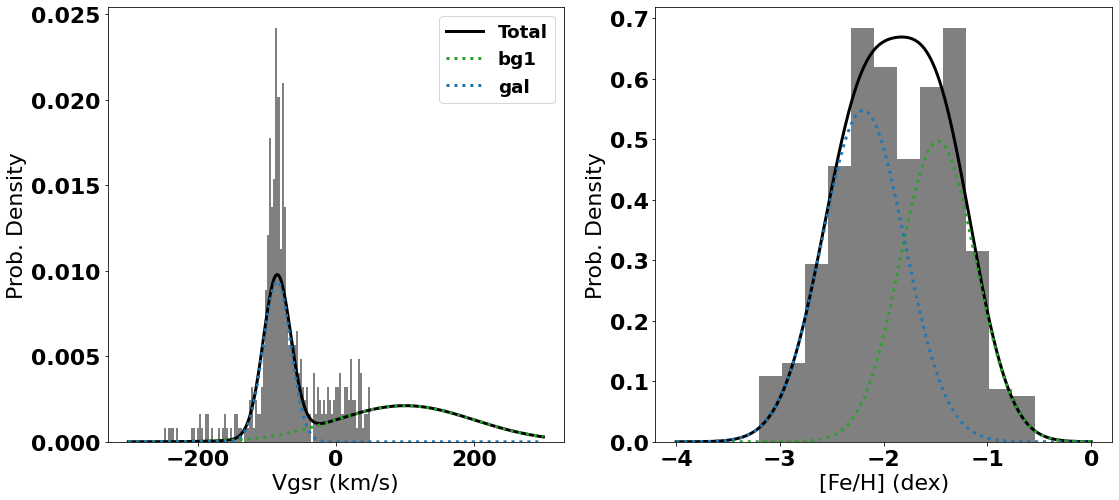

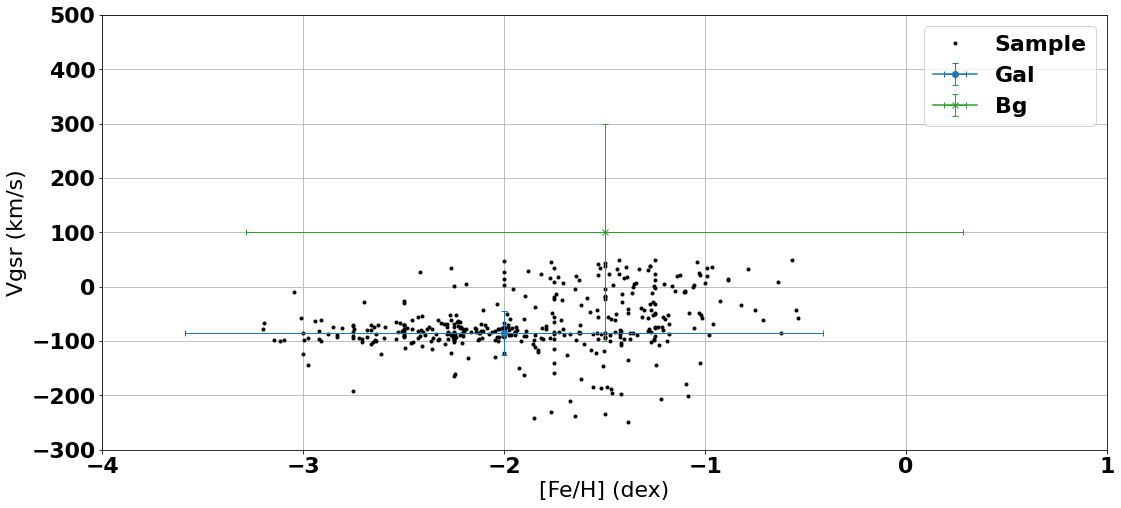

In [59]:
#vrad/Feh distribution

fig1 = plot_1d_distrs(p0_guess,datasum,p1min=-300, p1max=300, p2min=-4, p2max=0.,key="vhel")
fig2 = plot_2d_distr(p0_guess,datasum,key="vhel")

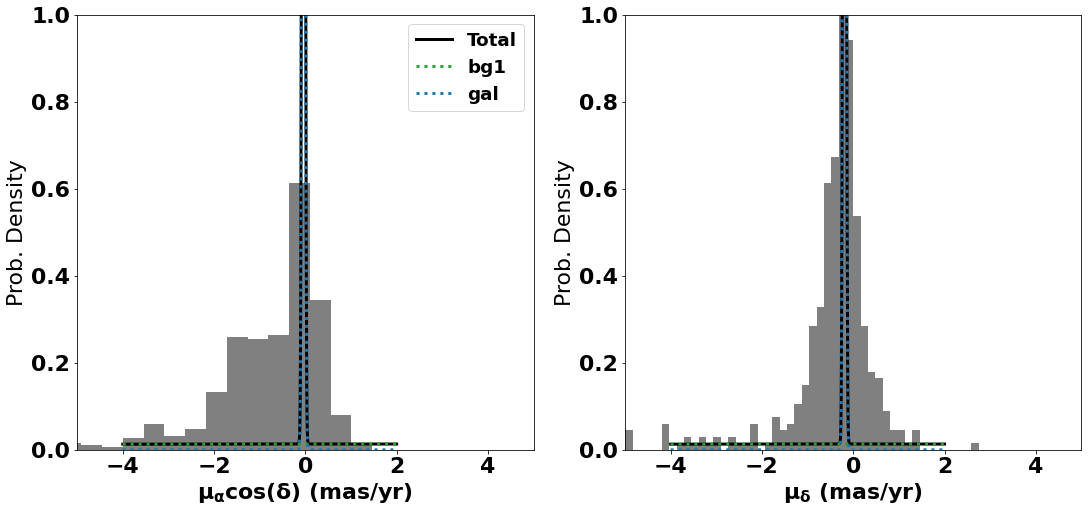

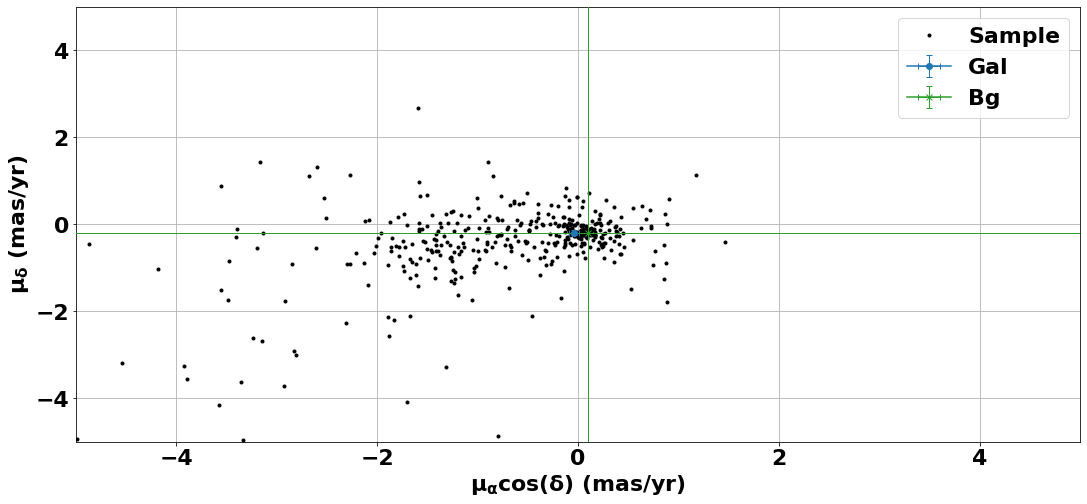

In [60]:
#pmra/pmdec distribution 
fig1 = plot_1d_distrs(p0_guess,datasum,p1min=-5, p1max=5, p2min=-5, p2max=5.,key="pmra")
fig2 = plot_2d_distr(p0_guess,datasum,key="pmra")

In [61]:
#guess for the initial parameters
p0_guess

[0.47,
 -85,
 1.3,
 -2.0,
 -0.1,
 100,
 2.0,
 -1.5,
 -0.05,
 -0.04,
 -0.19,
 0.1,
 -0.2,
 1.2,
 1.2]

In [62]:
optfunc = lambda theta: -full_like(theta)

In [63]:
%timeit optfunc(p0_guess)

61.7 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
optfunc(p0_guess)

8148.1479377661835

In [65]:
%time res = optimize.minimize(optfunc, p0_guess, method="Nelder-Mead")

CPU times: user 3min 6s, sys: 1 s, total: 3min 7s
Wall time: 3min 5s


In [66]:
res.x

array([ 5.46809697e-01, -8.49271262e+01,  1.10845903e+00, -2.19340198e+00,
       -2.53188194e+00, -4.95981004e+01,  1.85510175e+00, -1.48823779e+00,
       -7.99686047e-01,  3.96942555e-02, -1.82828149e-01, -2.17596258e+00,
       -3.65912149e-01,  5.59180960e-01,  4.64573279e-01])

In [67]:
optfunc(res.x)

7397.73472518387

In [68]:
for label, p in zip(param_labels, res.x):
    print(f"{label}: {p:.3f}")

pgal: 0.547
vhel: -84.927
lsigv: 1.108
feh: -2.193
lsigfeh: -2.532
vbg1: -49.598
lsigvbg1: 1.855
fehbg1: -1.488
lsigfeh1: -0.800
pmra: 0.040
pmdec: -0.183
pmra1: -2.176
pmdec1: -0.366
lsigpmra1: 0.559
lsigpmdec1: 0.465


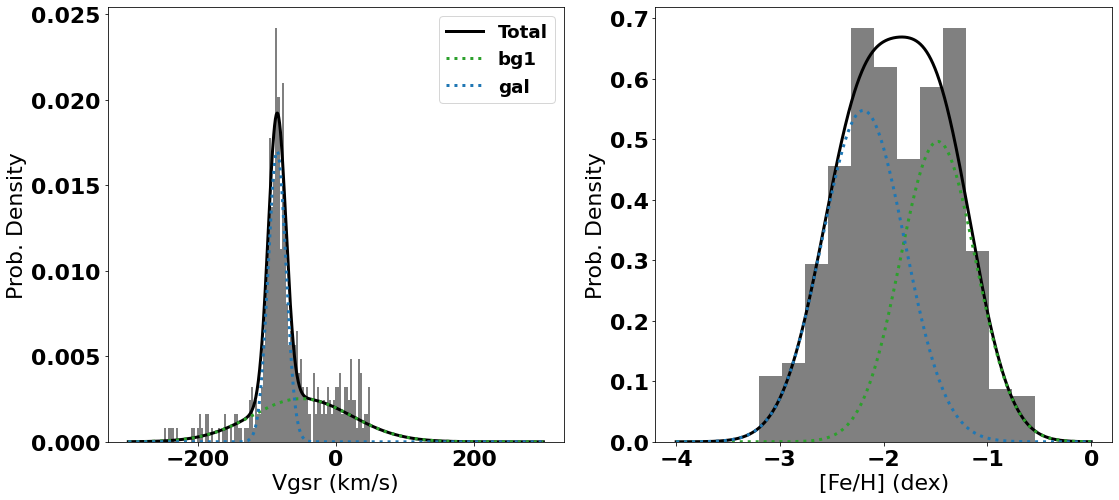

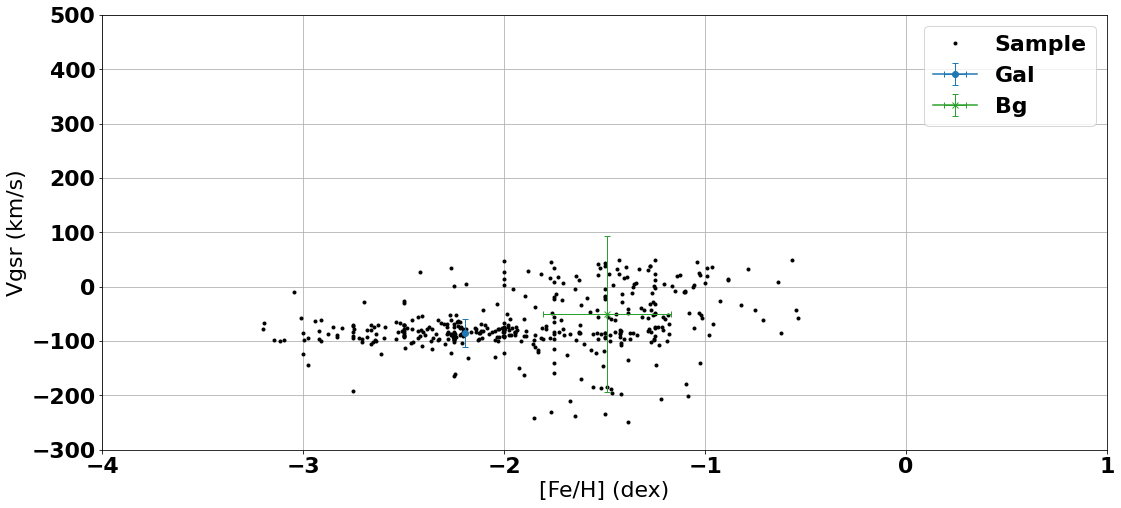

In [69]:

fig1 = plot_1d_distrs(res.x,datasum,p1min=-300, p1max=300, p2min=-4, p2max=0.,key="vhel")
fig2 = plot_2d_distr(res.x,datasum,key="vhel")

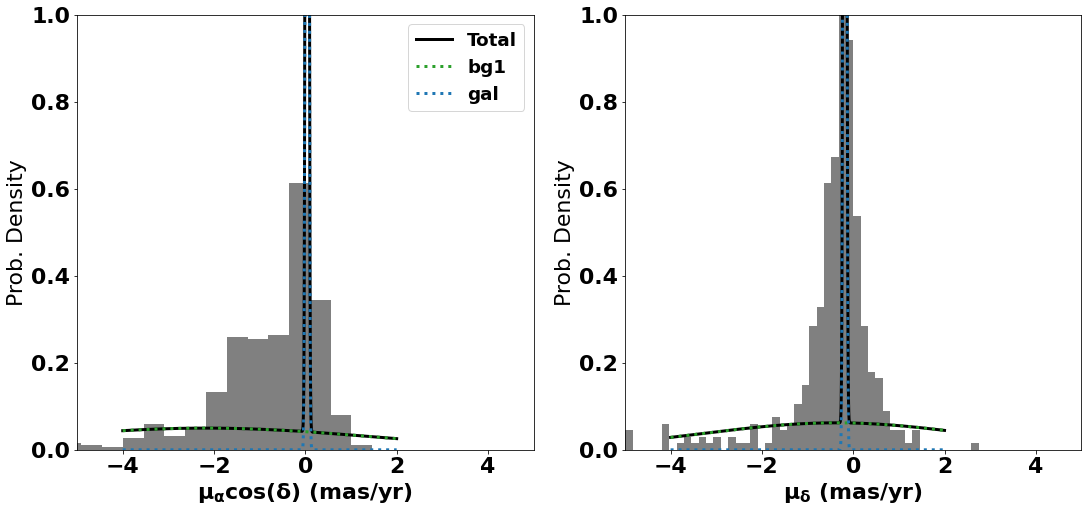

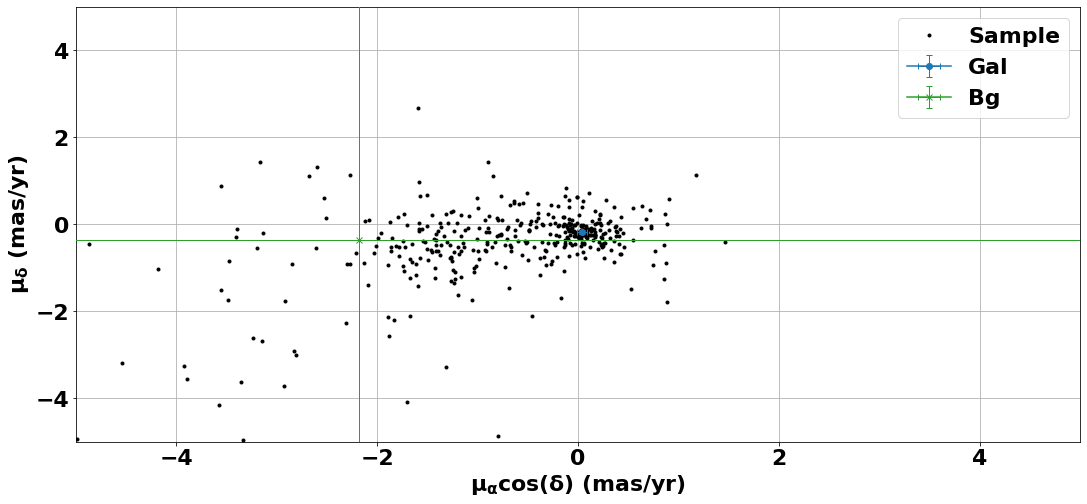

In [70]:
#plotting the posterior distribution for pmra and pmdec
fig1 = plot_1d_distrs(res.x,datasum,p1min=-5, p1max=5, p2min=-5, p2max=5,key="pmra")
fig2 = plot_2d_distr(res.x,datasum,key="pmra")

## Posterior Sampling
The posterior is sampled using `emcee` with 64 walkers and 10,000 steps per chain.

In [71]:
nw = 128
p0 = res['x']
nit = 5000
ep0 = np.zeros(len(p0_guess)) + 0.02
#p0s = np.random.multivariate_normal(p0_guess, np.diag(ep0)**2, size=nw)
#print(p0s)


In [72]:
p0_guess

[0.47,
 -85,
 1.3,
 -2.0,
 -0.1,
 100,
 2.0,
 -1.5,
 -0.05,
 -0.04,
 -0.19,
 0.1,
 -0.2,
 1.2,
 1.2]

In [73]:
np.random.uniform(low=-200, high=20, size=1)

array([-144.36630951])

In [74]:
nparams = len(param_labels)
print(nparams)
nwalkers = 128
p0 = p0_guess
ep0 = np.zeros(len(p0)) + 0.02 # some arbitrary width that's pretty close; scale accordingly to your expectation of the uncertainty
p0s = np.random.multivariate_normal(p0, np.diag(ep0)**2, size=nwalkers)

## Check to see things are initialized ok
lkhds = [full_like(p0s[j]) for j in range(nwalkers)]
assert np.all(np.array(lkhds) > -9e9)

15


In [75]:
## Run emcee in parallel

from schwimmbad import MultiPool

nproc = 64 #use 64 cores
nit = 3000

def get_rstate():
    return np.random.mtrand.RandomState(seed=np.random.randint(0,2**32-1))

with MultiPool(nproc) as pool:
    print("Running burnin with {} iterations".format(nit))
    start = time.time()
    es = emcee.EnsembleSampler(nw, len(p0_guess), full_like, pool=pool)
    PP = es.run_mcmc(p0s, nit, rstate0=get_rstate())
    print("Took {:.1f} seconds".format(time.time()-start))

    print(f"Now running the actual thing")
    es.reset()
    start = time.time()
    es.run_mcmc(PP.coords, nit, rstate0=get_rstate())
    print("Took {:.1f} seconds".format(time.time()-start))


Running burnin with 3000 iterations
Took 685.6 seconds
Now running the actual thing
Took 645.0 seconds


In [76]:
outputs = es.flatchain

In [77]:
plt.style.use('default')

### Acceptance fraction
Judging the convergence and performance of an algorithm is a non-trival problem. As a rule of thumb, the acceptance fraction should be between 0.2 and 0.5 (for example, Gelman, Roberts, & Gilks 1996).

In [78]:
# Another good test of whether or not the sampling went well is to 
# check the mean acceptance fraction of the ensemble
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(es.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.311


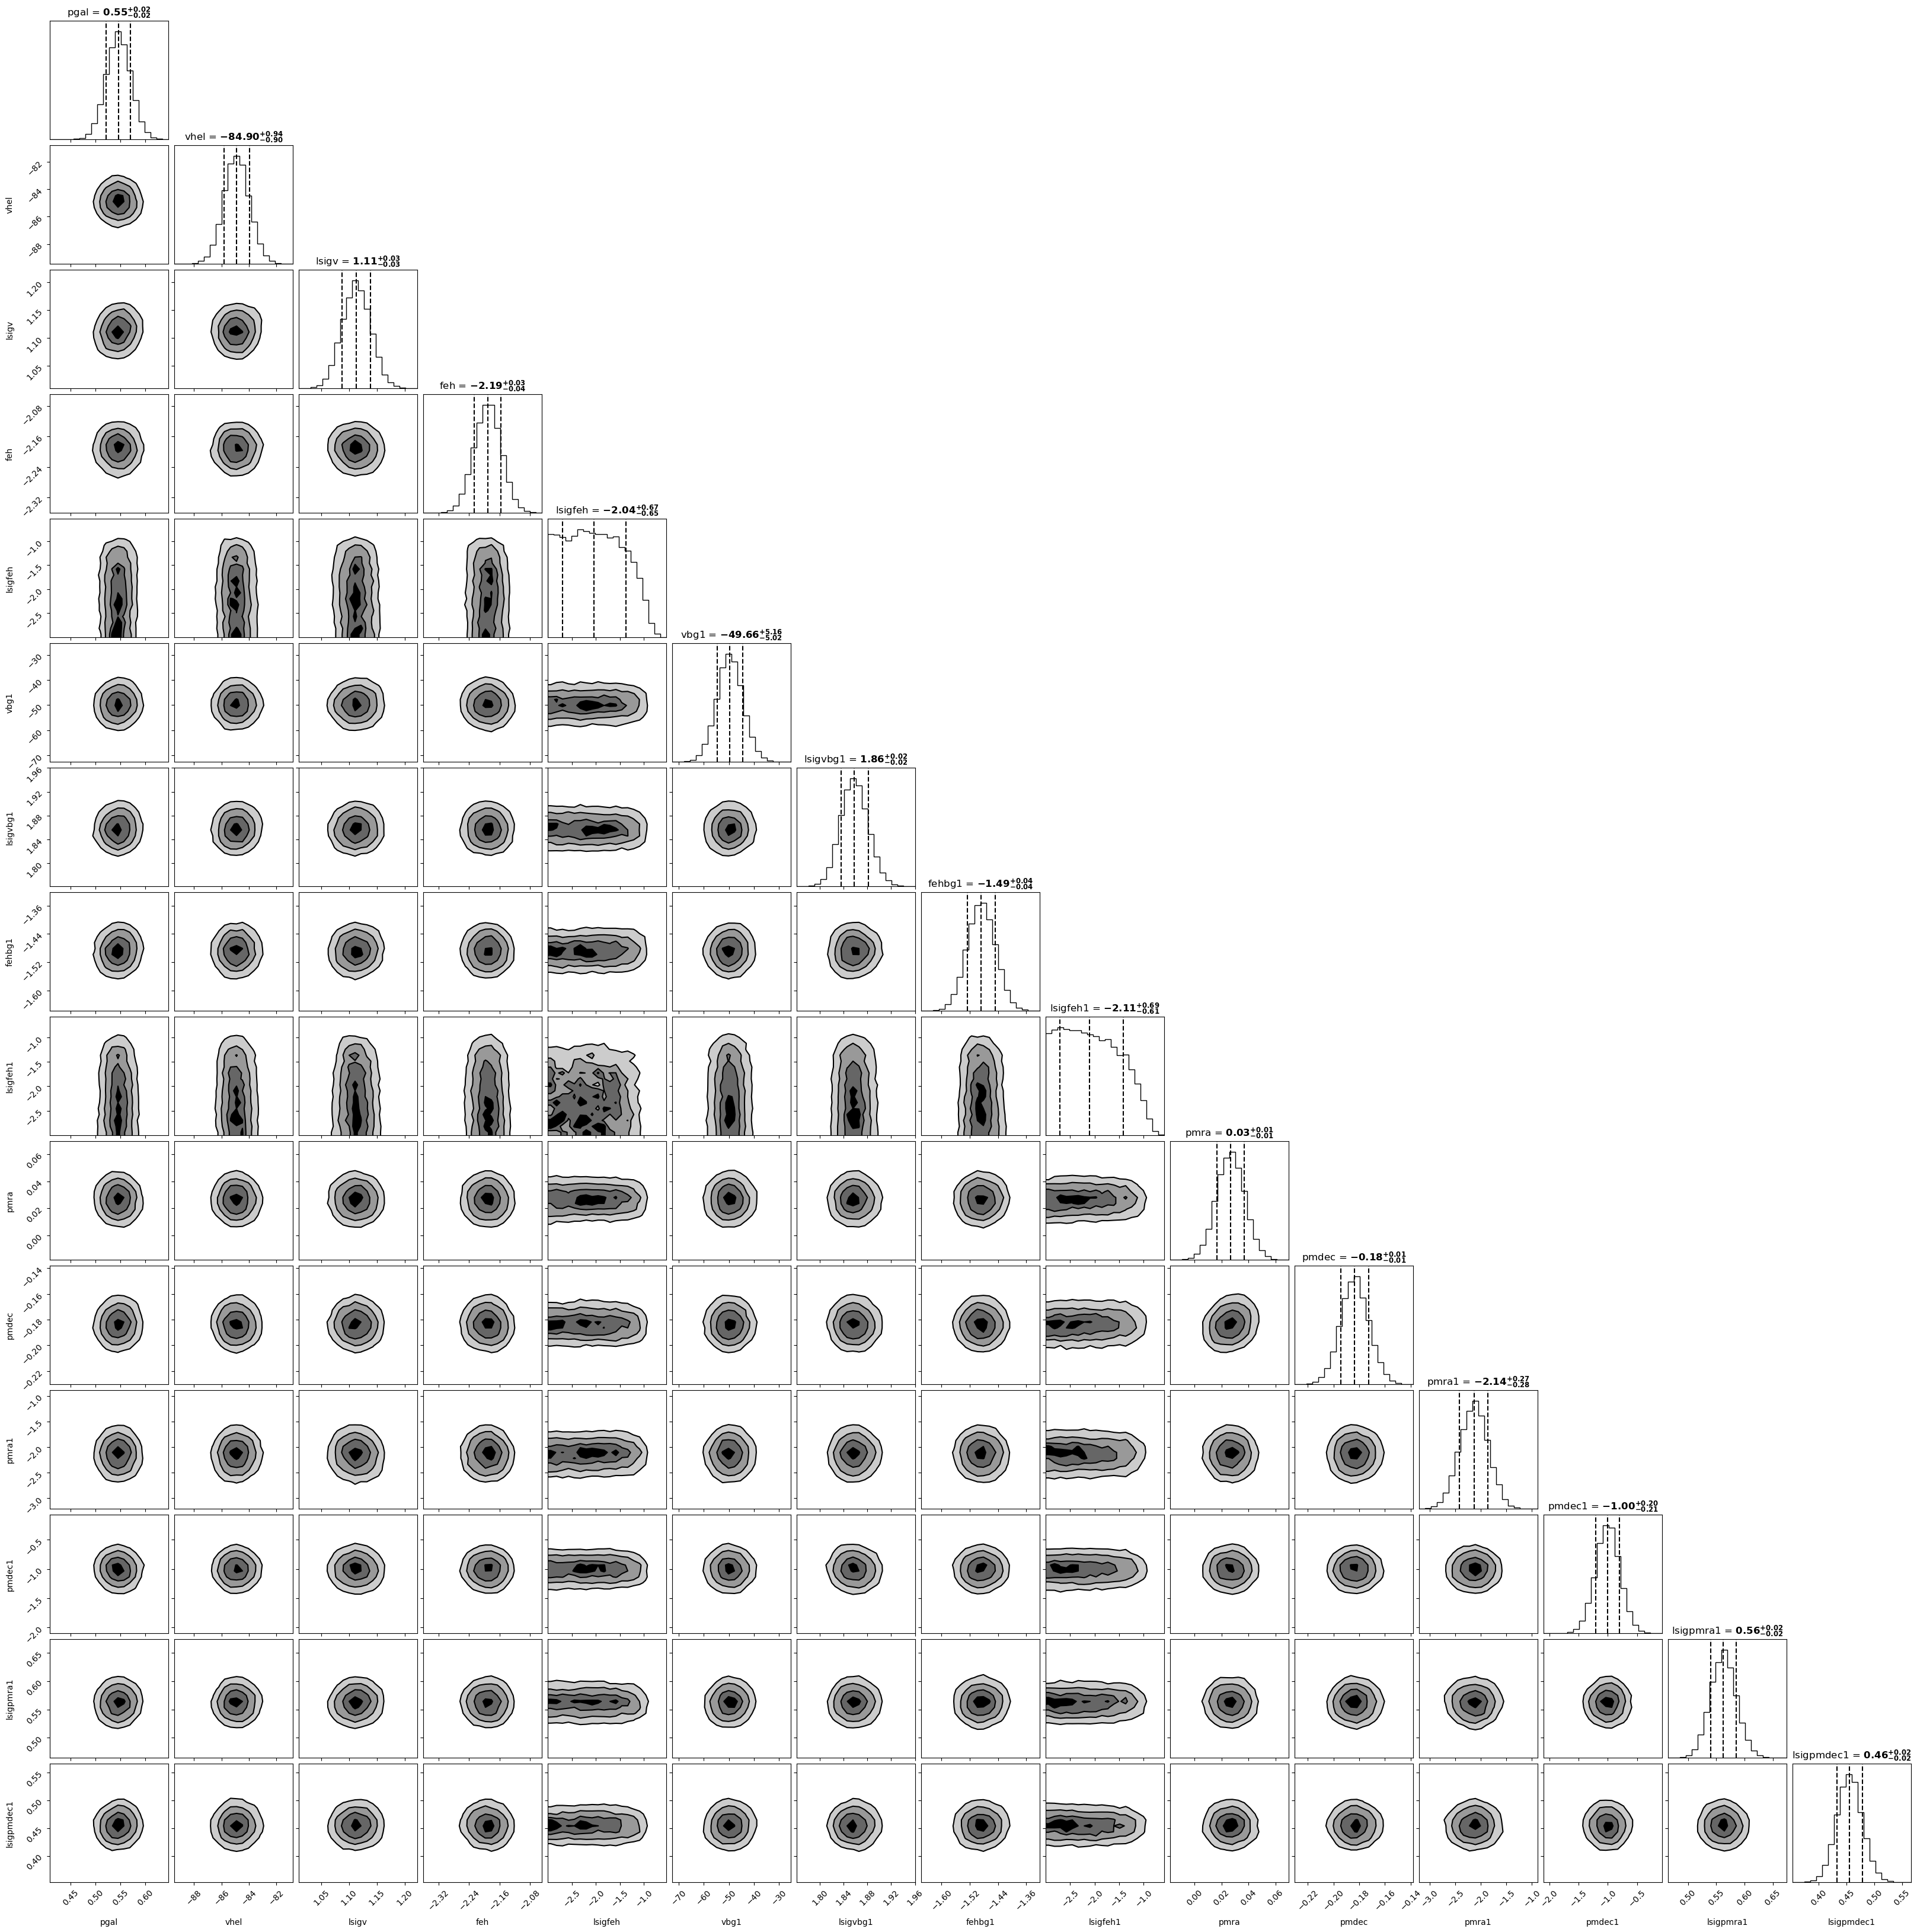

In [79]:
fig = corner.corner(outputs, labels=param_labels, quantiles=[0.16,0.50,0.84], show_titles=True,color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

#plt.savefig('SMCNOD_PM_Model_Cornerplot.png')

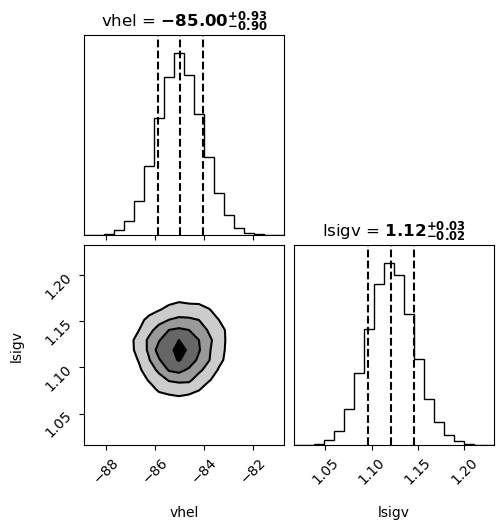

In [182]:
fig1 = corner.corner(outputs[:,1:3], labels=param_labels[1:3], quantiles=[0.16,0.50,0.84], show_titles=True,color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

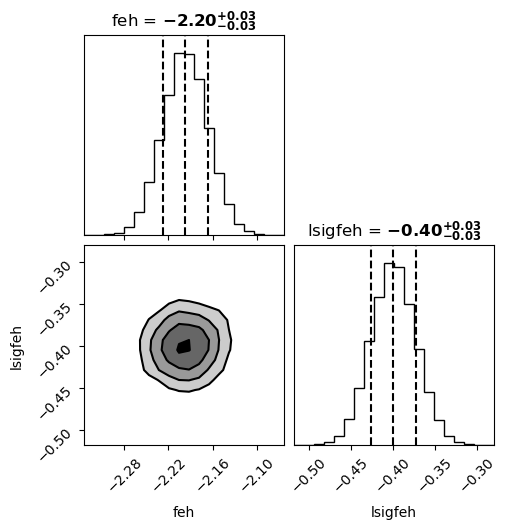

In [183]:
fig2 = corner.corner(outputs[:,3:5], labels=param_labels[3:5], quantiles=[0.16,0.50,0.84], show_titles=True,color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})


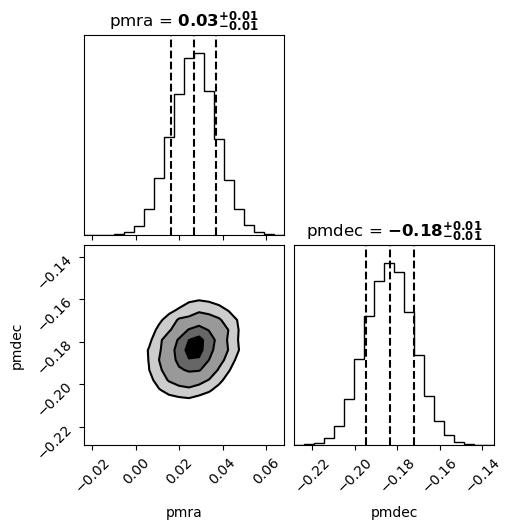

In [184]:
fig3 = corner.corner(outputs[:,9:11], labels=param_labels[9:11], quantiles=[0.16,0.50,0.84], show_titles=True,color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

In [185]:
def process_chain(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    meds = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error: # just for simplicity, assuming no asymmetry
        err = (ep-em)/2
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, err))
    else:
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, ep)), OrderedDict(zip(param_labels, em))
    
    
    

In [186]:
meds, errs = process_chain(outputs)

In [187]:
for k,v in meds.items():
    print("{} {:.3f} {:.3f}".format(k, v, errs[k]))

pgal 0.548 0.025
vhel -85.001 0.917
lsigv 1.121 0.025
feh -2.197 0.031
lsigfeh -0.399 0.027
vbg1 -49.677 5.252
lsigvbg1 1.858 0.023
fehbg1 -1.478 0.032
lsigfeh1 -0.440 0.032
pmra 0.027 0.010
pmdec -0.184 0.011
pmra1 -2.163 0.268
pmdec1 -0.989 0.208
lsigpmra1 0.563 0.023
lsigpmdec1 0.455 0.023


In [188]:
get_paramdict(outputs[1])

OrderedDict([('pgal', 0.4933046542148105),
             ('vhel', -84.62204207264665),
             ('lsigv', 1.1587549330976241),
             ('feh', -2.1761537621507263),
             ('lsigfeh', -0.39870986857701357),
             ('vbg1', -49.59217979263243),
             ('lsigvbg1', 1.8366337877735113),
             ('fehbg1', -1.5043283449590341),
             ('lsigfeh1', -0.4565199857804994),
             ('pmra', 0.03685689535551788),
             ('pmdec', -0.19299032482074008),
             ('pmra1', -1.9864654324062476),
             ('pmdec1', -0.7985909397698018),
             ('lsigpmra1', 0.5543181068755427),
             ('lsigpmdec1', 0.4443390972088209)])

If things are well mixed, then you can just use the flat chain to concatenate all the walkers and steps.
The results here may not be perfectly mixed, but it's not terrible.
There are fancy ways to check things here involving autocorrelation times that Alex does not know about.
To me this is the hard part of emcee: knowing when you're happy with the result, and setting things up so that it gets there as fast as possible. This is why I prefer dynesty, even though it's slower it has a motivated stopping condition.

In [189]:
chain = es.flatchain
chain.shape

(384000, 15)

You can see the output of the fit as a corner plot. Basically you want everything to be nice and round, and if not that means you didn't initialize your walkers well enough or burn in for long enough.

It's customary to summarize the data with percentiles, but you should check the corner plot diagonal to see if this is a good idea.

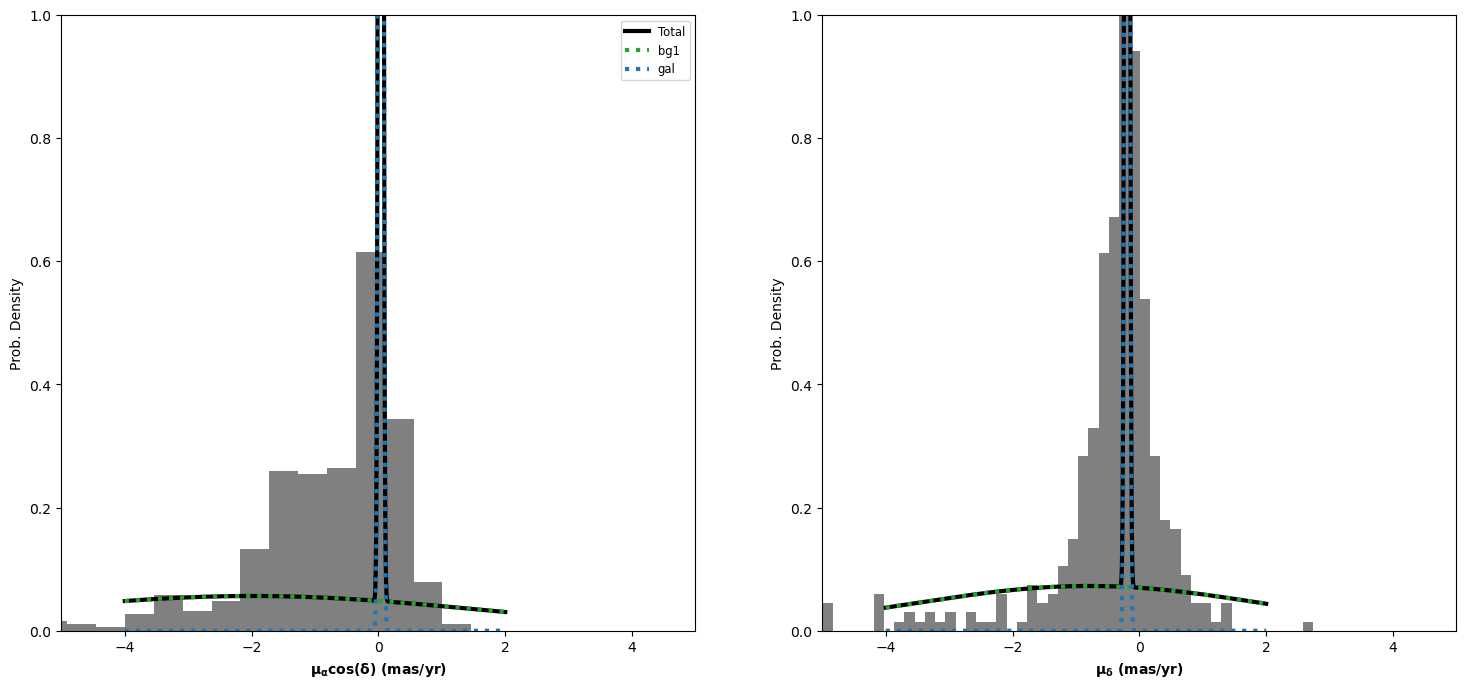

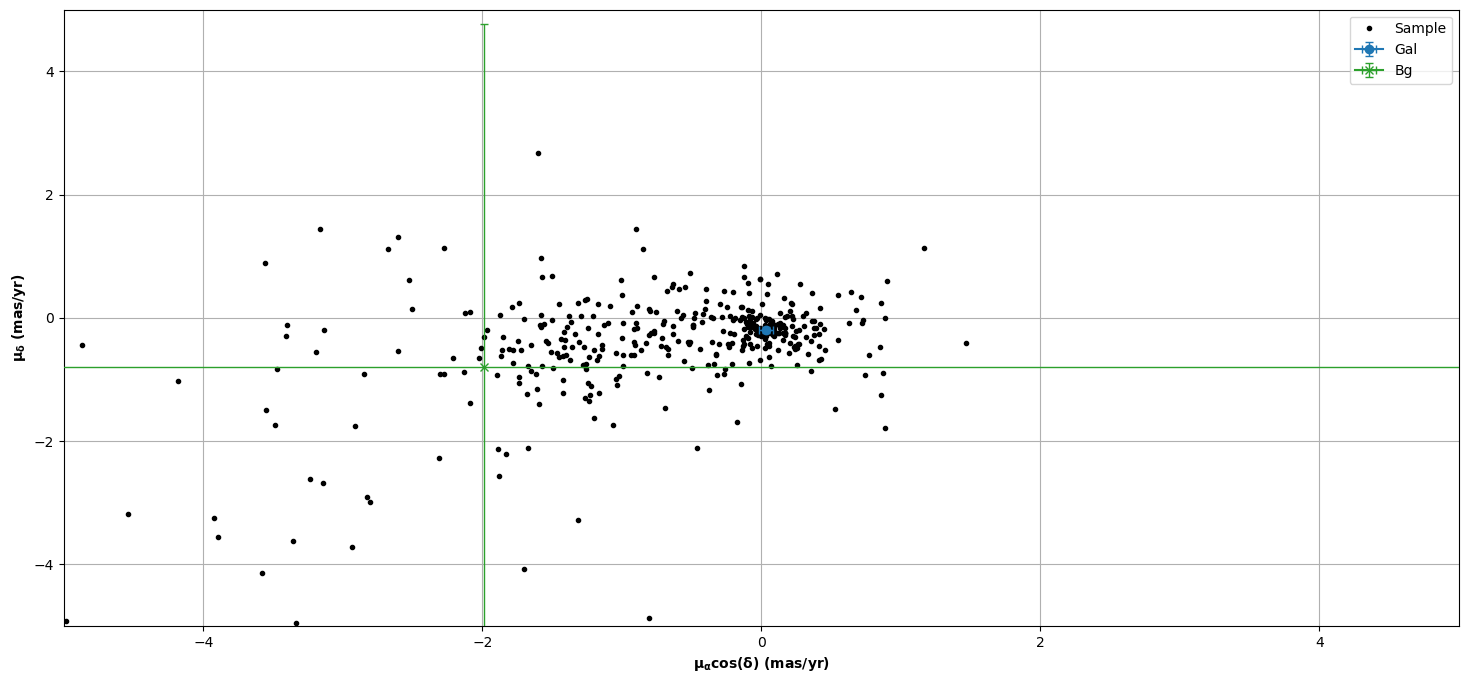

In [190]:
#plotting the posterior distribution for vral and FeH
fig1 = plot_1d_distrs(chain[1],datasum,p1min=-300, p1max=300, p2min=-3.5, p2max=-0.5,key="vh")
fig2 = plot_2d_distr(chain[1],datasum,key="vh")

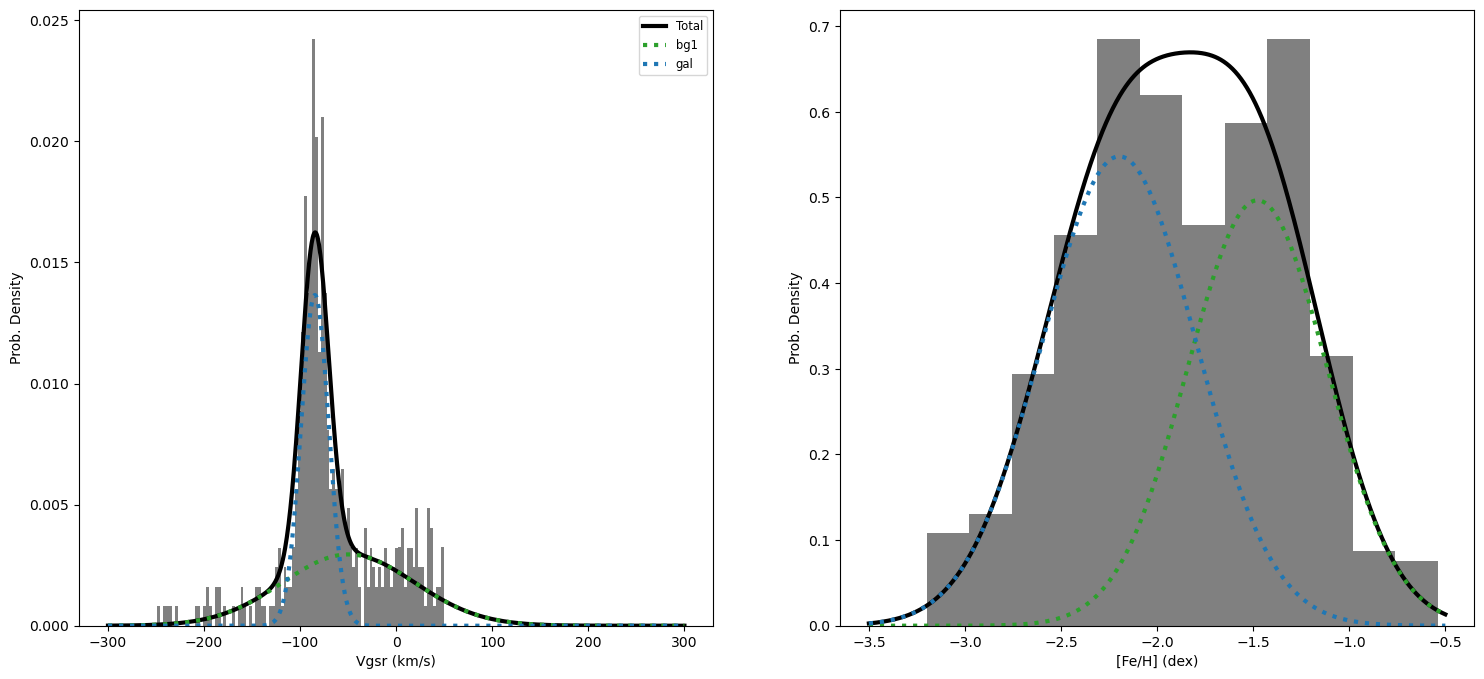

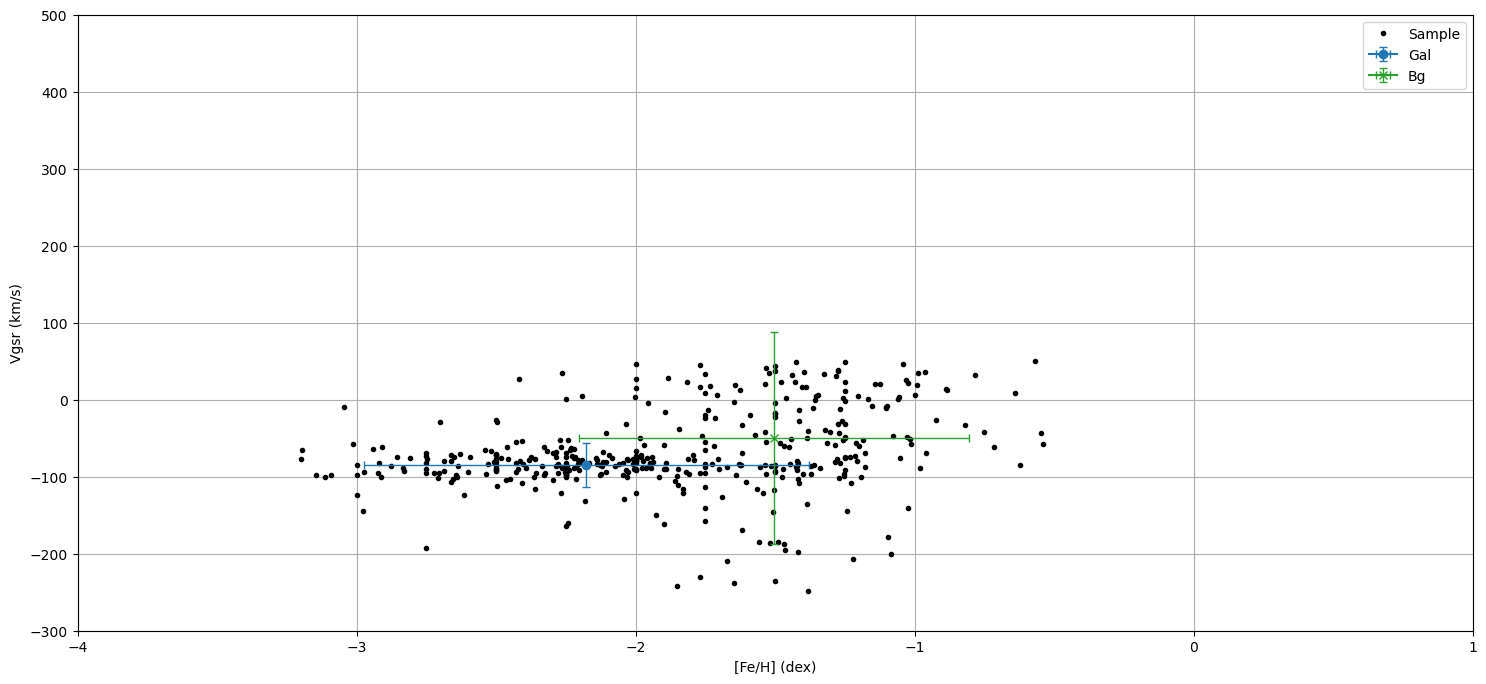

In [203]:
#plotting the posterior distribution for vral and FeH
fig1 = plot_1d_distrs(chain[1],datasum,p1min=-300, p1max=300, p2min=-3.5, p2max=-0.5,key="vhel")
fig2 = plot_2d_distr(chain[1],datasum,key="vhel")

In [192]:
plt.hist(fehsample,density=True)

NameError: name 'fehsample' is not defined

(array([4.0000e+00, 3.0000e+00, 3.2000e+01, 1.2200e+02, 2.3200e+02,
        7.3600e+02, 1.6860e+03, 3.4100e+03, 6.4530e+03, 1.1542e+04,
        1.7147e+04, 2.4777e+04, 3.1966e+04, 3.9610e+04, 4.5420e+04,
        4.4273e+04, 4.1678e+04, 3.6236e+04, 2.7932e+04, 2.0036e+04,
        1.3350e+04, 8.2930e+03, 4.7120e+03, 2.2900e+03, 1.0940e+03,
        4.9200e+02, 2.9900e+02, 1.1300e+02, 3.8000e+01, 2.4000e+01]),
 array([-2.33494327, -2.3258697 , -2.31679612, -2.30772255, -2.29864898,
        -2.2895754 , -2.28050183, -2.27142825, -2.26235468, -2.2532811 ,
        -2.24420753, -2.23513396, -2.22606038, -2.21698681, -2.20791323,
        -2.19883966, -2.18976608, -2.18069251, -2.17161894, -2.16254536,
        -2.15347179, -2.14439821, -2.13532464, -2.12625107, -2.11717749,
        -2.10810392, -2.09903034, -2.08995677, -2.08088319, -2.07180962,
        -2.06273605]),
 <BarContainer object of 30 artists>)

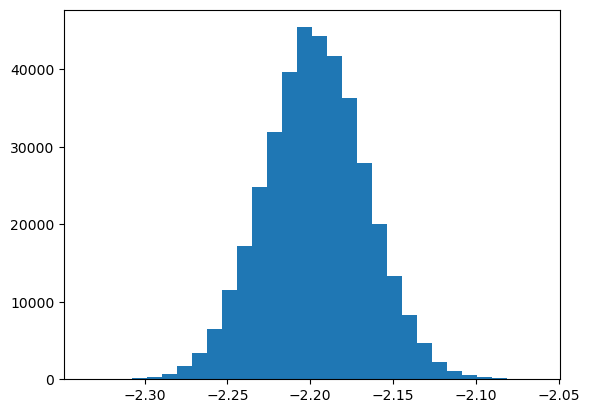

In [193]:
plt.hist(outputs[:,3],density=False,bins=30)

In [102]:
10**chain[:,4]

array([0.3424293 , 0.36261669, 0.37710721, ..., 0.38079847, 0.30624153,
       0.31845387])

In [103]:
len(datasum[0])

422

In [104]:
fehsample = []
fehmsam = []
for ii in range(0,2000):
    xarr= np.linspace(-4, 0, 1000)
    fehm = np.random.choice(chain[:,3],1,replace = False)
    fehstd = np.random.choice(chain[:,4],1,replace = False)
    fehmm = np.random.choice(chain[:,7],1,replace = False)
    fehmstd = np.random.choice(chain[:,8],1,replace = False)
    
    fehsample.append(np.random.normal(loc=fehm, scale=10**fehstd,size=int(422*0.545)))
    fehmsam.append(np.random.normal(loc=fehmm, scale=10**fehmstd,size=int(422*(1-0.545))))
    
#print (np.percentile(chain_new[:,2], 50))
#
#plt.hist(datasum[2],density=False,alpha=0.5,bins=30)


In [105]:
len(fehsample)

2000

NameError: name 'testp' is not defined

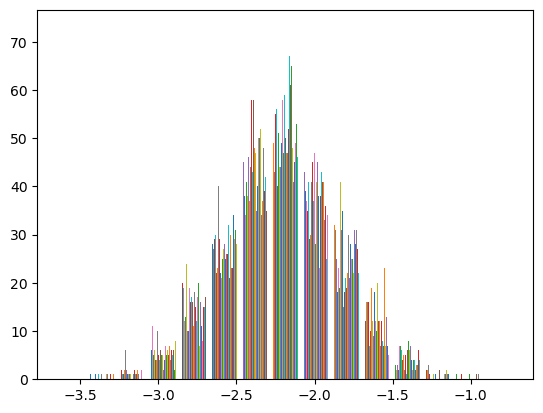

In [106]:
plt.hist(fehsample[:150],density=False,bins=15)
plt.hist(datasum[2][np.concatenate(testp)> 0.75],density=False,alpha=0.5,bins=15,label='real')
plt.xlabel('FeH')
plt.legend()

In [107]:
fehmsam[0]

array([-1.85768599, -1.74526587, -1.75024905, -1.47303046, -1.75019769,
       -1.77770087, -0.19193182, -1.5767233 , -2.08233055, -1.19393987,
       -1.18959609, -1.42070588, -1.77187068, -1.77140538, -1.47675239,
       -1.89902966, -1.57015522, -2.29363525, -2.0677491 , -1.31486409,
       -1.64011992, -1.39143736, -1.49354313, -1.98639823, -1.42644659,
       -2.19196774, -1.50365996, -1.55305997, -1.4388663 , -1.54850735,
       -1.30771901, -1.74180411, -1.65520652, -1.49337702, -0.95476845,
       -1.25156277, -1.49212538, -1.45227488, -1.4353843 , -1.27877147,
       -1.00955643, -0.31418762, -1.21329854, -1.30959578, -1.85976716,
       -1.77342892, -1.31350809, -1.46433437, -2.12321005, -0.99210823,
       -1.54170195, -1.82136198, -1.05000764, -1.46888232, -1.53152848,
       -1.11802894, -1.52769344, -1.27060866, -1.38380002, -1.30742543,
       -1.63818128, -2.04502288, -1.34604782, -1.30038464, -1.49652398,
       -1.60791318, -1.56048594, -1.49410888, -1.30193918, -1.97

In [108]:
np.mean(fehmsam,axis=1)

array([-1.50983256, -1.46810331, -1.50614653, ..., -1.48056901,
       -1.55826299, -1.49256438])

In [109]:
feht= np.concatenate([np.mean(fehmsam,axis=0),np.mean(fehsample,axis=0)])

In [110]:
feht

array([-1.48271378, -1.49140785, -1.4760428 , -1.47811298, -1.47744223,
       -1.47164278, -1.48431253, -1.47627826, -1.48170493, -1.48109043,
       -1.4769951 , -1.48427252, -1.46471884, -1.47508479, -1.46629698,
       -1.48666262, -1.48324095, -1.4770769 , -1.48574079, -1.48616911,
       -1.47364084, -1.48046111, -1.47102755, -1.47487772, -1.46809125,
       -1.48508017, -1.48251815, -1.47694705, -1.47610152, -1.47775232,
       -1.48619977, -1.48649185, -1.47848603, -1.47519828, -1.48247213,
       -1.48357376, -1.47717449, -1.474426  , -1.48202058, -1.47785679,
       -1.4682214 , -1.47678523, -1.46425376, -1.48138357, -1.47069079,
       -1.48219011, -1.47395413, -1.47804012, -1.47419788, -1.47927892,
       -1.46589488, -1.49191369, -1.49047799, -1.47966478, -1.4601326 ,
       -1.48229764, -1.4670182 , -1.47174218, -1.48573987, -1.48110281,
       -1.47272165, -1.4766666 , -1.47921928, -1.48392911, -1.48649266,
       -1.47603687, -1.47727352, -1.46795138, -1.49522402, -1.48

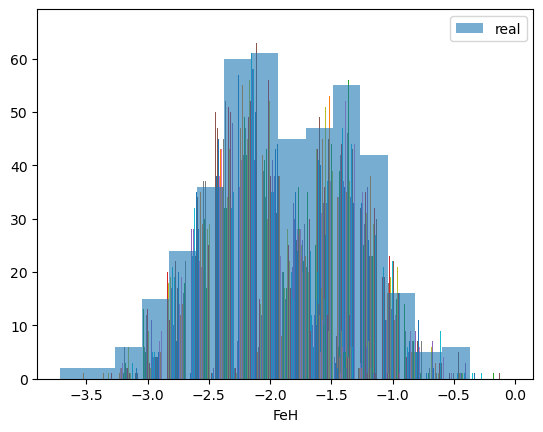

In [111]:
plt.hist(fehmsam[:100],density=False,bins=15)
plt.hist(fehsample[:100],density=False,bins=15)
#plt.hist(feht,density=False,bins=15)
plt.hist(datasum[2],density=False,alpha=0.6,bins=15,label='real')
plt.xlabel('FeH')
plt.legend()

In [115]:
datasum

[<Column name='VGSR' dtype='float64' unit='km / s' length=422>
 -121.63564527564824
   -96.0692606575322
  -88.39183040746258
 -107.54985681938072
   -89.4981072139831
   20.99104837419614
  32.793089910760415
  -230.0061531647779
 -195.22824299981536
 -10.612327589869807
  -33.38467714685706
   43.80092975141949
                 ...
   -65.3843305217203
    9.26846206433973
   41.45971781014239
  21.879470218318772
 -150.06459746683922
  3.1379786677273387
 -117.58968277565506
 -100.19910035661368
 -120.62202019444734
  15.008128777742087
 -209.35168480140658
 -206.55439922859736,
 <Column name='VRAD_ERR' dtype='float64' length=422>
   1.654701827782092
  2.8213667467928523
  0.5288289217047012
 0.24992405355118932
  0.9462638550460103
  3.7622640315281197
  0.8955136488354586
   4.249130829686015
  2.3421906053564445
   1.761247063264134
  2.2804418986700012
 0.40284285986016305
                 ...
   3.116111490549325
  1.5656669061057746
  0.9785022698757305
  1.8078634153733824
 

In [116]:
print (len(datasum[2][(datasum[2]< -2.0)]))


181


(array([ 29.,  85., 265., 232., 430., 268., 300., 157., 131.,  56.,  28.,
          9.,   5.,   2.,   3.]),
 array([ 0.        ,  2.46666667,  4.93333333,  7.4       ,  9.86666667,
        12.33333333, 14.8       , 17.26666667, 19.73333333, 22.2       ,
        24.66666667, 27.13333333, 29.6       , 32.06666667, 34.53333333,
        37.        ]),
 <BarContainer object of 15 artists>)

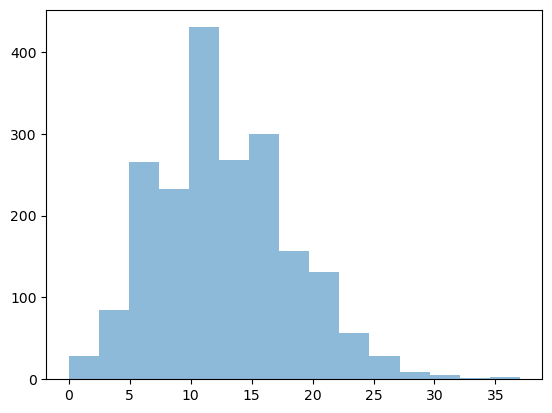

In [117]:
leng = []
lengm = [] 
for ii in range(0,2000):
    leng.append(len(fehsample[ii][(fehsample[ii]< -2.0) ]))
    lengm.append(len(fehmsam[ii][(fehmsam[ii]< -2.0) ]))

plt.hist(lengm,density=False,alpha=0.5,bins=15,label='real')

In [118]:
np.mean(leng),np.std(leng),np.mean(lengm),np.std(lengm)

(165.1635, 10.745453352464938, 12.6685, 5.604249079939256)

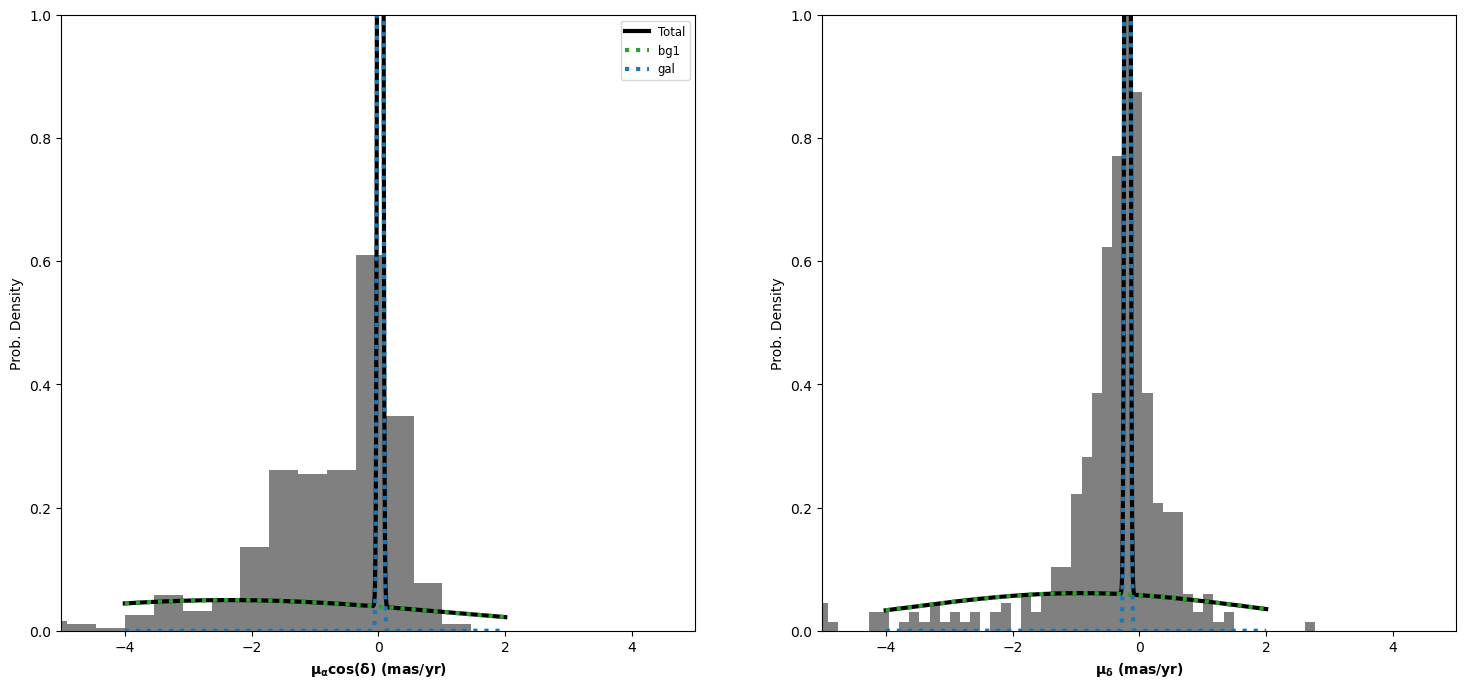

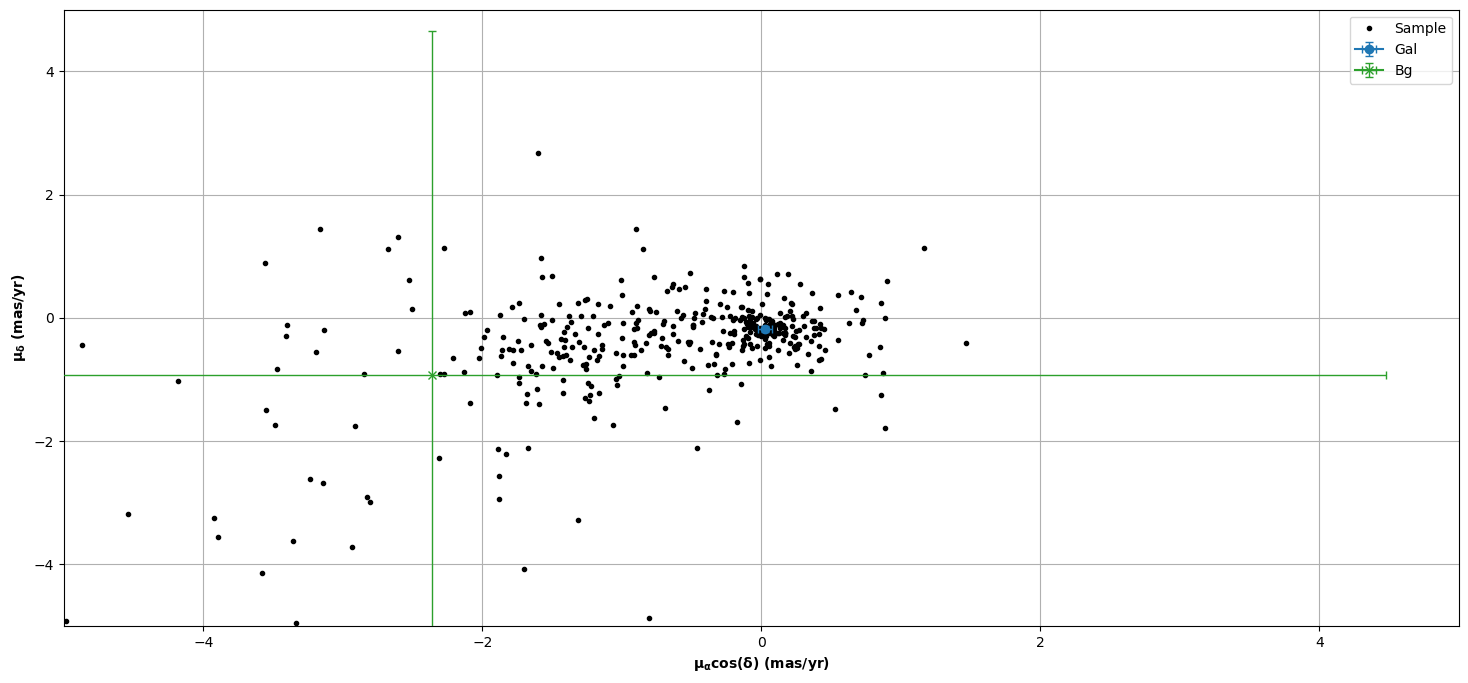

In [137]:
#plotting the posterior distribution for pmra and pmdec
fig1 = plot_1d_distrs(chain[1],datasum,p1min=-5, p1max=5, p2min=-5, p2max=5,key="pmra")
fig2 = plot_2d_distr(chain[1],datasum,key="pmra")

In [132]:
chain_new = 10**(chain)
mean_vdisp = np.percentile(chain_new[:,2], 50)
std_vdisp = (np.percentile(chain_new[:,2], 84)-np.percentile(chain_new[:,2], 16))/2
mean_fehdisp = np.percentile(chain_new[:,4], 50)
std_fehdisp = (np.percentile(chain_new[:,4], 84)-np.percentile(chain_new[:,4], 16))/2
print("mean_vdisp: ",mean_vdisp, \
     "std_vdisp: ",std_vdisp)
print("mean_fehdisp: ",mean_fehdisp, \
     "std_fehdisp: ",std_fehdisp)

mean_vdisp:  13.123610716260929 std_vdisp:  0.7576456761274333
mean_fehdisp:  0.35974587341735437 std_fehdisp:  0.029635691262372837


In [112]:
len(chain_new[:,3])

384000

In [113]:
fehsample = np.random.choice(chain_new[:,3],800000,replace = False)


ValueError: Cannot take a larger sample than population when 'replace=False'

(array([[0.        , 0.        , 0.04374095, ..., 0.        , 0.01458032,
         0.        ],
        [0.        , 0.        , 0.01458032, ..., 0.10206221, 0.01458032,
         0.        ],
        [0.        , 0.        , 0.05832126, ..., 0.08748189, 0.01458032,
         0.        ],
        ...,
        [0.        , 0.        , 0.08748189, ..., 0.07290158, 0.        ,
         0.        ],
        [0.01458032, 0.        , 0.11664252, ..., 0.13122284, 0.        ,
         0.        ],
        [0.        , 0.        , 0.01458032, ..., 0.02916063, 0.01458032,
         0.        ]]),
 array([-3.67517607, -3.37567554, -3.076175  , -2.77667447, -2.47717393,
        -2.1776734 , -1.87817287, -1.57867233, -1.2791718 , -0.97967127,
        -0.68017073]),
 <a list of 2000 BarContainer objects>)

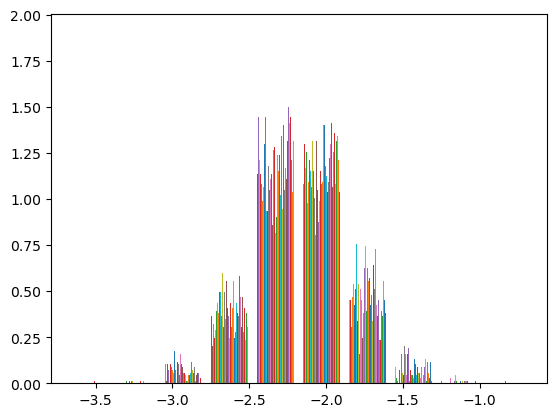

In [114]:
plt.hist(fehsample,density=True)

In [115]:
param_labels_1 = ["pgal =",
                "vhel =","lsigv =","feh =","lsigfeh =",
                "vbg1 =","lsigvbg1 =","fehbg1 =","lsigfeh1 =",
                "pmra =","pmdec =",
                "pmra1 =","pmdec1 =","lsigpmra1 =","lsigpmdec1 ="]

def process_chain_1(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    median = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error:
        err = (ep-em)/2
        return OrderedDict(zip(param_labels_1, median)), OrderedDict(zip(param_labels_1, err))
    else:
        return OrderedDict(zip(param_labels_1, median)), OrderedDict(zip(param_labels_1, ep)), OrderedDict(zip(param_labels_1, em))

meds_1, errs_1 = process_chain_1(outputs)
pval  = []
for k,v in meds_1.items():
    pval.append(v)
    print("{} {:.3f}".format(k, v))

pgal = 0.539
vhel = -84.739
lsigv = 1.099
feh = -2.166
lsigfeh = -0.536
vbg1 = -49.962
lsigvbg1 = 1.859
fehbg1 = -1.466
lsigfeh1 = -0.449
pmra = 0.027
pmdec = -0.179
pmra1 = -2.156
pmdec1 = -0.997
lsigpmra1 = 0.563
lsigpmdec1 = 0.456


In [116]:
pval


[0.5387051361590345,
 -84.73865434224089,
 1.0991593252078782,
 -2.165934317742959,
 -0.5360767397906284,
 -49.96177641827795,
 1.8592893629616525,
 -1.4662077708495218,
 -0.44864690519169637,
 0.02732788277388567,
 -0.17880117819881614,
 -2.1558521538715896,
 -0.9973079026479008,
 0.563141794172926,
 0.45591311459221606]

In [117]:
#proability function for each stars to be member 
def prob(itot):
    probi=[]
    other = []
    for ii in range(itot):
       
        lgal,lbg1,ltot,_ = full_like_indi(pval,ii)
        print (ltot)
        probi.append(np.exp(lgal)/np.exp(ltot))
        other.append(_)
    return probi,other

In [118]:
testp,testindi = prob(len(datasum[0]))

TypeError: cannot unpack non-iterable float object

In [237]:
#distribution for the membership probabilities
plt.style.use('classic')
plt.hist(np.concatenate(testp),bins=15)
plt.grid(False)
plt.xlabel('Probability')
plt.ylabel('Number of Stars')
#plt.savefig('probdis.pdf')

NameError: name 'testp' is not defined

# Result Analysis


In [204]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [205]:
plt.hist(np.concatenate(testp))

NameError: name 'testp' is not defined

In [155]:
np.savetxt('draco_prob_feherror0.15_30000',np.concatenate(testp), fmt='%.18e', delimiter=' ', newline='\n')
dracohigh= pd.DataFrame()
dracohigh= datacut
dracohigh.write('draco_all_feherror0.15_30000.csv')

In [156]:
dwarf_df= pd.DataFrame()
dwarf_df = datacut


In [157]:
dwarf_df['VGSR']

<Column name='VGSR' dtype='float64' unit='km / s' length=422>
-121.63564527564824
  -96.0692606575322
 -88.39183040746258
-107.54985681938072
  -89.4981072139831
  20.99104837419614
 32.793089910760415
 -230.0061531647779
-195.22824299981536
-10.612327589869807
 -33.38467714685706
  43.80092975141949
                ...
  -65.3843305217203
   9.26846206433973
  41.45971781014239
 21.879470218318772
-150.06459746683922
 3.1379786677273387
-117.58968277565506
-100.19910035661368
-120.62202019444734
 15.008128777742087
-209.35168480140658
-206.55439922859736

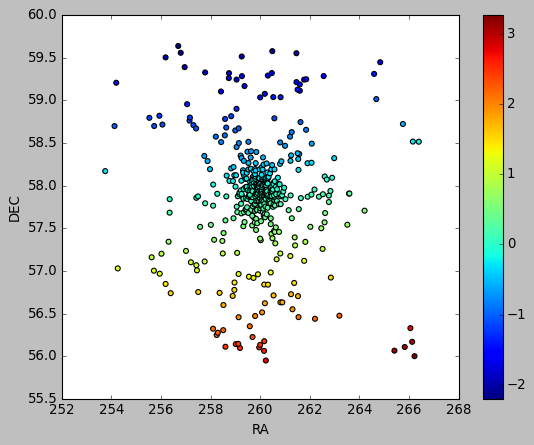

In [158]:
ra0 = ra0
dec0 = dec0
dist = 75.8
#dist = 100
#pmra0 = 0.045
pmra0 = 0.025
pmdec0 = -0.21
vlos0 = -291.12 #dwarftable[dwarftable['key']=='ursa_minor_1']['vlos_systemic'][0]
prob =0
c = 4.74047
vel_pmra0, vel_pmdec0 = pmra0 * c * dist, pmdec0 * c * dist
a = np.pi/180.
ca = np.cos(ra0*a)
cd = np.cos(dec0*a)
sa = np.sin(ra0*a)
sd = np.sin(dec0*a)
vx = vlos0 * cd * sa + vel_pmra0* cd * ca -  vel_pmdec0 * sd*sa
vy = -vlos0 * cd * ca + vel_pmdec0 * sd * ca +  vel_pmra0 * cd*sa
vz = vlos0 *sd + vel_pmdec0 *cd
dwarf_df['vlos_correct'] = np.zeros(len(dwarf_df), dtype=float)
deltax=dwarf_df['TARGET_RA_1']
deltay=dwarf_df['TARGET_DEC_1']
bx = np.cos(deltay*a)*np.sin(deltax*a)
by = -np.cos(deltay*a)*np.cos(deltax*a)
bz = np.sin(dwarf_df['TARGET_DEC_1']*a)
dwarf_df['delta_vlos_correct'] = bx*vx + vy*by + bz*vz - vlos0 
dwarf_df['vlos_correct'] = dwarf_df['delta_vlos_correct'] + dwarf_df['VGSR']

plt.scatter(dwarf_df['TARGET_RA_1'], dwarf_df['TARGET_DEC_1'], c=dwarf_df['delta_vlos_correct'], marker='o')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.colorbar()


In [159]:
#gaussian fitting 
import scipy.optimize as optim





In [160]:
def gauss(x,  A, x0, sigma):
    return  A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))




In [161]:
def mcmc_rv(nproc,nit,p0_guess,full_like,args=[1,1]):
    nw = 64
    p0 = res['x']
    nit = 2000
    ep0 = np.zeros(len(p0_guess)) + 0.02
    p0s = np.random.multivariate_normal(p0_guess, np.diag(ep0)**2, size=nw)
    
    
    nparams = len(param_labels)
   
    nwalkers = 64
    p0 = p0_guess
    ep0 = np.zeros(len(p0)) + 0.02 # some arbitrary width that's pretty close; scale accordingly to your expectation of the uncertainty
    p0s = np.random.multivariate_normal(p0, np.diag(ep0)**2, size=nwalkers)
## Check to see things are initialized ok
    #lkhds = [full_like(p0s[j]) for j in range(nwalkers)]
    #assert np.all(np.array(lkhds) > -9e9)
    
    from schwimmbad import MultiPool

    nproc = nproc #use 32 cores
    nit = nit



    with MultiPool(nproc) as pool:
        print("Running burnin with {} iterations".format(nit))
        start = time.time()
        es = emcee.EnsembleSampler(nw, len(p0_guess), full_like, args=args,pool=pool)
        PP = es.run_mcmc(p0s, nit, rstate0=get_rstate())
        print("Took {:.1f} seconds".format(time.time()-start))

        print(f"Now running the actual thing")
        es.reset()
        start = time.time()
        es.run_mcmc(PP.coords, nit, rstate0=get_rstate())
        print("Took {:.1f} seconds".format(time.time()-start))

    
    outputs = es.flatchain
    return outputs
    

In [162]:
def process_chain_rv(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    meds = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error: # just for simplicity, assuming no asymmetry
        err = (ep-em)/2
        return meds,err
    else:
        return meds,ep,em
    


In [163]:
def like_rv(thetarv,vdata,verr):
    c,w=thetarv
   
    x=vdata
    rverr=verr
    likelog = stats.norm.logpdf(x, loc=c, scale=np.sqrt((rverr)**2 + (w)**2))
    return  likelog.sum()

In [164]:
def ellipse_bin_rv(xdata,ydata,vel,theta0=89*0.0174533,r0=10/60,e=0.31,number=2,ra0=ra0,dec0=dec0,prob=1,proba=0.):
    '''
    function for using ellipse bins to measure the number of stars in each bin
    :param xdata,ydata: ra and dec data
    :param theta0: position angle
    :param r0: half light radius
    :param e float: ellipticity 
    :param number: number of ellipse to be used
    :param ra0,dec0: galaxies center
    :param proba:counting probability > proba stars  

    :return: ellipses plotting and binning data (tot,prob,ra,dec,dis,probave)

    '''
    plt.figure(figsize=(10,6))
    fig, ax = plt.subplots(figsize=(10,6))
    err = []
    r=r0
    e=e
    theta0=theta0
    tot= [] 

    ra=[]
    dec=[]
    dis=[]
    probave=[]
    logg = []
    distot = []
    dis2=[]
    den=[]
    veldis =[]
    #rtot = [0.2,0.5,1.0,1.5,2,2.5,3.,3.5,4,4,5.5,6.5,8.0]
    rtot = [0.00001,0.4,0.75,1.1,1.5,1.8,2.3,3.0,5.0]
    

    for ii in range(len(rtot)-1):
        
    
    
        
        b=r*rtot[ii]*np.sqrt(1-e)
        a=r*rtot[ii]/np.sqrt(1-e)
        b2=r*rtot[ii+1]*np.sqrt(1-e)
        a2=r*rtot[ii+1]/np.sqrt(1-e)
#radius = 42/60
#radius2 = 5*42/60
# Set the center coordinates of the circle
        center = (ra0, dec0)

# Generate an array of angles from 0 to 2*pi
        theta = np.linspace(0, 2 * np.pi, 100)

# Calculate the x and y coordinates of the points on the circumference of the circle
        xt =   a * np.cos(theta)
        yt =  b* np.sin(theta)
        
        #xd=np.cos(yt)*np.sin((xt-ra0)*0.0174533)/0.0174533
        #yd=(np.sin(yt)*np.cos(dec0*0.0174533)-np.cos(yt)*np.sin(dec0*0.0174533)*np.cos((xt-ra0)*0.0174533))/0.0174533
        #xd1=xdata-center[0]
        #yd1=ydata-center[1]
        #xdl=xdata-center[0]
        #ydl=ydata-center[1]
        #x1=xdl
        #y1=ydl
        #x1= xd1*np.sin(theta0)- yd1*np.cos(theta0)

        #y1= xd1*np.cos(theta0)+ yd1*np.sin(theta0)
        #x1= xd1*np.cos(theta0)- yd1*np.sin(theta0)

        #y1= xd1*np.sin(theta0)+ yd1*np.cos(theta0)
        
        
        x1=np.cos(ydata*0.0174533)*np.sin((xdata-ra0)*0.0174533)/0.0174533
        y1=(np.sin(ydata*0.0174533)*np.cos(dec0*0.0174533)-np.cos(ydata*0.0174533)*np.sin(dec0*0.0174533)*np.cos((xdata-ra0)*0.0174533))/0.0174533
        cut1 = (x1**2/a**2+y1**2/b**2)>1
        cut2 = (x1**2/a2**2+y1**2/b2**2)<1
       
        tot.append(len(x1[(cut1)&(cut2)][prob[(cut1)&(cut2)]>proba]))
        err.append(np.sqrt(len(x1[(cut1)&(cut2)][prob[(cut1)&(cut2)]>proba]))/(np.pi*a2*b2-(np.pi*a*b)))


        #dis.append(2/3*((r*rtot[ii+1])**3-(r*rtot[ii])**3)/((r*rtot[ii+1])**2-(r*rtot[ii])**2))
        dis.append(np.sqrt(((r*rtot[ii+1])**2+(r*rtot[ii])**2)/2))
        #dis.append(np.sqrt(((r*rtot[ii+1])**2-(r*rtot[ii])**2)/2))
        #prob.append(sub[(cut1)&(cut2)])
        print (len(x1[(cut1)&(cut2)][prob[(cut1)&(cut2)]>proba]))
        vdata=vel['vlos_correct'][(cut1)&(cut2)][prob[(cut1)&(cut2)]>proba]
        verr = vel['VRAD_ERR'][(cut1)&(cut2)][prob[(cut1)&(cut2)]>proba]
 
     
        guess_rv = [-94,11]
        #optfuncrv = lambda thetarv: like_rv(thetarv,vdata,verr)
        #timeit optfuncrv(guess_rv)
        test = mcmc_rv(60,2000,guess_rv,like_rv,args=[vdata,verr])
        plt.hist(vdata,bins=5)
        plt.show()
        meds, errs = process_chain_rv(test)
        ra.append(xdata[(cut1)&(cut2)])
        dec.append(ydata[(cut1)&(cut2)])
        
        veldis.append([meds[1],errs[1]])
        #veldis.append([popt[2],np.sqrt(np.diagonal(covariance))[2]])
        
      
        #print (vel[(cut1)&(cut2)])
        
        
        
        

# Plot the circle
        #ax.plot(xt, yt,label = str(ii)+' r$_{h}$',c='k')
        #plt.scatter(x1[(cut1)&(cut2)][prob[(cut1)&(cut2)]>proba],y1[(cut1)&(cut2)][prob[(cut1)&(cut2)]>proba],s=6)
        #cbar=plt.colorbar()
        #cbar.set_label('Iron-Pace&LI Probability')
        #plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
#plt.ylim(21, 16)
        #plt.xlim(258,262)
        #plt.ylabel('DEC')
        #plt.xlabel('RA')
        #cbar=plt.colorbar()
   # cbar.set_label('Iron Probability')   
    return tot,ra,dec,dis,den,err,dis2,veldis




# Set the aspect ratio of the plot to 'equal' to make the circle appear circular
#ax.set_aspect('equal')

# Set the radius of the circle to be the half light radiu






12
Running burnin with 2000 iterations
Took 19.4 seconds
Now running the actual thing
Took 18.5 seconds


<Figure size 800x480 with 0 Axes>

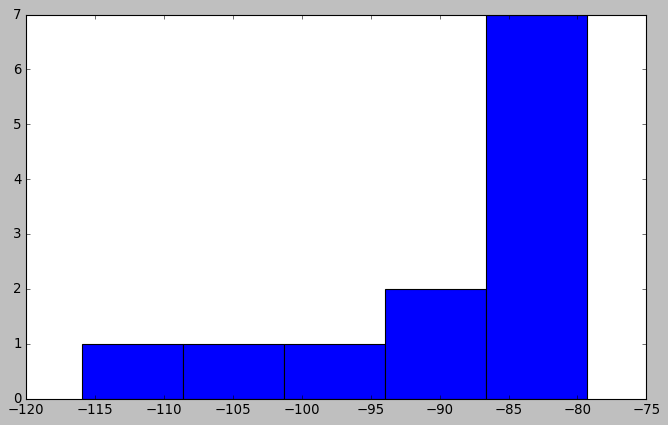

29
Running burnin with 2000 iterations
Took 18.1 seconds
Now running the actual thing
Took 18.2 seconds


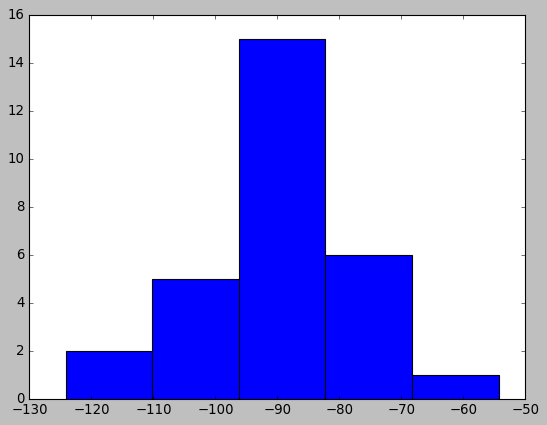

28
Running burnin with 2000 iterations
Took 16.1 seconds
Now running the actual thing
Took 15.0 seconds


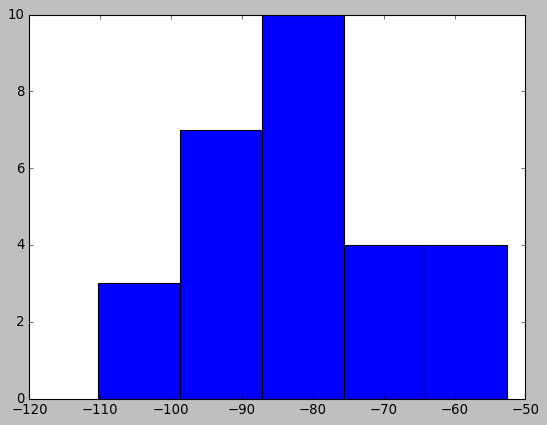

43
Running burnin with 2000 iterations
Took 15.5 seconds
Now running the actual thing
Took 14.9 seconds


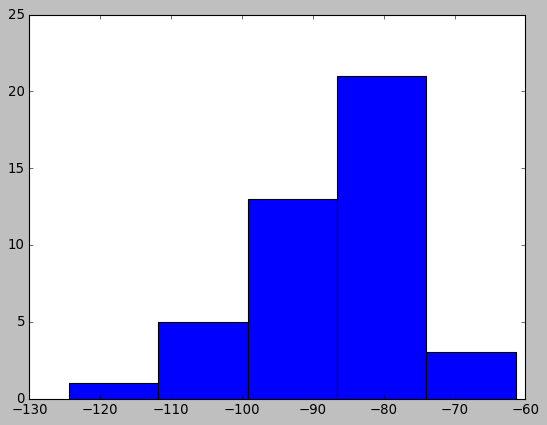

22
Running burnin with 2000 iterations
Took 16.2 seconds
Now running the actual thing
Took 16.9 seconds


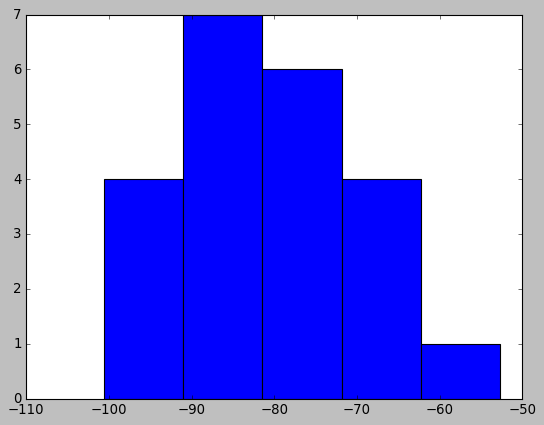

36
Running burnin with 2000 iterations
Took 17.0 seconds
Now running the actual thing
Took 20.7 seconds


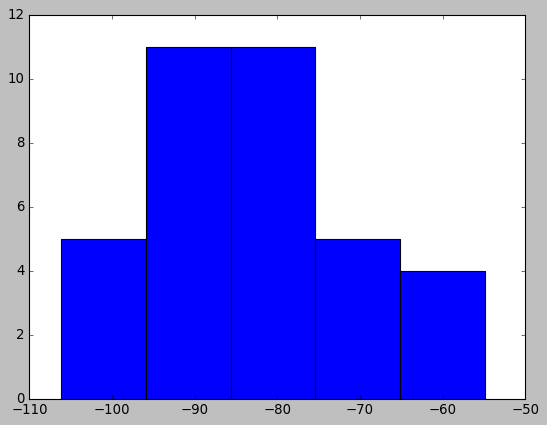

26
Running burnin with 2000 iterations
Took 18.6 seconds
Now running the actual thing
Took 18.2 seconds


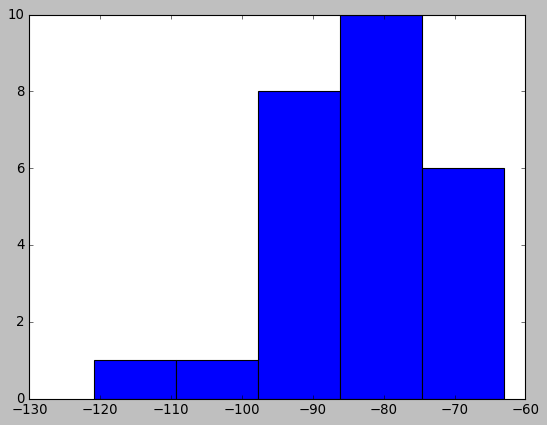

25
Running burnin with 2000 iterations
Took 17.0 seconds
Now running the actual thing
Took 19.5 seconds


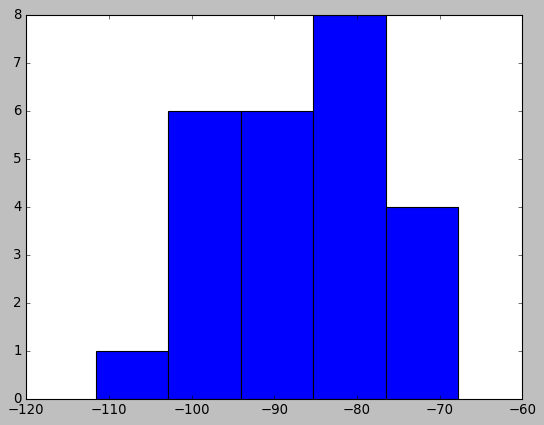

In [165]:
tot,ra,dec,dis,den,err,dis2,veldis2=ellipse_bin_rv(dwarf_df['TARGET_RA_1'],dwarf_df['TARGET_DEC_1'],dwarf_df,theta0=89*0.0174533,r0=10/60,e=0.31,number=10,ra0=ra0,dec0=dec0,prob=np.concatenate(testp),proba=0.75)


         
    

(array([  6.,   7.,   7.,  13.,  69., 178.,  47.,  33.,  38.,  24.]),
 array([-449.82288698, -419.95981473, -390.09674248, -360.23367024,
        -330.37059799, -300.50752575, -270.6444535 , -240.78138126,
        -210.91830901, -181.05523676, -151.19216452]),
 <BarContainer object of 10 artists>)

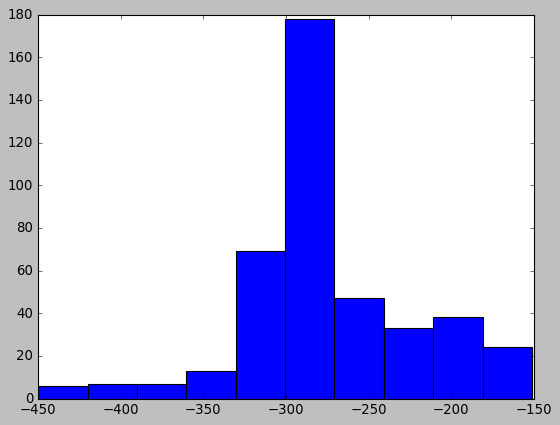

In [166]:
plt.hist(dwarf_df['VRAD'])

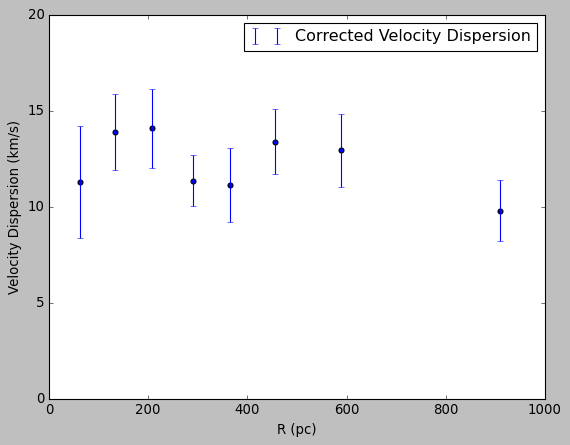

In [181]:
#plt.plot(np.array(r[:5])*60,vral)
vralcor = veldis2
#vral = veldis2
plt.scatter(np.array(dis)*np.pi/180*75.8*1000,np.array(vralcor)[:,0])
plt.errorbar(np.array(dis)*np.pi/180*75.8*1000,np.array(vralcor)[:,0],yerr= np.array(vralcor)[:,1],linestyle = 'none',label='Corrected Velocity Dispersion')
plt.ylim(0,20)
plt.xlabel('R (pc)')
plt.ylabel('Velocity Dispersion (km/s)')
plt.legend()
plt.savefig('velocitydisp_vcorvgsrrverr_0.5_8bins.pdf')


In [174]:
r2=43/60
e=0.31
a2=r2/np.sqrt(1-e)
b2= r2*np.sqrt(1-e)
probb=0.75
xc=np.cos(datacut['TARGET_DEC_1'][np.concatenate(testp)>probb]*0.0174533)*np.sin((datacut['TARGET_RA_1'][np.concatenate(testp)>probb]-ra0)*0.0174533)
yc=np.sin(datacut['TARGET_DEC_1'][np.concatenate(testp)>probb]*0.0174533)*np.cos(dec0*0.0174533)-np.cos(datacut['TARGET_DEC_1'][np.concatenate(testp)>probb]*0.0174533)*np.sin(dec0*0.0174533)*np.cos((datacut['TARGET_RA_1'][np.concatenate(testp)>probb]-ra0)*0.0174533)
#Rxp2= x2*np.cos(theta0)-y2*np.sin(theta0)
x2=xc/0.0174533
y2=yc/0.0174533
cut1 = (x2**2/a2**2+y2**2/b2**2)>1

dataout = datacut[np.concatenate(testp)>probb][cut1]


In [175]:
np.concatenate(testp)[np.concatenate(testp)>probb][cut1]



array([0.93706624, 0.99880751, 0.92120697, 0.82339171, 0.9998644 ,
       0.9999196 , 0.98500358, 0.82553688, 0.99143039])

In [176]:
dataout['REF_ID_2']

<Column name='REF_ID_2' dtype='int64' length=9>
                  0
1432893659376784000
                  0
1433842224379559296
1434492516786370176
1433949770359264768
1433996705761927168
                  0
1433252164591733504

Text(0.5, 0, 'RA Projected [deg]')

<Figure size 1200x800 with 0 Axes>

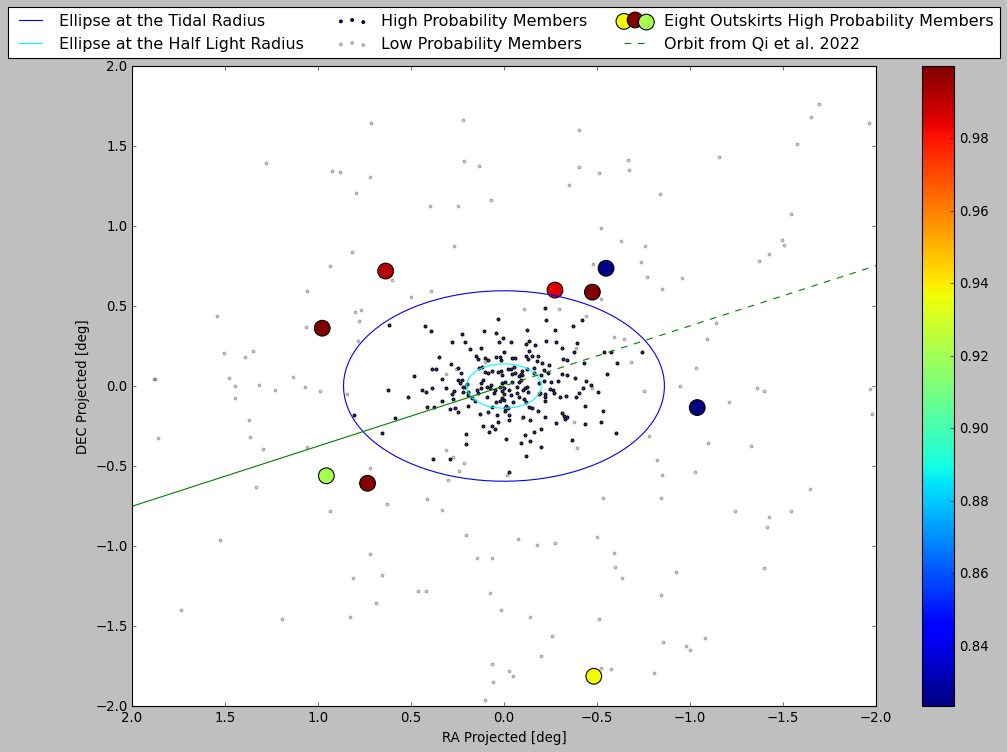

In [177]:
#plotting ra versus dec with Iron-Pace&Li 2022 prbabilities with the tidal radius of Draco

plt.figure(figsize=(15,10))
fig, ax = plt.subplots(figsize=(15,10))

# Set the aspect ratio of the plot to 'equal' to make the circle appear circular
#ax.set_aspect('equal')

# Set the radius of the circle to be the half light radius
r=10/60
e=0.31
theta0=89*0.0174533
b=r*np.sqrt(1-e)
a=r/np.sqrt(1-e)

r2=43/60
a2=r2/np.sqrt(1-e)
b2= r2*np.sqrt(1-e)
#radius = 42/60
#radius2 = 5*42/60
# Set the center coordinates of the circle
center = (ra0, dec0)

# Generate an array of angles from 0 to 2*pi
theta = np.linspace(0, 2 * np.pi, 100)

# Calculate the x and y coordinates of the points on the circumference of the circle
x =   a * np.cos(theta)
y = b* np.sin(theta)
#x =  center[0] + a * np.cos(theta)
#y = center[1]+b* np.sin(theta)

xd1=datacut['TARGET_RA_1']-center[0]
yd1=datacut['TARGET_DEC_1']-center[1]
x1= xd1*np.sin(theta0)- yd1*np.cos(theta0)

y1= xd1*np.cos(theta0)+ yd1*np.sin(theta0)
    

x2 =  a2 * np.cos(theta)
y2 = b2 * np.sin(theta)
#yt=y2*0.0174533
#xt=x2
#xd=np.cos(yt)*np.sin((xt-ra0)*0.0174533)/0.0174533
#yd=(np.sin(yt)*np.cos(dec0*0.0174533)-np.cos(yt)*np.sin(dec0*0.0174533)*np.cos((xt-ra0)*0.0174533))/0.0174533
# Plot the circle
#Rx= xd*np.cos(theta0)-yd*np.sin(theta0)
#Ry = xd*np.sin(theta0)+yd*np.cos(theta0)
#ax.plot(x, y,label = r'$r=r_{h}$',c='r')
ax.plot(x2, y2,label = 'Ellipse at the Tidal Radius',c='b')
ax.plot(x, y,label = 'Ellipse at the Half Light Radius',c='cyan')

proba=0.75

#plt.scatter(df['ra'][df['mem_fixed_complete_ep']>0.75],df['dec'][df['mem_fixed_complete_ep']>0.75],s=1)
#plt.scatter((x1+center[0])[np.concatenate(testp)>0.65],(y1+center[1])[np.concatenate(testp)>0.65],s=6,c='k',label= 'High Probability Members')
#plt.scatter((x1+center[0])[np.concatenate(testp)<0.6],(y1+center[1])[np.concatenate(testp)<0.6],s=6,c='grey',alpha=0.3,label = 'Low Probability Members')
x=np.cos(datacut['TARGET_DEC_1'][np.concatenate(testp)>proba]*0.0174533)*np.sin((datacut['TARGET_RA_1'][np.concatenate(testp)>proba]-ra0)*0.0174533)
y=np.sin(datacut['TARGET_DEC_1'][np.concatenate(testp)>proba]*0.0174533)*np.cos(dec0*0.0174533)-np.cos(datacut['TARGET_DEC_1'][np.concatenate(testp)>proba]*0.0174533)*np.sin(dec0*0.0174533)*np.cos((datacut['TARGET_RA_1'][np.concatenate(testp)>proba]-ra0)*0.0174533)
#Rxp= x*np.cos(theta0)-y*np.sin(theta0)
#Ryp = x*np.sin(theta0)+y*np.cos(theta0)

plt.scatter(x/0.0174533,y/0.0174533,s=6,label='High Probability Members')
proba= 0.0
x2=np.cos(datacut['TARGET_DEC_1'][np.concatenate(testp)>proba]*0.0174533)*np.sin((datacut['TARGET_RA_1'][np.concatenate(testp)>proba]-ra0)*0.0174533)
y2=np.sin(datacut['TARGET_DEC_1'][np.concatenate(testp)>proba]*0.0174533)*np.cos(dec0*0.0174533)-np.cos(datacut['TARGET_DEC_1'][np.concatenate(testp)>proba]*0.0174533)*np.sin(dec0*0.0174533)*np.cos((datacut['TARGET_RA_1'][np.concatenate(testp)>proba]-ra0)*0.0174533)
#Rxp2= x2*np.cos(theta0)-y2*np.sin(theta0)
#Ryp2 = x2*np.sin(theta0)+y2*np.cos(theta0)
x3=np.cos(dataout['TARGET_DEC_1']*0.0174533)*np.sin((dataout['TARGET_RA_1']-ra0)*0.0174533)
y3=np.sin(dataout['TARGET_DEC_1']*0.0174533)*np.cos(dec0*0.0174533)-np.cos(dataout['TARGET_DEC_1']*0.0174533)*np.sin(dec0*0.0174533)*np.cos((dataout['TARGET_RA_1']-ra0)*0.0174533)
#Rxp2= x2*np.cos(theta0)-y2*np.sin(theta0)
plt.scatter(x2/0.0174533,y2/0.0174533,s=6,alpha=0.3,c='grey',label='Low Probability Members')
plt.scatter(x3/0.0174533,y3/0.0174533,s=200,c=np.concatenate(testp)[np.concatenate(testp)>probb][cut1],label='Eight Outskirts High Probability Members')
plt.plot([3.20833,0],[-1.20618556,0],'-',c='g')
plt.plot([-3.20833,0],[1.20618556,0],'--',c='g',label='Orbit from Qi et al. 2022')
cbar=plt.colorbar()
plt.style.use('classic')
#cbar.set_label('Probability')





# Define the arrow properties
arrow_properties = dict(
    facecolor='orange',
    edgecolor='orange',
    linewidth=5,      # Adjust the arrow width
    head_width=0.05,  # Adjust the arrow head width
)

# Draw the arrow
#plt.arrow(ra0, dec0, 0.03/np.cos(dec0*0.0174533), -0.21, **arrow_properties)




# Draw your plot here...

# Turn off the grid
ax.grid(False)
plt.xlim(2,-2)
plt.ylim(-2,2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.), ncol=3)
#plt.ylim(57, 59)
#plt.xlim(258,262)
plt.ylabel('DEC Projected [deg]')
plt.xlabel('RA Projected [deg]')
#plt.savefig('spatial_gsr_test.pdf')


In [178]:
len(datasum[0])

422

In [179]:
def plot_1d_distrs_high(theta,datasum,p1min=-600, p1max=350, p2min=-4, p2max=0.,key="vhel"):
    '''
    function for plotting the likelihood distribution of two quantities p1 versus p2 for the gal/bg 
    :param theta: likelihood parameters (prior/posterior) 
    :param datasum: data table
    :param p1min,p1max float: p1 range
    :param p2min,p2max float: p2 range
    :param vmin,vmax: radial velocity range 
    :param key: key="vhel" for plotting vrad versus Feh / key="pmra" for plotting pmra versus pmdec 

    :return: plotting 

    '''
    #colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    model_output = project_model(theta,p1min, p1max, p2min, p2max,key=key)
    fig, axes = plt.subplots(1,2,figsize=(18,8))
    if key == "vhel":
        ax = axes[0]
        ax.hist(datasum[0], density=False, color='grey', bins=100,label='All Sample')
        ax.hist(datasum[0][np.concatenate(testp)>probb], density=False, color='red', bins=100,label = 'High Probability Sample')
        #xp, p0, p1 = model_output[0:3]
        #ax.plot(xp, p0 + p1, 'k-', label="Total", lw=3)
        #ax.plot(xp, p1, ':', color=colors[2], label="bg1", lw=3)
        #ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
        ax.set(xlabel="Vgsr (km/s)", ylabel="Prob. Density")
        ax.legend(fontsize='small')

        ax = axes[1]
        ax.hist(datasum[2], density=False, color='grey', bins='auto',label = 'All Sample')
        ax.hist(datasum[2][np.concatenate(testp)>probb], density=False, color='red', bins='auto',alpha=0.3,label = 'High Probability Sample')
        #xp, p0, p1 = model_output[3:6]
        #ax.plot(xp, p0 + p1, 'k-', lw=3)
        #ax.plot(xp, p1, ':', color=colors[2], label="bg1", lw=3)
        #ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
        ax.set(xlabel="[Fe/H] (dex)", ylabel="Prob. Density")
        plt.show()
   
    return fig

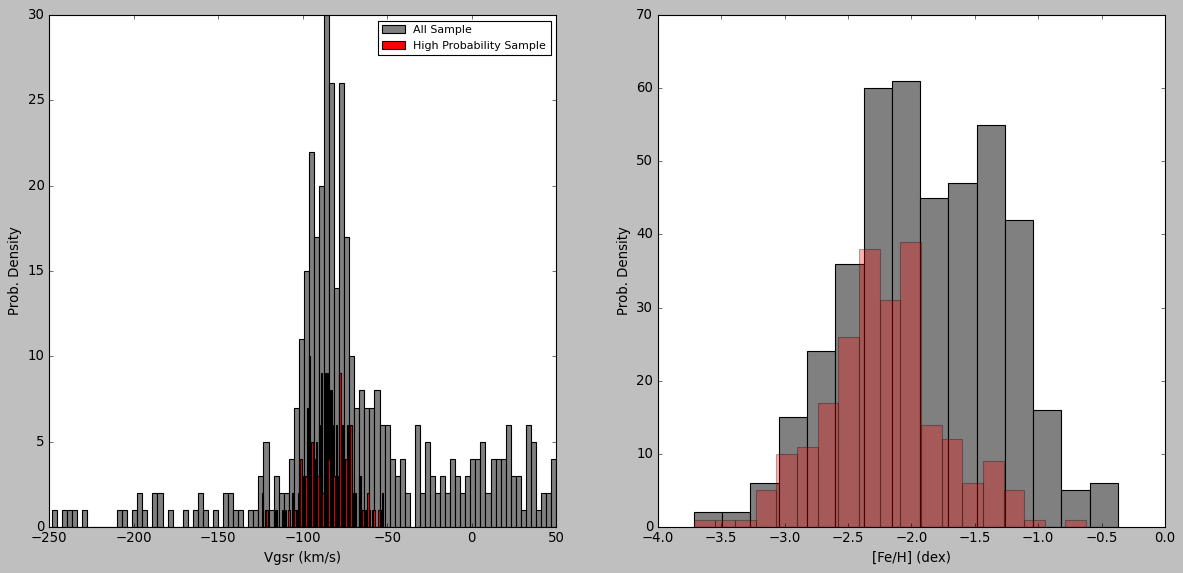

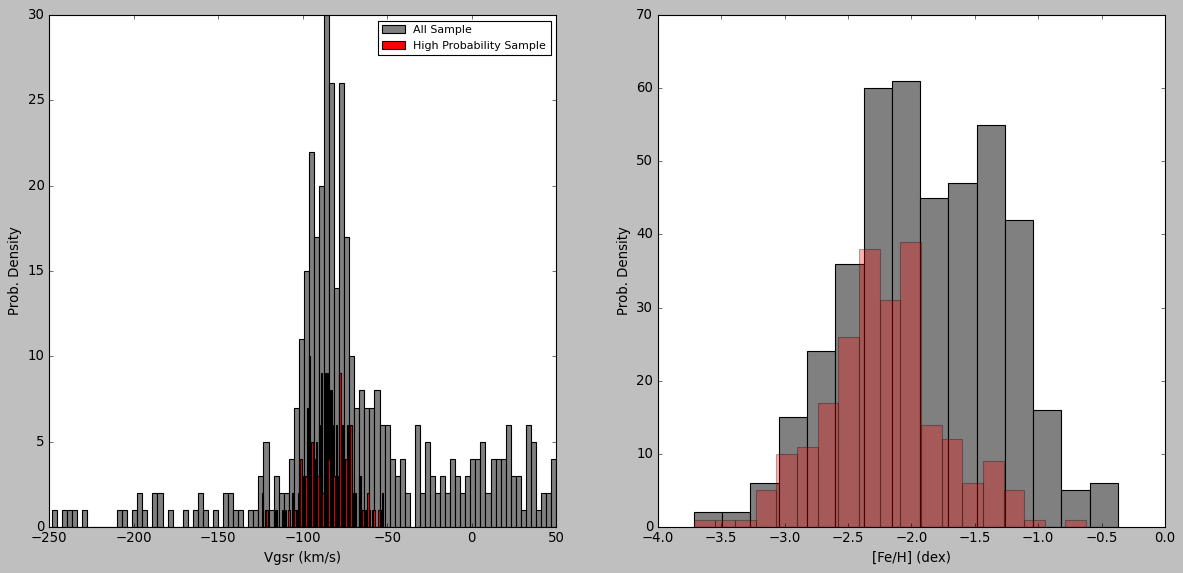

In [180]:
plot_1d_distrs_high(theta,datasum,p1min=-600, p1max=350, p2min=-4, p2max=0.,key="vhel")

In [147]:
np.concatenate(testp)[np.isin(datacut['REF_ID_1'],dataout['REF_ID_1'])]

array([9.37325926e-01, 2.79310557e-16, 1.56746751e-14, 4.20948109e-03,
       2.84776851e-02, 2.39079425e-17, 1.07228912e-18, 1.07511171e-10,
       5.87090573e-01, 5.77844257e-01, 1.19682796e-01, 1.73758284e-32,
       1.96094646e-04, 5.52992714e-02, 9.98806046e-01, 9.21516758e-01,
       9.99552692e-01, 2.64750120e-01, 7.66290914e-01, 8.61360193e-21,
       3.97942144e-06, 8.23707988e-01, 2.91833224e-05, 9.84388843e-01,
       9.83652976e-01, 9.95249701e-01, 9.98882134e-01, 9.99889394e-01,
       9.99721324e-01, 9.97675047e-01, 9.78225633e-01, 9.99473375e-01,
       9.97851792e-01, 9.97137732e-01, 9.00597618e-01, 9.86919165e-01,
       9.99164732e-01, 9.99720554e-01, 9.98443121e-01, 9.99896519e-01,
       9.96781370e-01, 9.92489825e-01, 9.99823524e-01, 9.97677785e-01,
       3.59041406e-19, 9.99745886e-01, 9.98537468e-01, 9.98873619e-01,
       9.99486043e-01, 9.99875891e-01, 9.92017169e-01, 9.29390230e-01,
       9.99864411e-01, 9.99919418e-01, 9.85035639e-01, 4.76956684e-07,
      

In [148]:
dataout['REF_ID_2']

<Column name='REF_ID_2' dtype='int64' length=11>
                  0
                  0
1420827202160955776
1432893659376784000
                  0
1433842224379559296
1434492516786370176
1433949770359264768
1433996705761927168
                  0
1433252164591733504

Text(0.5, 0, 'gmag0-rmag0')

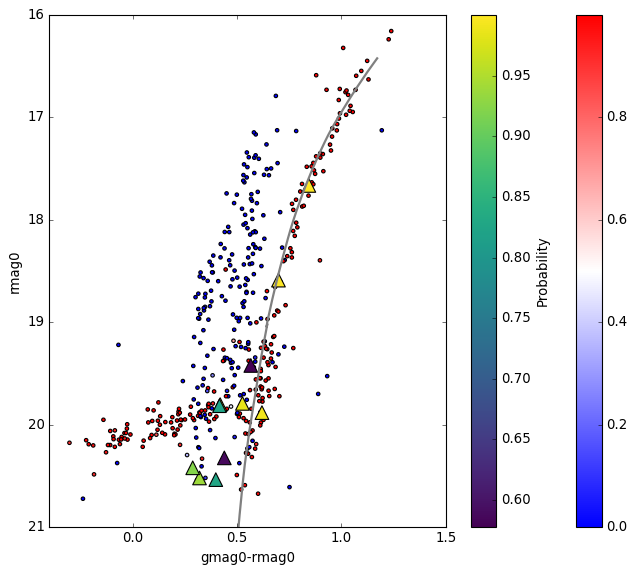

In [149]:
#CMD diagram with probabiltiy 
plt.style.use('classic')
plt.figure(figsize=(10,8),facecolor='white')
plt.grid(color='white')
plt.plot(iso_file['DECam_g']-iso_file['DECam_r'],iso_file['DECam_r']+dm,c='grey',lw=2,label='Isochrone')
#norm = colors.Normalize(vmin=0, vmax=1) 
#combined_colors = np.append(np.concatenate(testp), [0.99815984, 0.55174294, 0.99967203, 0.99981849, 0.92997065, 0.96598971])


#plt.scatter(dataout['gmag0']-dataout['rmag0'],dataout['rmag0'],s=150,c=np.concatenate(testp)[np.isin(datacut['REF_ID_1'],dataout['REF_ID_1'])],marker='^',label='Outskirts High Probability Members')
plt.scatter(datacut['gmag0']-datacut['rmag0'],datacut['rmag0'],s=10,c=np.concatenate(testp),cmap='bwr',label='EDR Sample')

cbar=plt.colorbar()
plt.scatter(dataout['gmag0']-dataout['rmag0'],dataout['rmag0'],s=150,c=np.concatenate(testp)[np.concatenate(testp)>probb][cut1],marker='^',cmap='viridis',label='Outskirts High Probability Members')
cbar=plt.colorbar()
plt.grid(False)
# Customize the background color
plt.rcParams['figure.facecolor'] = 'white'

# Customize the tick labels font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set the title for the colorbar
cbar.set_label('Probability')
plt.ylim(21, 16)
plt.xlim(-0.4,1.5)
plt.ylabel('rmag0')
plt.xlabel('gmag0-rmag0')
#plt.legend(loc=2)
#plt.savefig('prob_gsr.pdf')

In [150]:
def ellipse_bin_pro(xdata,ydata,vel,theta0=89*0.0174533,r0=10/60,e=0.31,number=2,ra0=ra0,dec0=dec0,prob=1,proba=0.):
    '''
    function for using ellipse bins to measure the number of stars in each bin
    :param xdata,ydata: ra and dec data
    :param theta0: position angle
    :param r0: half light radius
    :param e float: ellipticity 
    :param number: number of ellipse to be used
    :param ra0,dec0: galaxies center
    :param proba:counting probability > proba stars  

    :return: ellipses plotting and binning data (tot,prob,ra,dec,dis,probave)

    '''
    plt.figure(figsize=(10,6))
    fig, ax = plt.subplots(figsize=(10,6))
    err = []
    r=r0
    e=e
    theta0=theta0
    tot= [] 

    ra=[]
    dec=[]
    dis=[]
    probave=[]
    logg = []
    distot = []
    dis2=[]
    den=[]
    veldis =[]
    #rtot = [0.2,0.5,1.0,1.5,2,2.5,3.,3.5,4,4,5.5,6.5,8.0]
    rtot = [0.00001,1.0,2,3.,4.5,6,7,8.0,10,12]
    for ii in range(len(rtot)-1):
        
    
    
        
        b=r*rtot[ii]*np.sqrt(1-e)
        a=r*rtot[ii]/np.sqrt(1-e)
        b2=r*rtot[ii+1]*np.sqrt(1-e)
        a2=r*rtot[ii+1]/np.sqrt(1-e)
#radius = 42/60
#radius2 = 5*42/60
# Set the center coordinates of the circle
        center = (ra0, dec0)

# Generate an array of angles from 0 to 2*pi
        theta = np.linspace(0, 2 * np.pi, 100)

# Calculate the x and y coordinates of the points on the circumference of the circle
        xt =   a * np.cos(theta)
        yt =  b* np.sin(theta)
        
        #xd=np.cos(yt)*np.sin((xt-ra0)*0.0174533)/0.0174533
        #yd=(np.sin(yt)*np.cos(dec0*0.0174533)-np.cos(yt)*np.sin(dec0*0.0174533)*np.cos((xt-ra0)*0.0174533))/0.0174533
        #xd1=xdata-center[0]
        #yd1=ydata-center[1]
        #xdl=xdata-center[0]
        #ydl=ydata-center[1]
        #x1=xdl
        #y1=ydl
        #x1= xd1*np.sin(theta0)- yd1*np.cos(theta0)

        #y1= xd1*np.cos(theta0)+ yd1*np.sin(theta0)
        #x1= xd1*np.cos(theta0)- yd1*np.sin(theta0)

        #y1= xd1*np.sin(theta0)+ yd1*np.cos(theta0)
        x1=np.cos(ydata*0.0174533)*np.sin((xdata-ra0)*0.0174533)/0.0174533
        y1=(np.sin(ydata*0.0174533)*np.cos(dec0*0.0174533)-np.cos(ydata*0.0174533)*np.sin(dec0*0.0174533)*np.cos((xdata-ra0)*0.0174533))/0.0174533
        cut1 = (x1**2/a**2+y1**2/b**2)>1
        cut2 = (x1**2/a2**2+y1**2/b2**2)<1
       
        tot.append(len(x1[(cut1)&(cut2)][prob[(cut1)&(cut2)]>proba]))
        err.append(np.sqrt(len(x1[(cut1)&(cut2)][prob[(cut1)&(cut2)]>proba]))/(np.pi*a2*b2-(np.pi*a*b)))
        den.append(len(x1[(cut1)&(cut2)][prob[(cut1)&(cut2)]>proba])/(np.pi*a2*b2-(np.pi*a*b)))
       # gco = np.histogram(vel[(cut1)&(cut2)][prob[(cut1)&(cut2)]>proba],bins=8)
       # popt, covariance = curve_fit(gauss, gco[1][1:], gco[0],p0=[10,-290,2])

        #popt, covariance = curve_fit(gauss, gco[1][1:], gco[0],p0=[10,-290,2])
        #fit_y = gauss(gco[1][1:],*popt)
        #print (popt, np.sqrt(np.diagonal(covariance)))
        #plt.plot(gco[1][1:], gco[0], 'o', label='data')
        #plt.plot(gco[1][1:], fit_y, '-', label='fit')
        #plt.legend()
        #plt.show()
        #logg.append(testiron['LOGG'][np.isin(testiron['VRAD'],datacut['VRAD'])][[(cut1)&(cut2)]>proba])

        #dis.append(2/3*((r*rtot[ii+1])**3-(r*rtot[ii])**3)/((r*rtot[ii+1])**2-(r*rtot[ii])**2))
        dis.append(np.sqrt(((r*rtot[ii+1])**2+(r*rtot[ii])**2)/2))
        #dis.append(np.sqrt(((r*rtot[ii+1])**2-(r*rtot[ii])**2)/2))
        #prob.append(sub[(cut1)&(cut2)])
        print (len(x1[(cut1)&(cut2)][prob[(cut1)&(cut2)]>proba]))
        
        ra.append(xdata[(cut1)&(cut2)])
        dec.append(ydata[(cut1)&(cut2)])
        
        veldis.append(np.std(vel[(cut1)&(cut2)][prob[(cut1)&(cut2)]>proba]))
        #veldis.append([popt[2],np.sqrt(np.diagonal(covariance))[2]])
        
        probave.append(prob)
        dis2.append(r*rtot[ii])
        #print (vel[(cut1)&(cut2)])
        
        
        
        

# Plot the circle
        #ax.plot(xt, yt,label = str(ii)+' r$_{h}$',c='k')
        #plt.scatter(x1[(cut1)&(cut2)][prob[(cut1)&(cut2)]>proba],y1[(cut1)&(cut2)][prob[(cut1)&(cut2)]>proba],s=6)
        #cbar=plt.colorbar()
        #cbar.set_label('Iron-Pace&LI Probability')
        #plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
#plt.ylim(21, 16)
        #plt.xlim(258,262)
        #plt.ylabel('DEC')
        #plt.xlabel('RA')
        #cbar=plt.colorbar()
   # cbar.set_label('Iron Probability')   
    return tot,ra,dec,dis,probave,np.sqrt(x1**2+y1**2),den,err,dis2,veldis




# Set the aspect ratio of the plot to 'equal' to make the circle appear circular
#ax.set_aspect('equal')

# Set the radius of the circle to be the half light radiu






In [151]:
def ellipse_bin_pro_noprob(xdata,ydata,theta0=89*0.0174533,r0=1/60,e=0.31,number=2,ra0=ra0,dec0=dec0):
    '''
    function for using ellipse bins to measure the number of stars in each bin
    :param xdata,ydata: ra and dec data
    :param theta0: position angle
    :param r0: half light radius
    :param e float: ellipticity 
    :param number: number of ellipse to be used
    :param ra0,dec0: galaxies center
    :param proba:counting probability > proba stars  

    :return: ellipses plotting and binning data (tot,prob,ra,dec,dis,probave)

    '''
    plt.figure(figsize=(10,6))
    fig, ax = plt.subplots(figsize=(10,6))
    dis2=[]
    err = []
    r=r0
    e=e
    theta0=theta0
    tot= [] 

    ra=[]
    dec=[]
    dis=[]
    probave=[]
    logg = []
    distot = []
    den=[]
    veldis=[]
    #rtot = [0.2,0.5,1.0,1.5,2,2.5,3.,3.5,4,4,5.5,6.5,8.0]
    rtot = [0.00001,1.0,2,3.,4.5,6,7,8.0,10,12]
    for ii in range(len(rtot)-1):
        
        plt.figure(figsize=(10,6))
        fig, ax = plt.subplots(figsize=(10,6))
    
        
        b=r*rtot[ii]*np.sqrt(1-e)
        a=r*rtot[ii]/np.sqrt(1-e)
        b2=r*rtot[ii+1]*np.sqrt(1-e)
        a2=r*rtot[ii+1]/np.sqrt(1-e)
#radius = 42/60
#radius2 = 5*42/60
# Set the center coordinates of the circle
        center = (ra0, dec0)

# Generate an array of angles from 0 to 2*pi
        theta = np.linspace(0, 2 * np.pi, 100)

# Calculate the x and y coordinates of the points on the circumference of the circle
        xt =   a * np.cos(theta)
        yt =  b* np.sin(theta)
        
        #xd=np.cos(yt)*np.sin((xt-ra0)*0.0174533)/0.0174533
        #yd=(np.sin(yt)*np.cos(dec0*0.0174533)-np.cos(yt)*np.sin(dec0*0.0174533)*np.cos((xt-ra0)*0.0174533))/0.0174533
        #xd1=xdata-center[0]
        #yd1=ydata-center[1]
        #xdl=xdata-center[0]
        #ydl=ydata-center[1]
        #x1=xdl
        #y1=ydl
        #x1= xd1*np.sin(theta0)- yd1*np.cos(theta0)

        #y1= xd1*np.cos(theta0)+ yd1*np.sin(theta0)
        #x1= xd1*np.cos(theta0)- yd1*np.sin(theta0)

        #y1= xd1*np.sin(theta0)+ yd1*np.cos(theta0)
        x1=np.cos(ydata*0.0174533)*np.sin((xdata-ra0)*0.0174533)/0.0174533
        y1=(np.sin(ydata*0.0174533)*np.cos(dec0*0.0174533)-np.cos(ydata*0.0174533)*np.sin(dec0*0.0174533)*np.cos((xdata-ra0)*0.0174533))/0.0174533
        cut1 = (x1**2/a**2+y1**2/b**2)>1
        cut2 = (x1**2/a2**2+y1**2/b2**2)<1
       
        tot.append(len(x1[(cut1)&(cut2)]))
        err.append(np.sqrt(len(x1[(cut1)&(cut2)]))/(np.pi*a2*b2-(np.pi*a*b)))
        den.append(len(x1[(cut1)&(cut2)])/(np.pi*a2*b2-(np.pi*a*b)))
        #logg.append(testiron['LOGG'][np.isin(testiron['VRAD'],datacut['VRAD'])][[(cut1)&(cut2)]>proba])
        
       
        #dis.append(2/3*((r*rtot[ii+1])**3-(r*rtot[ii])**3)/((r*rtot[ii+1])**2-(r*rtot[ii])**2))
        dis.append(np.sqrt(((r*rtot[ii+1])**2+(r*rtot[ii])**2)/2))
        dis2.append(r*rtot[ii])
        #prob.append(sub[(cut1)&(cut2)])
        #print (len(xd1[(cut1)&(cut2)]))
        ra.append(xdata[(cut1)&(cut2)])
        dec.append(ydata[(cut1)&(cut2)])
        probave.append(prob)
        
        
        
        

# Plot the circle
        ax.plot(xt, yt,label = str(ii)+' r$_{h}$',c='k')
        plt.scatter(x1[(cut1)&(cut2)],y1[(cut1)&(cut2)],s=6)
        #cbar=plt.colorbar()
        #cbar.set_label('Iron-Pace&LI Probability')
        #plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
#plt.ylim(21, 16)
        #plt.xlim(258,262)
        plt.ylabel('DEC')
        plt.xlabel('RA')
        #cbar=plt.colorbar()
   # cbar.set_label('Iron Probability')   
    return tot,ra,dec,dis,probave,np.sqrt(xd1**2+yd1**2),den,err,dis2




# Set the aspect ratio of the plot to 'equal' to make the circle appear circular
#ax.set_aspect('equal')

# Set the radius of the circle to be the half light radiu






60
86
50
25
6
2
0
2
0


/home/tingli/.conda/envs/myenv/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tingli/.conda/envs/myenv/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/tingli/.conda/envs/myenv/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 800x480 with 0 Axes>

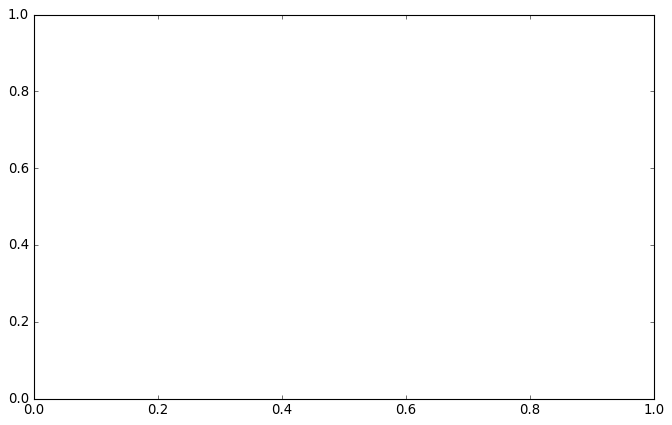

In [152]:
tot,ra,dec,r,probave,distot,dend,draerr,dis2,vral=ellipse_bin_pro(datacut['TARGET_RA_1'],datacut['TARGET_DEC_1'],datacut['VRAD'],theta0=89*0.0174533,r0=10/60,e=0.31,number=10,ra0=ra0,dec0=dec0,prob=np.concatenate(testp),proba=0.5)





In [119]:
vral = [[13.86,2.53],[11.20,0.61],[14.73, 1.75],[11.55, 3.324],[0,0]]
vralcor = [[13.59,2.62],[11.04,0.42],[14.62, 1.73],[10.66, 2.15],[0,0]]

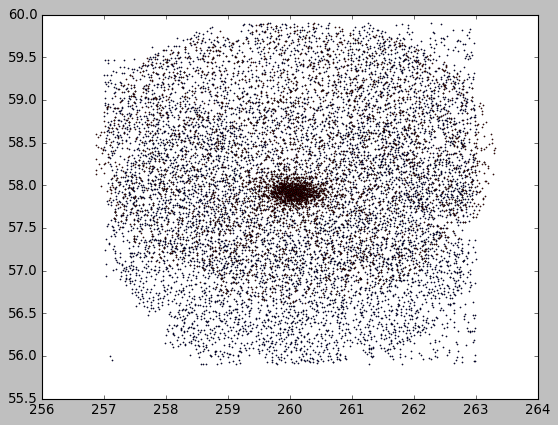

In [125]:
#Ting's file for completeness correction
plt.style.use('classic')
targtab=Table.read('oc_gc_dg_targets.txt',format='ascii')
targra=targtab['col1']
targdec=targtab['col2']
targcoord=SkyCoord(targra*u.degree,targdec*u.degree,frame='icrs')
ra0 = 260.0517
dec0 =  57.9153
draco=SkyCoord(ra0*u.degree, dec0*u.degree,frame='icrs')
targsep=targcoord.separation(draco)
itargd,=np.where(targsep.value<2.)
irad,=np.where((testiron['TARGET_RA_1'] > 257) & (testiron['TARGET_RA_1'] < 263) & (testiron['TARGET_DEC_1'] > 55.9) & (testiron['TARGET_DEC_1'] < 59.9))
plt.plot(testiron['TARGET_RA_1'][irad],testiron['TARGET_DEC_1'][irad],'bo',ms=1)
plt.plot(targra[itargd],targdec[itargd],'ro',ms=1)


In [126]:
len(testiron['TARGET_RA_1'][irad])

8359

In [127]:
xdata=targra[itargd]
ydata=targdec[itargd]

In [128]:
x1=np.cos(ydata*0.0174533)*np.sin((xdata-ra0)*0.0174533)/0.0174533
y1=(np.sin(ydata*0.0174533)*np.cos(dec0*0.0174533)-np.cos(ydata*0.0174533)*np.sin(dec0*0.0174533)*np.cos((xdata-ra0)*0.0174533))/0.0174533
cut1 = (x1**2/a**2+y1**2/b**2)>1

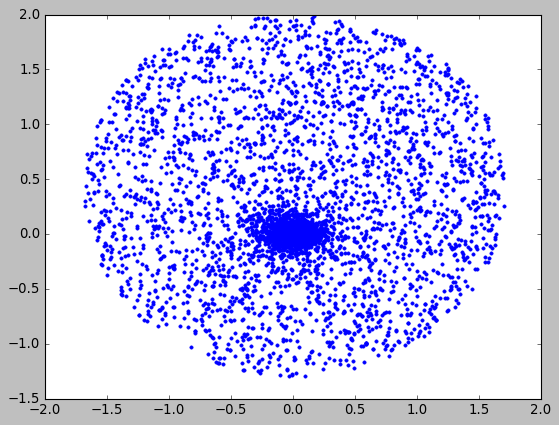

In [129]:
plt.plot(x1,y1,'.')
plt.show()

<Figure size 800x480 with 0 Axes>

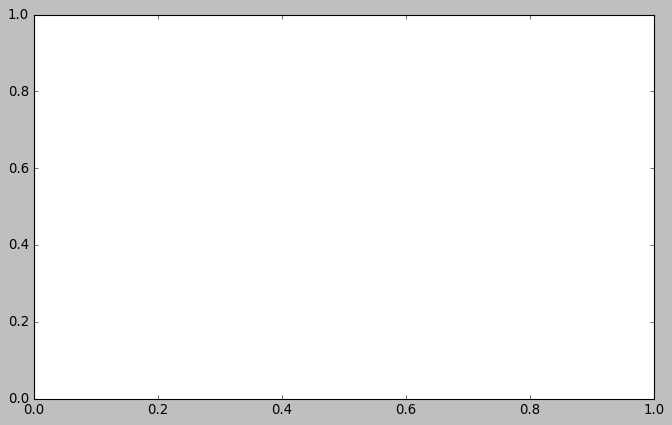

<Figure size 800x480 with 0 Axes>

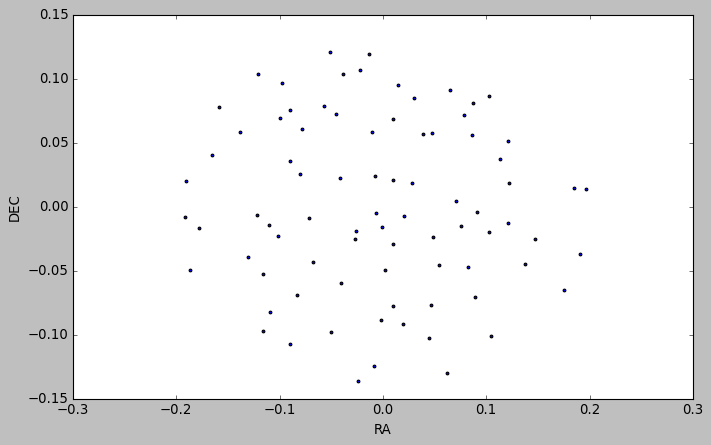

<Figure size 800x480 with 0 Axes>

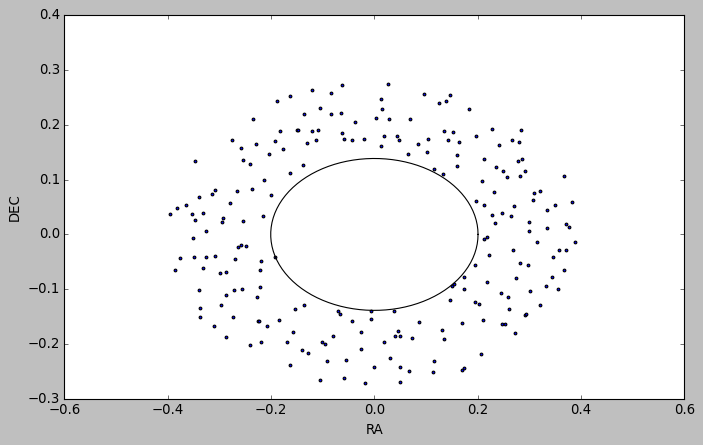

<Figure size 800x480 with 0 Axes>

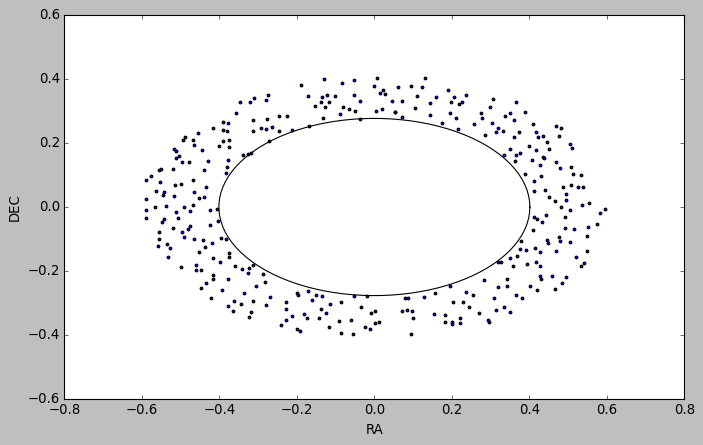

<Figure size 800x480 with 0 Axes>

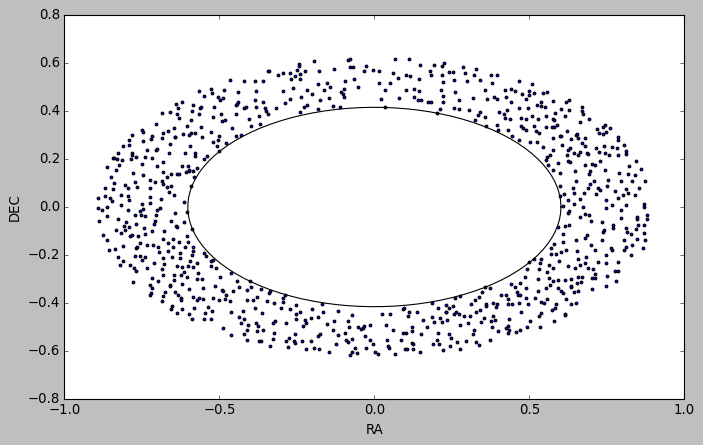

<Figure size 800x480 with 0 Axes>

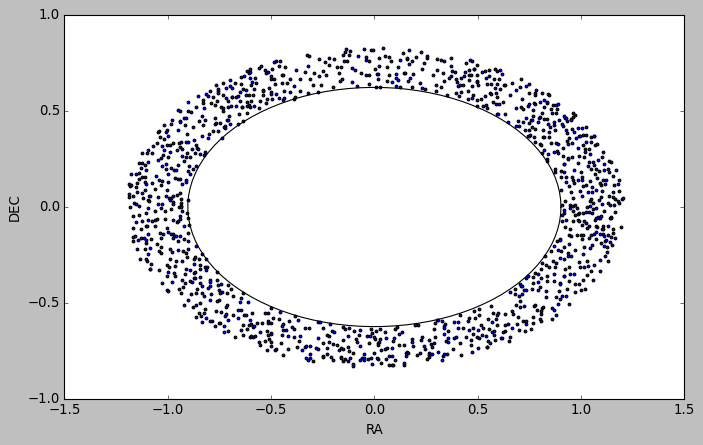

<Figure size 800x480 with 0 Axes>

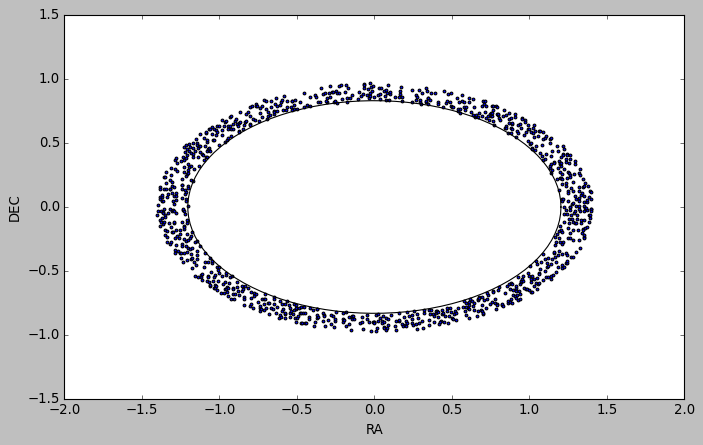

<Figure size 800x480 with 0 Axes>

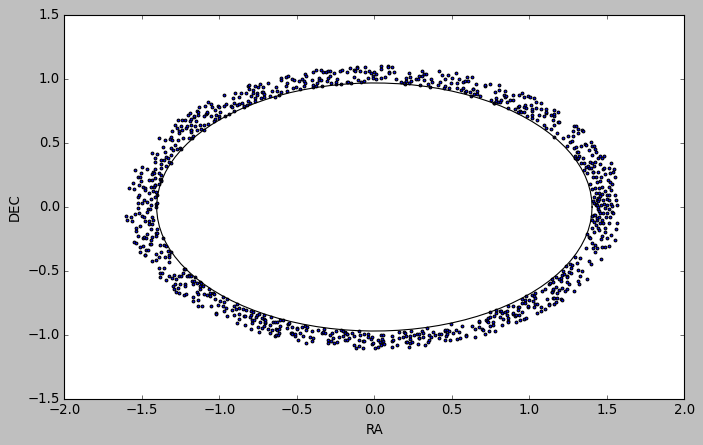

<Figure size 800x480 with 0 Axes>

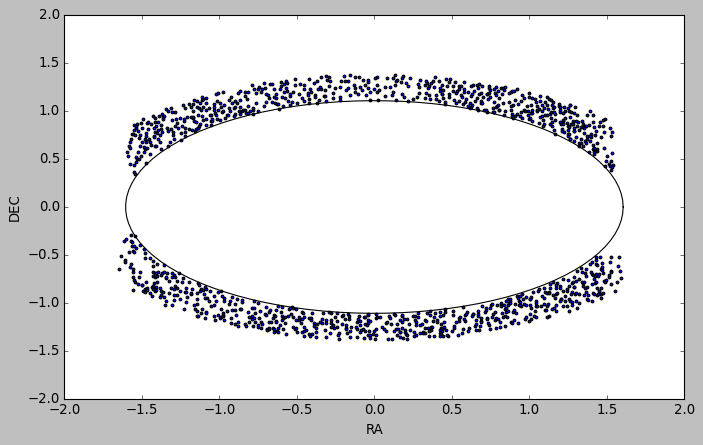

<Figure size 800x480 with 0 Axes>

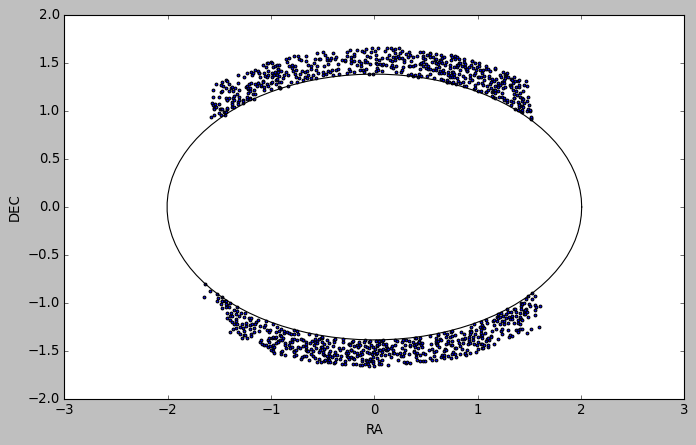

In [130]:
allspectot,allspecxvec,allspecyvec,allspecrad,allspecprobave,allspecdistot,allspecden,allerr,dis2=ellipse_bin_pro_noprob(testiron['TARGET_RA_1'][irad],testiron['TARGET_DEC_1'][irad],theta0=89*0.0174533,r0=10/60,e=0.31,number=10,ra0=ra0,dec0=dec0)
                                                                                                      

In [131]:
mask =(1<<10)+(1<<38)
targiqk = np.where(((testiron['SV1_SCND_TARGET'][iqk] & mask) > 0))[0]

<Figure size 800x480 with 0 Axes>

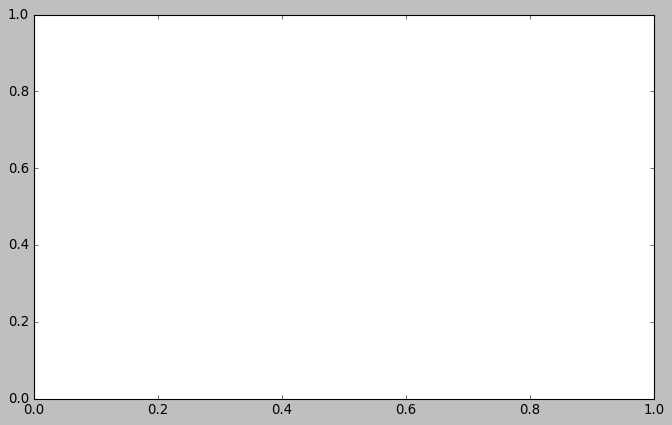

<Figure size 800x480 with 0 Axes>

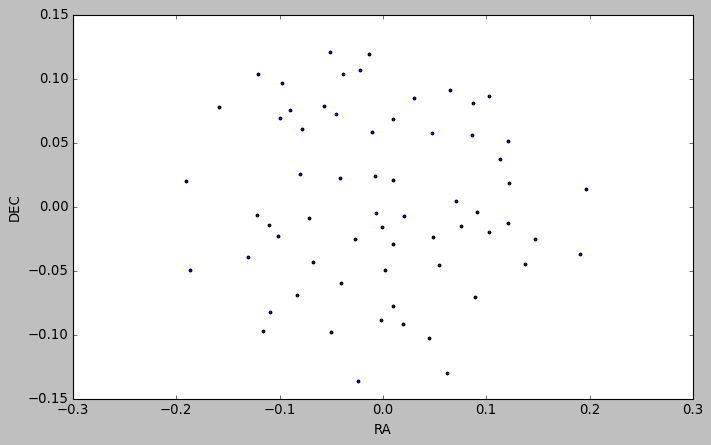

<Figure size 800x480 with 0 Axes>

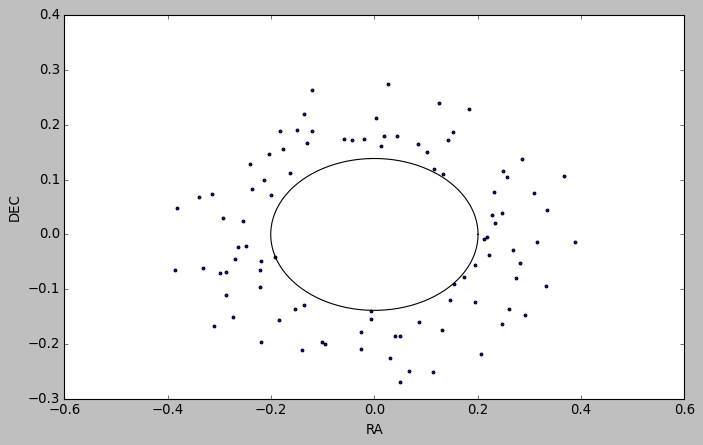

<Figure size 800x480 with 0 Axes>

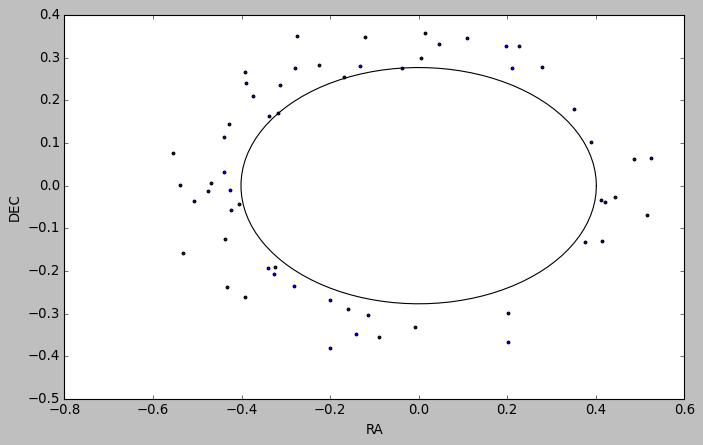

<Figure size 800x480 with 0 Axes>

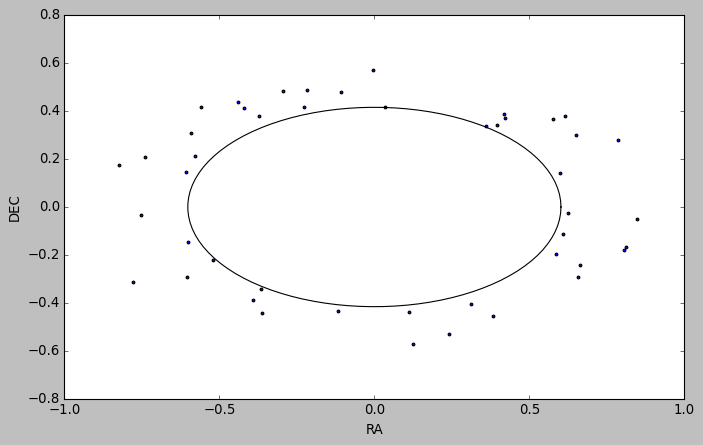

<Figure size 800x480 with 0 Axes>

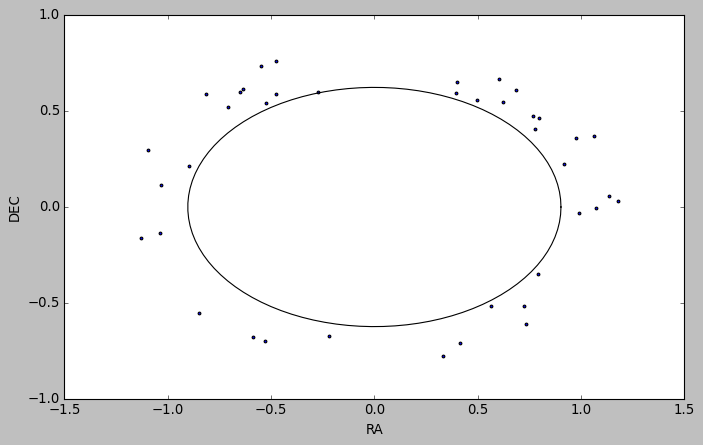

<Figure size 800x480 with 0 Axes>

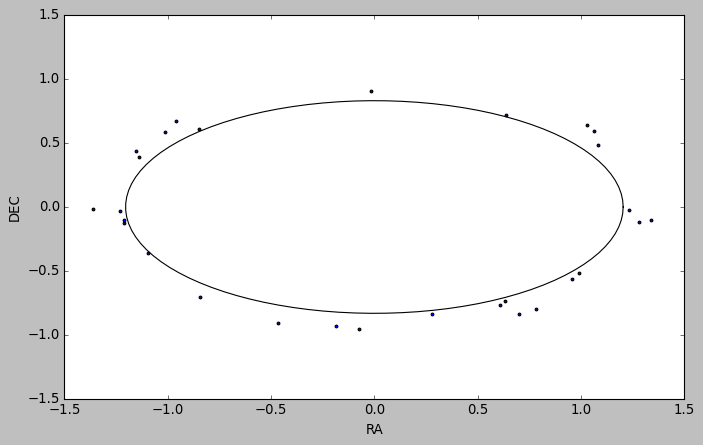

<Figure size 800x480 with 0 Axes>

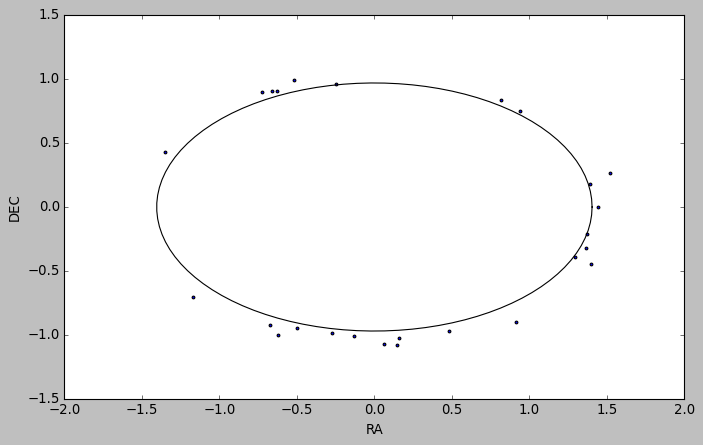

<Figure size 800x480 with 0 Axes>

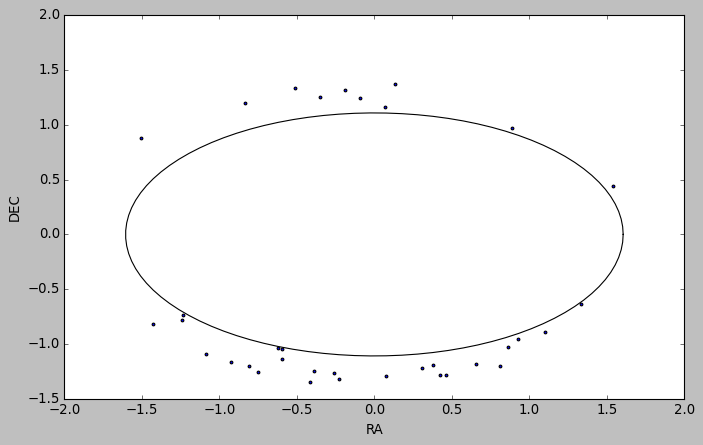

<Figure size 800x480 with 0 Axes>

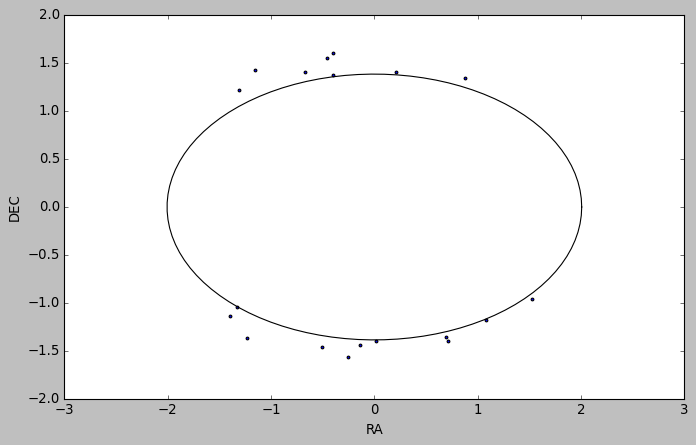

In [132]:
spectot,specxvec,specyvec,specrad,specprobave,specdistot,specden,specerr,dis2=ellipse_bin_pro_noprob(testiron['TARGET_RA_1'][iqk][targiqk],testiron['TARGET_DEC_1'][iqk][targiqk],theta0=89*0.0174533,r0=10/60,e=0.31,number=10,ra0=ra0,dec0=dec0)



<Figure size 800x480 with 0 Axes>

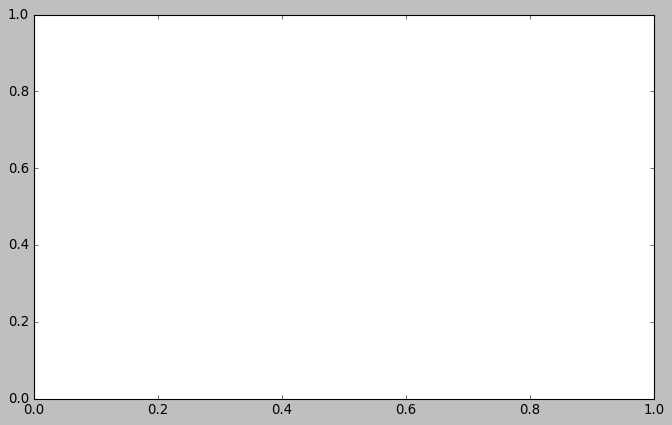

<Figure size 800x480 with 0 Axes>

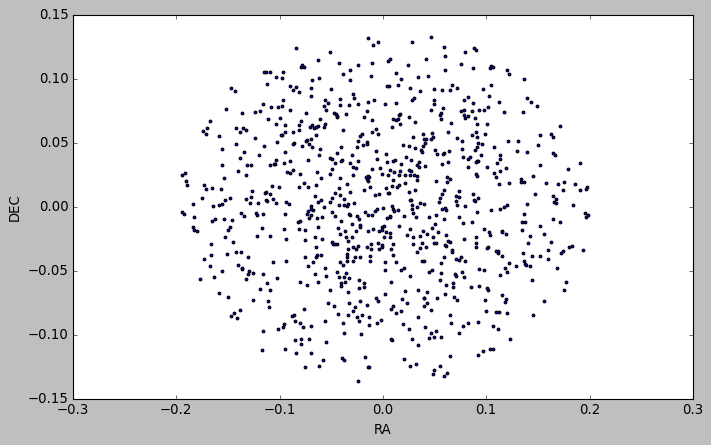

<Figure size 800x480 with 0 Axes>

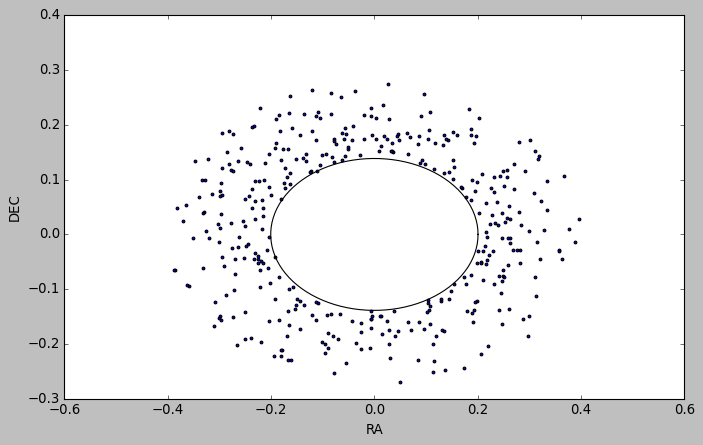

<Figure size 800x480 with 0 Axes>

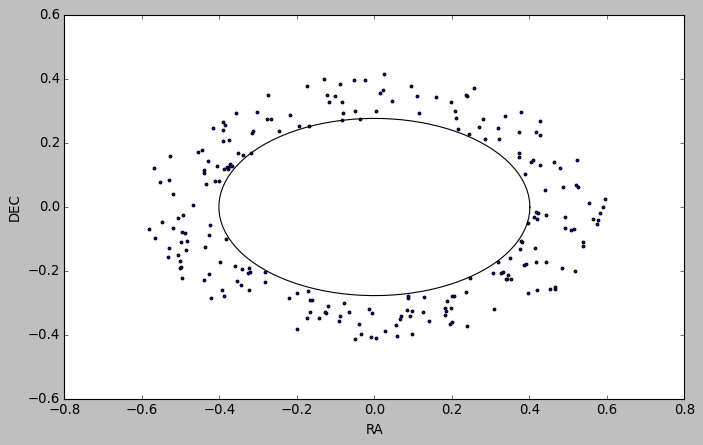

<Figure size 800x480 with 0 Axes>

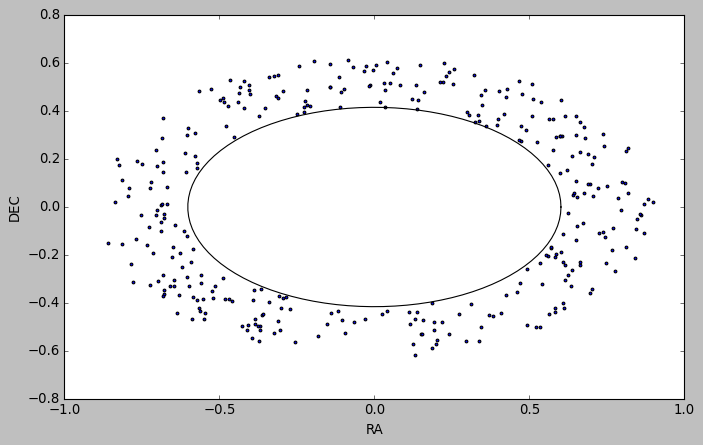

<Figure size 800x480 with 0 Axes>

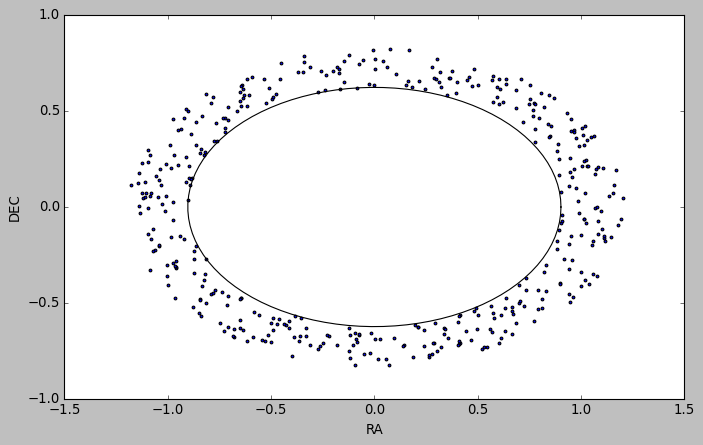

<Figure size 800x480 with 0 Axes>

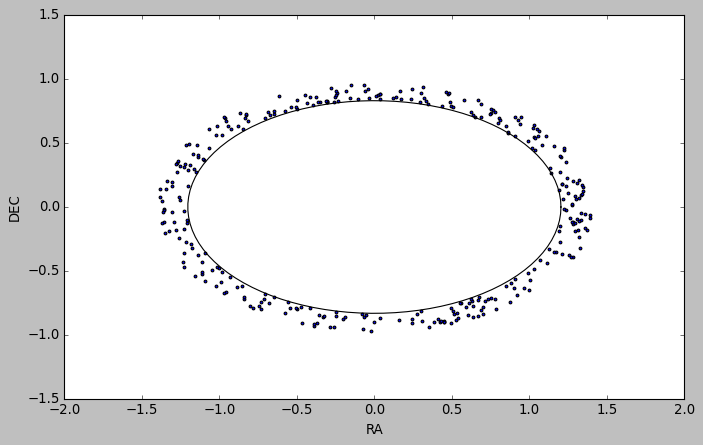

<Figure size 800x480 with 0 Axes>

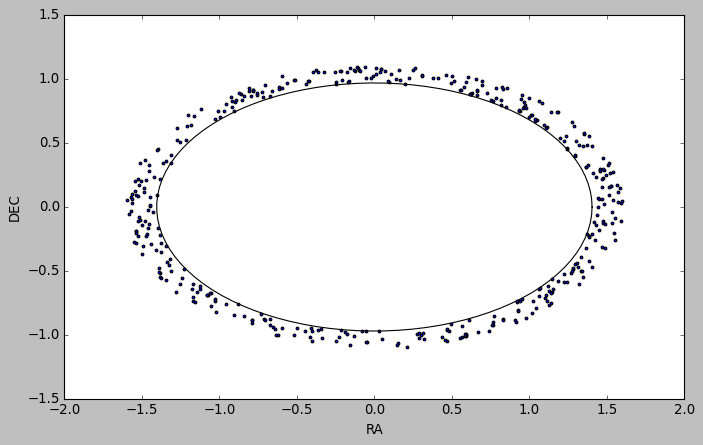

<Figure size 800x480 with 0 Axes>

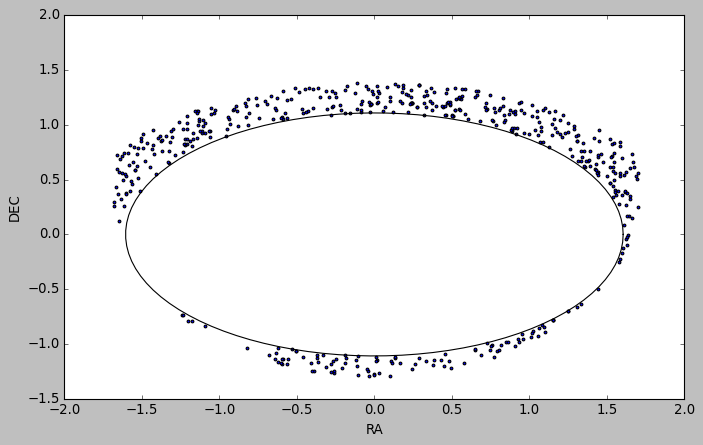

<Figure size 800x480 with 0 Axes>

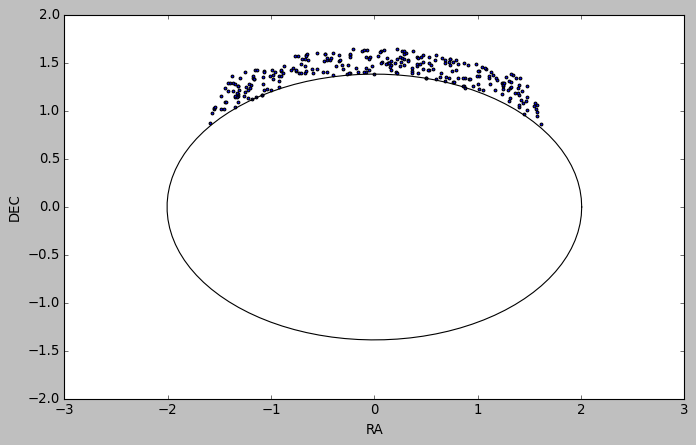

In [133]:
targtot,targxvec,targyvec,targrad,targprobave,targdistot,targden,tarerr,dis2=ellipse_bin_pro_noprob(targra[itargd],targdec[itargd],theta0=89*0.0174533,r0=10/60,e=0.31,number=10,ra0=ra0,dec0=dec0)
 


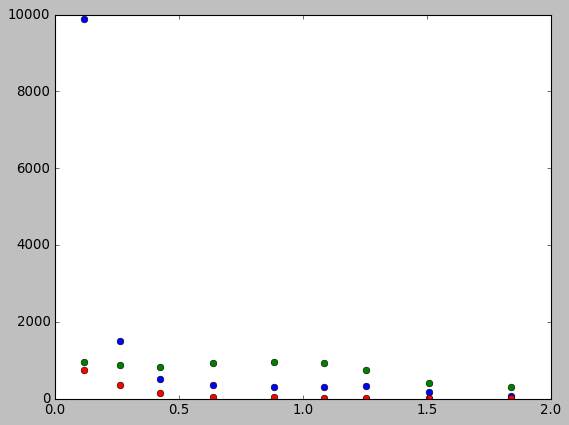

In [134]:
plt.plot(targrad,targden,'bo')
plt.plot(specrad,specden,'ro')
plt.plot(allspecrad,allspecden,'go')


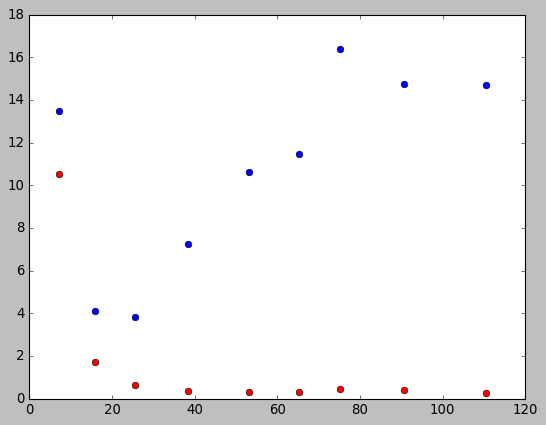

In [135]:
plt.plot(np.asarray(targrad)*60,np.asarray(targden)/np.asarray(specden),'bo')
plt.plot(np.asarray(targrad)*60,np.asarray(targden)/np.asarray(allspecden),'ro')


In [136]:
tratio=np.asarray(targden)/np.asarray(specden)
print(tratio)
alltratio=np.asarray(targden)/np.asarray(allspecden)
print(alltratio)

[13.46875     4.12631579  3.83050847  7.26086957 10.625      11.44827586
 16.38461538 14.74285714 14.68421053]
[10.51219512  1.73451327  0.63483146  0.37028825  0.3279321   0.31499051
  0.43469388  0.39389313  0.2522604 ]


In [137]:
r

[0.11785113020365047,
 0.26352313834736496,
 0.42491829279939874,
 0.6373774391990981,
 0.88]

ValueError: x and y must have same first dimension, but have shapes (5,) and (9,)

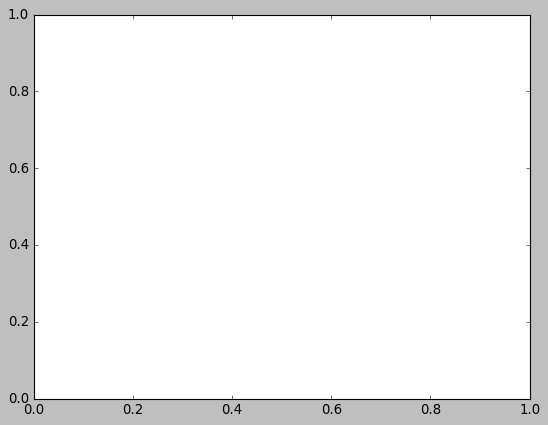

In [138]:
plt.plot(np.asarray(r)*60,dend*tratio,'bo')
plt.plot(np.asarray(r)*60,dend,'ro')
plt.plot(np.sqrt(R2)*60,den*250,'.')
plt.yscale('log')
plt.yscale('log')
plt.xscale('log')

# Adding the colorcut 

In [139]:
colorcut1 = cmd_selection(testiron[irad], dm, g_r, iso_r, cwmin=0.6, dobhb=True)


/tmp/ipykernel_401224/1227359104.py:11: RuntimeWarning: invalid value encountered in subtract
  magrange = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax) & (t['gmag0'] - t['rmag0'] > grmin)
/tmp/ipykernel_401224/1227359104.py:12: RuntimeWarning: invalid value encountered in subtract
  gr = t['gmag0'] - t['rmag0']
/tmp/ipykernel_401224/1227359104.py:33: RuntimeWarning: invalid value encountered in subtract
  magrange_bhb = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax_bhb) & (t['gmag0'] - t['rmag0'] > grmin_bhb)
/tmp/ipykernel_401224/1227359104.py:36: RuntimeWarning: invalid value encountered in subtract
  rr_bhb = np.interp(t['gmag0'] - t['rmag0'], des_m92_hb_g - des_m92_hb_r, des_m92_hb_r + dm,left=np.nan, right=np.nan)
/tmp/ipykernel_401224/1227359104.py:37: RuntimeWarning: invalid value encountered in subtract
  del_color_cmd_bhb = t['gmag0'] - t['rmag0'] - gr_bhb


In [140]:
colorcut2 = cmd_selection(testiron[iqk][targiqk], dm, g_r, iso_r, cwmin=0.6, dobhb=True)


/tmp/ipykernel_401224/1227359104.py:11: RuntimeWarning: invalid value encountered in subtract
  magrange = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax) & (t['gmag0'] - t['rmag0'] > grmin)
/tmp/ipykernel_401224/1227359104.py:12: RuntimeWarning: invalid value encountered in subtract
  gr = t['gmag0'] - t['rmag0']
/tmp/ipykernel_401224/1227359104.py:33: RuntimeWarning: invalid value encountered in subtract
  magrange_bhb = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax_bhb) & (t['gmag0'] - t['rmag0'] > grmin_bhb)
/tmp/ipykernel_401224/1227359104.py:36: RuntimeWarning: invalid value encountered in subtract
  rr_bhb = np.interp(t['gmag0'] - t['rmag0'], des_m92_hb_g - des_m92_hb_r, des_m92_hb_r + dm,left=np.nan, right=np.nan)
/tmp/ipykernel_401224/1227359104.py:37: RuntimeWarning: invalid value encountered in subtract
  del_color_cmd_bhb = t['gmag0'] - t['rmag0'] - gr_bhb


/tmp/ipykernel_401224/1106903665.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,6))


<Figure size 800x480 with 0 Axes>

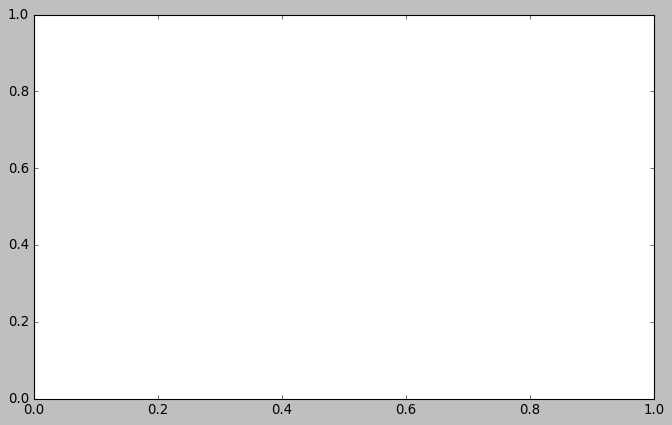

<Figure size 800x480 with 0 Axes>

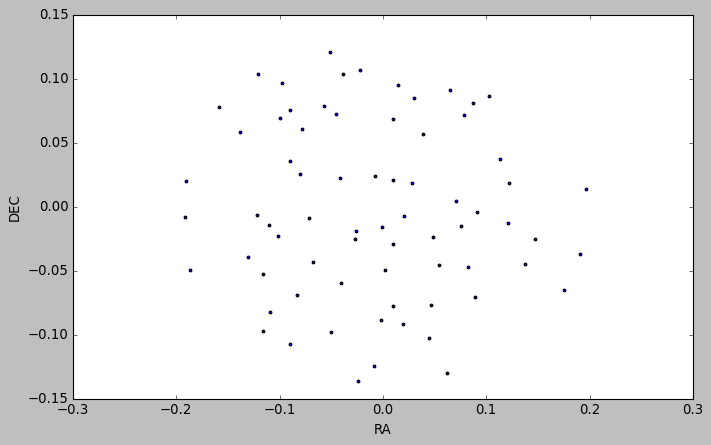

<Figure size 800x480 with 0 Axes>

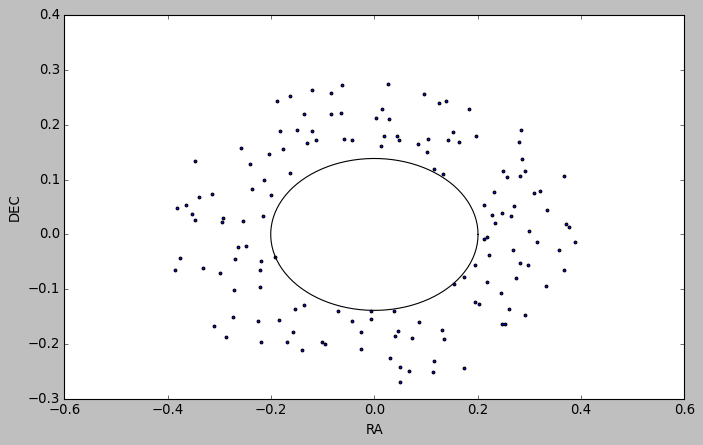

<Figure size 800x480 with 0 Axes>

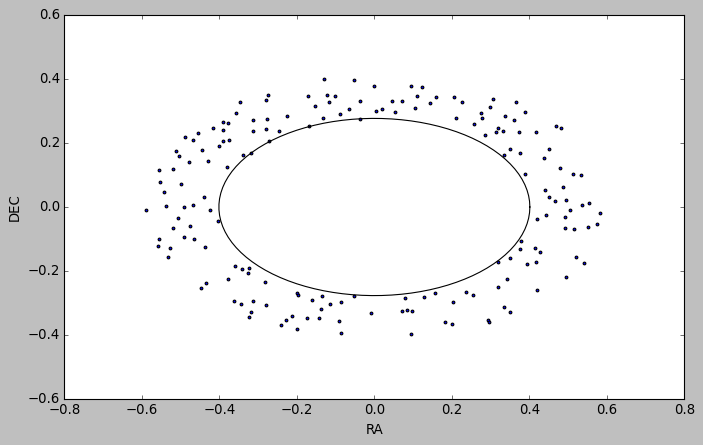

<Figure size 800x480 with 0 Axes>

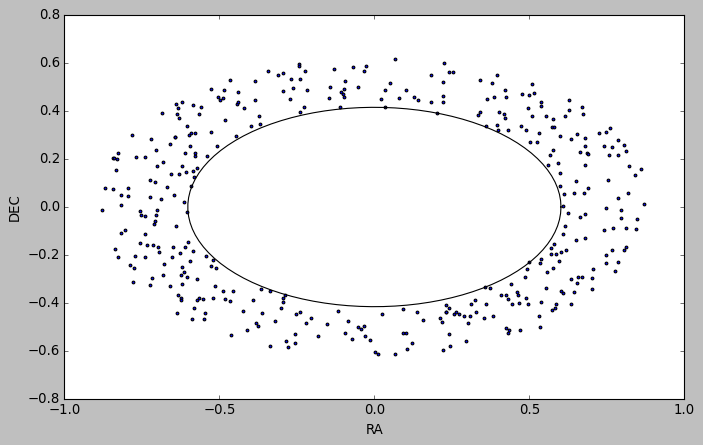

<Figure size 800x480 with 0 Axes>

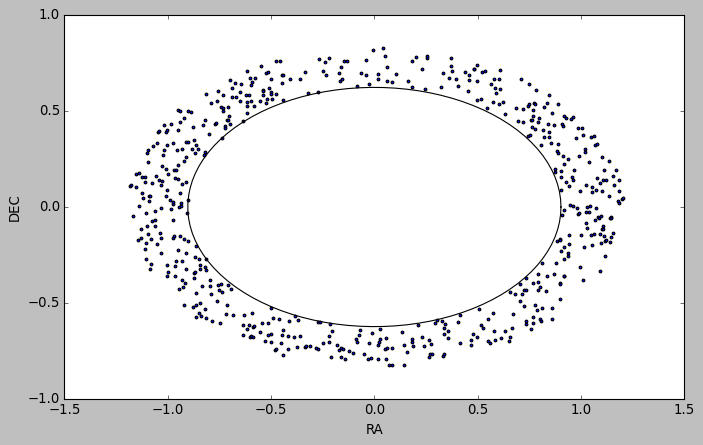

<Figure size 800x480 with 0 Axes>

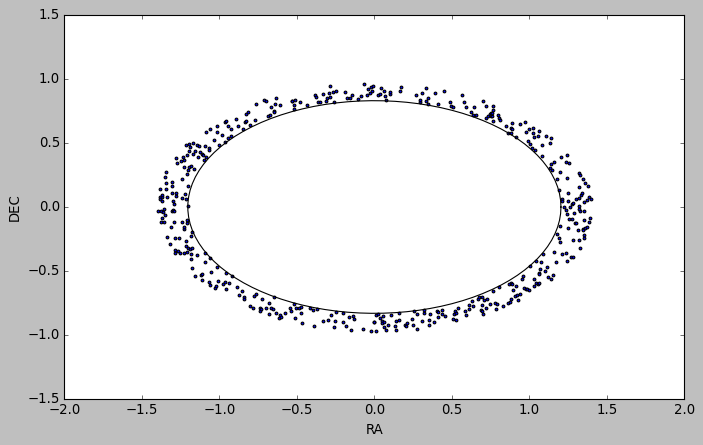

<Figure size 800x480 with 0 Axes>

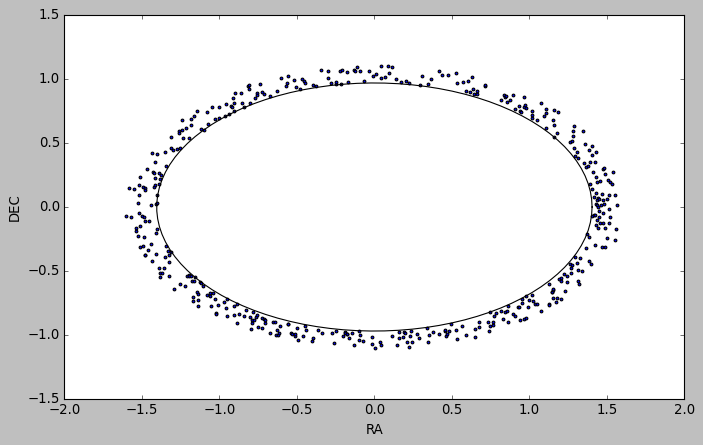

<Figure size 800x480 with 0 Axes>

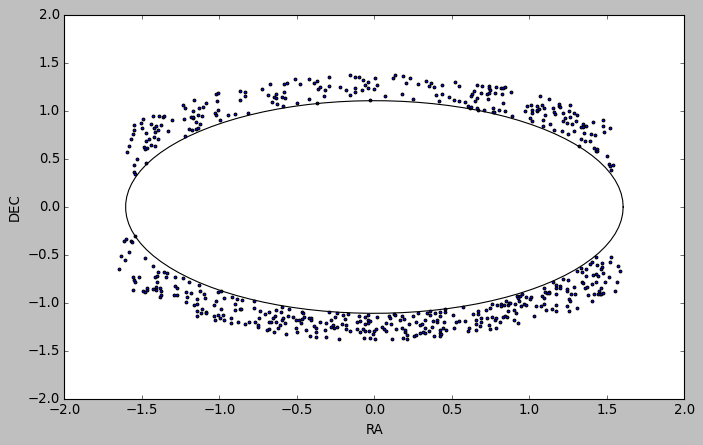

<Figure size 800x480 with 0 Axes>

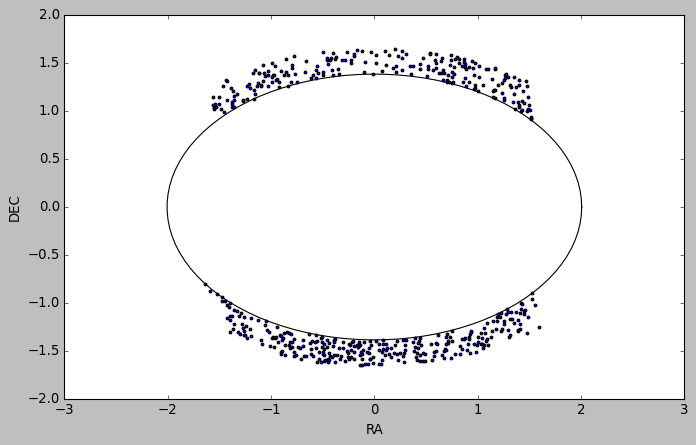

<Figure size 800x480 with 0 Axes>

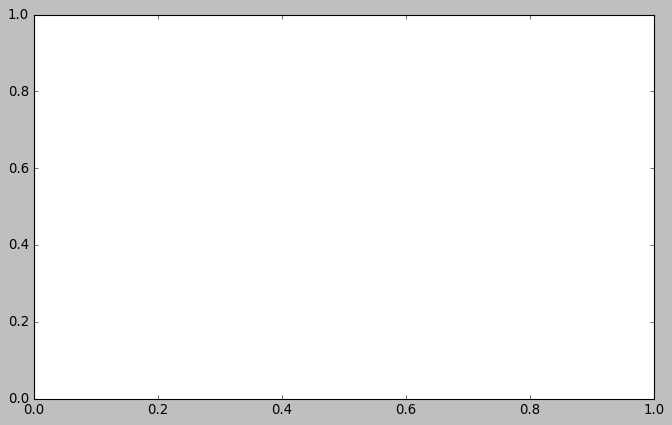

<Figure size 800x480 with 0 Axes>

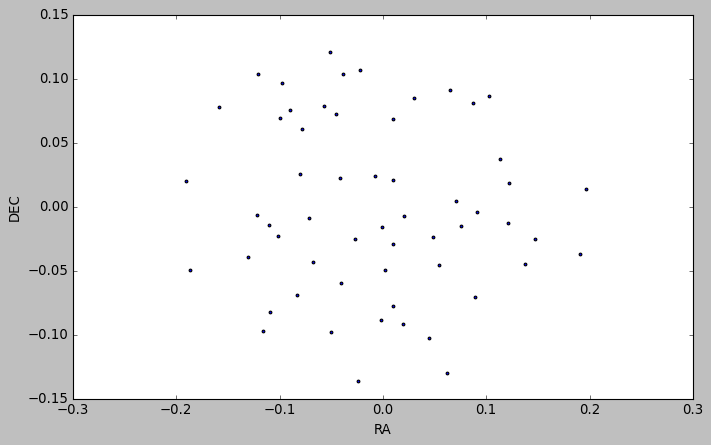

<Figure size 800x480 with 0 Axes>

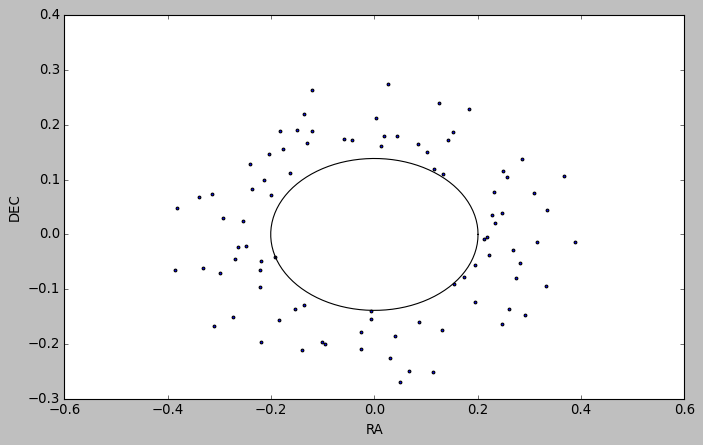

<Figure size 800x480 with 0 Axes>

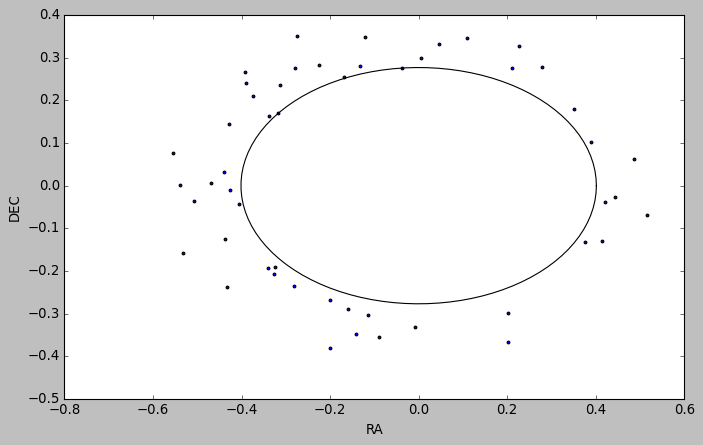

<Figure size 800x480 with 0 Axes>

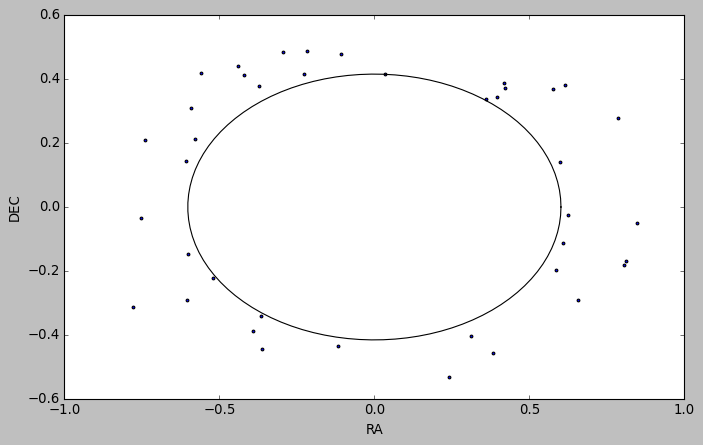

<Figure size 800x480 with 0 Axes>

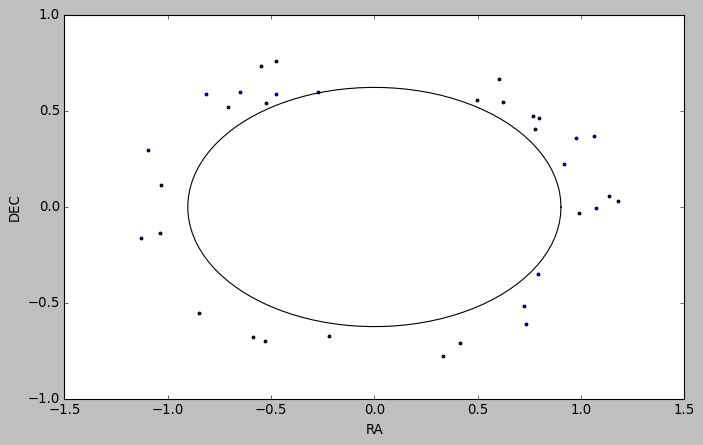

<Figure size 800x480 with 0 Axes>

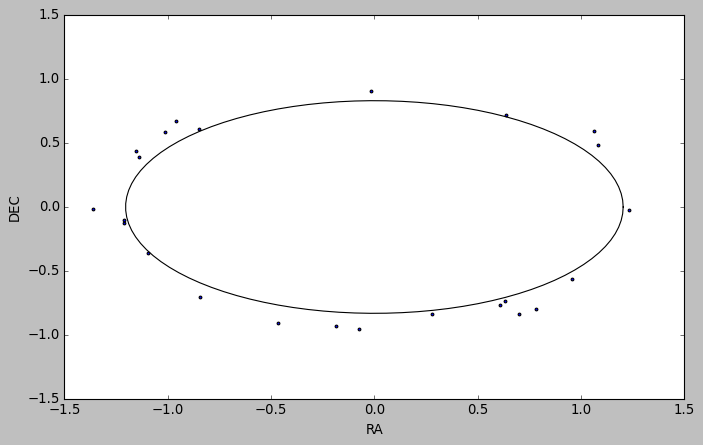

<Figure size 800x480 with 0 Axes>

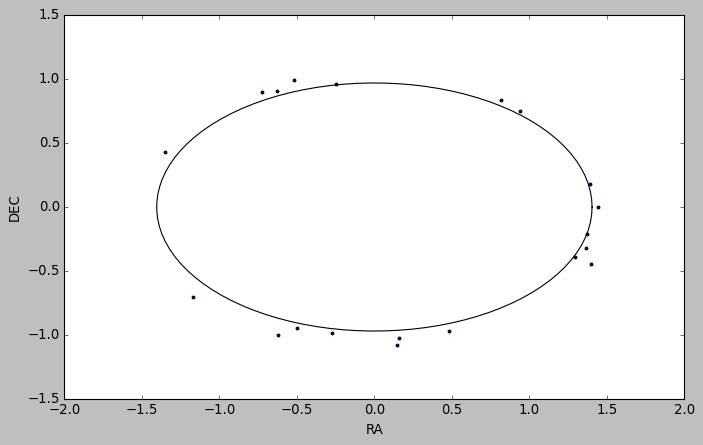

<Figure size 800x480 with 0 Axes>

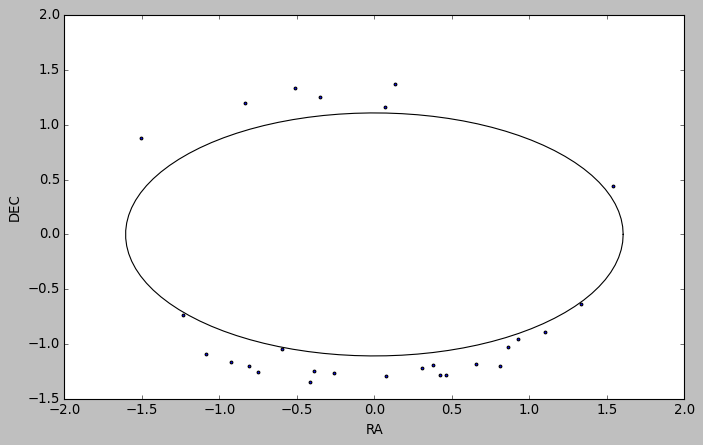

<Figure size 800x480 with 0 Axes>

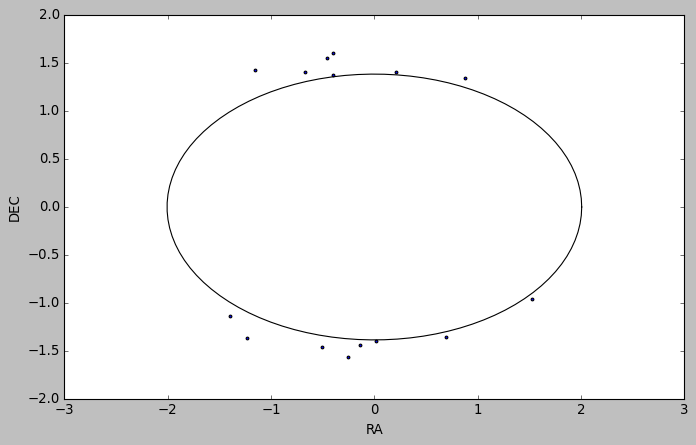

In [141]:

allspectot,allspecxvec,allspecyvec,allspecrad,allspecprobave,allspecdistot,allspecden,allerr,allr=ellipse_bin_pro_noprob(testiron['TARGET_RA_1'][irad][colorcut1],testiron['TARGET_DEC_1'][irad][colorcut1],theta0=89*0.0174533,r0=10/60,e=0.31,number=10,ra0=ra0,dec0=dec0)
                                                                                                      

spectot,specxvec,specyvec,specrad,specprobave,specdistot,specden,err,specr=ellipse_bin_pro_noprob(testiron['TARGET_RA_1'][iqk][targiqk][colorcut2],testiron['TARGET_DEC_1'][iqk][targiqk][colorcut2],theta0=89*0.0174533,r0=10/60,e=0.31,number=10,ra0=ra0,dec0=dec0)





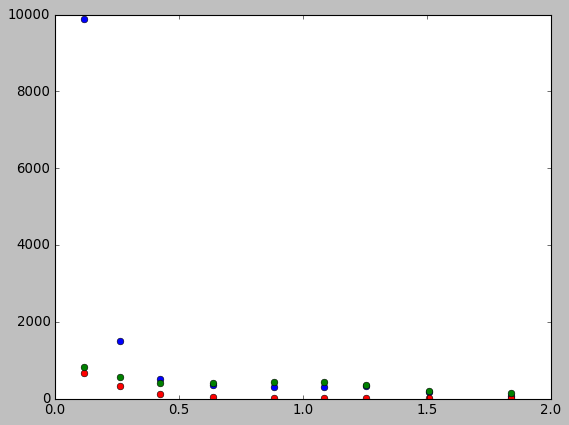

In [142]:
plt.plot(targrad,targden,'bo')
plt.plot(specrad,specden,'ro')
plt.plot(allspecrad,allspecden,'go')


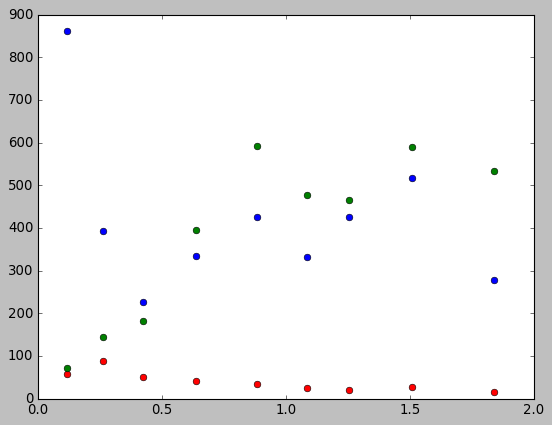

In [143]:
plt.plot(targrad,targtot,'bo')
plt.plot(specrad,spectot,'ro')
plt.plot(allspecrad,allspectot,'go')

In [144]:
spectot,allspectot

([57, 89, 51, 40, 34, 24, 20, 27, 15],
 [71, 144, 182, 395, 591, 477, 465, 589, 534])

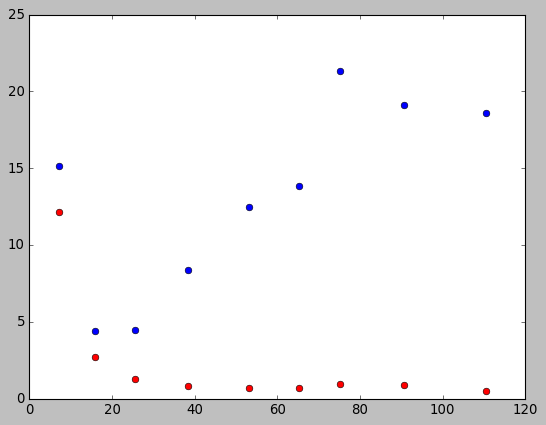

In [145]:
plt.plot(np.asarray(targrad)*60,np.asarray(targden)/np.asarray(specden),'bo')
plt.plot(np.asarray(targrad)*60,np.asarray(targden)/np.asarray(allspecden),'ro')


In [146]:
#plummer model comparison
theta0=89*0.0174533
#print (np.cos(90*0.0174533))
r0=10/60
e=0.31
a=r0/np.sqrt(1-e)
a=8.97/60
proba=0.
#x=np.cos(datacut['TARGET_DEC_1'][np.concatenate(testp)>proba])*np.sin(datacut['TARGET_RA_1'][np.concatenate(testp)>proba]-ra0)
#y=np.sin(datacut['TARGET_DEC_1'][np.concatenate(testp)>proba])*np.cos(dec0)-np.cos(datacut['TARGET_DEC_1'][np.concatenate(testp)>proba])*np.sin(dec0)*np.cos(datacut['TARGET_RA_1'][np.concatenate(testp)>proba]-ra0)
x=np.cos(datacut['TARGET_DEC_1'][np.concatenate(testp)>proba]*0.0174533)*np.sin((datacut['TARGET_RA_1'][np.concatenate(testp)>proba]-ra0)*0.0174533)
y=np.sin(datacut['TARGET_DEC_1'][np.concatenate(testp)>proba]*0.0174533)*np.cos(dec0*0.0174533)-np.cos(datacut['TARGET_DEC_1'][np.concatenate(testp)>proba]*0.0174533)*np.sin(dec0*0.0174533)*np.cos((datacut['TARGET_RA_1'][np.concatenate(testp)>proba]-ra0)*0.0174533)

x=x/0.0174533
y=y/0.0174533
Rx= x*np.cos(theta0)-y*np.sin(theta0)
Ry = x*np.sin(theta0)+y*np.cos(theta0)

Rx=Rx
Ry = Ry
R2 = Rx**2+Ry**2/(1-e)**2
Rx=np.arange(0,5,0.01)
Ry=np.arange(0,5,0.01)
R2 = Rx**2+Ry**2/(1-e)**2
den=1/(np.pi*a**2*(1-e))*(1+R2/a**2)**(-2)


In [147]:
#tratio=np.asarray(targden)/np.asarray(specden)
#print(tratio)
alltratio=np.asarray(targden)/np.asarray(allspecden)
print(alltratio)

[12.14084507  2.72222222  1.24175824  0.84556962  0.71912014  0.69601677
  0.91612903  0.87606112  0.52247191]


In [148]:
dis2[0]=a * b / np.sqrt(a**2 + b**2)

In [149]:
r

[0.11785113020365047,
 0.26352313834736496,
 0.42491829279939874,
 0.6373774391990981,
 0.88]

In [150]:
r

[0.11785113020365047,
 0.26352313834736496,
 0.42491829279939874,
 0.6373774391990981,
 0.88]

In [151]:
dis2

[0.10157853417818749,
 0.16666666666666666,
 0.3333333333333333,
 0.5,
 0.75,
 1.0,
 1.1666666666666665,
 1.3333333333333333,
 1.6666666666666665]

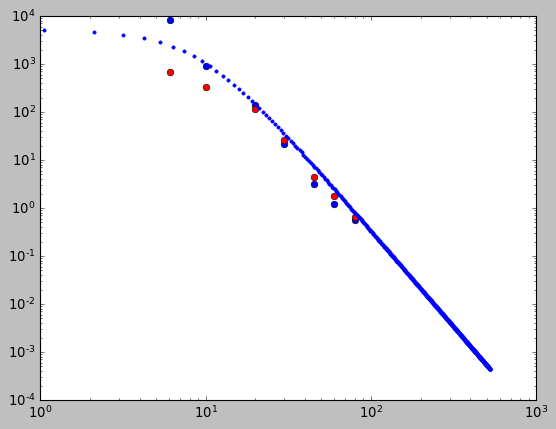

In [152]:
plt.plot(np.asarray(dis2)*60,dend*alltratio,'bo')
#plt.plot(np.asarray(dis2)*60,dend*tratio,'go')
plt.plot(np.asarray(dis2)*60,dend,'ro')
plt.plot(np.sqrt(R2)*60,den*250,'.')
plt.yscale('log')
plt.yscale('log')
plt.xscale('log')

ValueError: x and y must have same first dimension, but have shapes (5,) and (9,)

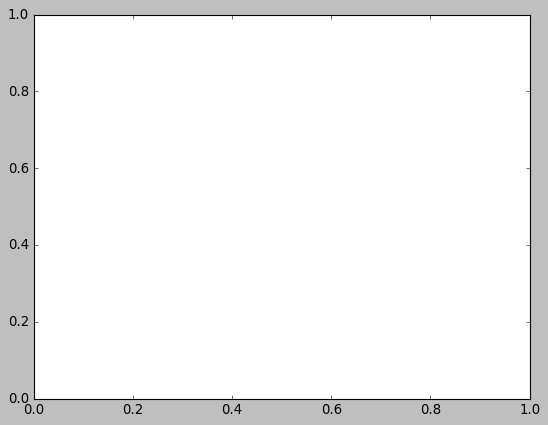

In [153]:
plt.plot(np.asarray(r)*60,dend*alltratio,'bo')
#plt.plot(np.asarray(r)*60,dend*tratio,'go')
plt.plot(np.asarray(r)*60,dend,'ro')
plt.plot(np.sqrt(R2)*60,den*560,'-')
plt.xlim(1,120)
plt.ylim(0.25,15000)
plt.xlabel('R Arcmin')

plt.yscale('log')
plt.yscale('log')
plt.xscale('log')

In [ ]:
allerr/np.asarray(allspecden)

tarerr/np.asarray(targden)

draerr/np.array(dend)

draerr

errtot = dend*alltratio*np.sqrt((draerr/np.array(dend))**2+(allerr/np.asarray(allspecden))**2+(tarerr/np.asarray(targden))**2)

In [ ]:
errtot

In [ ]:
draerr/np.array(dend)

In [154]:
dend

[687.5493542257428,
 328.495802541672,
 114.59155902616465,
 25.46479089470326,
 4.365392724806272,
 1.7629470619409953,
 0.0,
 0.6366197723675819,
 0.0]

In [155]:
draerr,errtot

NameError: name 'errtot' is not defined

ValueError: x and y must have same first dimension, but have shapes (5,) and (9,)

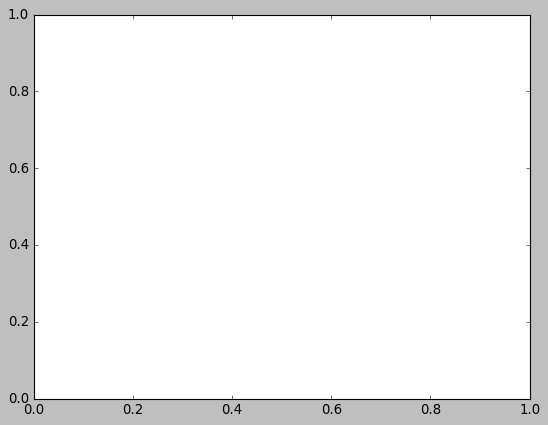

In [156]:
plt.plot(np.asarray(r)*60,dend*alltratio,'bo',label = 'Corrected Surface Density')
#plt.plot(np.asarray(r)*60,dend*tratio,'go')
plt.plot(np.asarray(r)*60,dend,'ro',label = 'Surface Density')
plt.plot(np.sqrt(R2)*60,den*560,'k-',label = 'Plummer Model')
plt.errorbar(np.array(r)*60,dend*alltratio, yerr=errtot, capsize=3, ls='none', color='black', 
            elinewidth=1)
plt.errorbar(np.array(r)*60,dend, yerr=draerr, capsize=3, ls='none', color='black', 
            elinewidth=1)
plt.axvline(x=43,linestyle='--',label='Tidal Radius')
plt.xlim(1,120)
plt.ylim(0.5,15000)
plt.xlabel('R arcmin')
plt.ylabel(r'Star Density [arcmin$^{-2}$]')
plt.yscale('log')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=3)
plt.savefig('plummer_gsr.pdf')

In [151]:
R2,den

(array([0.00000000e+00, 3.10039908e-04, 1.24015963e-03, 2.79035917e-03,
        4.96063852e-03, 7.75099769e-03, 1.11614367e-02, 1.51919555e-02,
        1.98425541e-02, 2.51132325e-02, 3.10039908e-02, 3.75148288e-02,
        4.46457467e-02, 5.23967444e-02, 6.07678219e-02, 6.97589792e-02,
        7.93702163e-02, 8.96015333e-02, 1.00452930e-01, 1.11924407e-01,
        1.24015963e-01, 1.36727599e-01, 1.50059315e-01, 1.64011111e-01,
        1.78582987e-01, 1.93774942e-01, 2.09586978e-01, 2.26019093e-01,
        2.43071288e-01, 2.60743562e-01, 2.79035917e-01, 2.97948351e-01,
        3.17480865e-01, 3.37633459e-01, 3.58406133e-01, 3.79798887e-01,
        4.01811720e-01, 4.24444633e-01, 4.47697627e-01, 4.71570699e-01,
        4.96063852e-01, 5.21177085e-01, 5.46910397e-01, 5.73263789e-01,
        6.00237261e-01, 6.27830813e-01, 6.56044444e-01, 6.84878156e-01,
        7.14331947e-01, 7.44405818e-01, 7.75099769e-01, 8.06413800e-01,
        8.38347910e-01, 8.70902100e-01, 9.04076371e-01, 9.378707

In [152]:
np.array(den)[np.absolute(np.array(np.sqrt(R2))-0.5)<0.005]
np.array(dend)/np.array(dend)[np.absolute(np.array(r)-0.5)<0.01]
np.array(r)*60


ValueError: operands could not be broadcast together with shapes (9,) (0,) 

In [ ]:
1/(np.pi*a**2*(1-e))*(1+0**2/a**2)**(-2)

In [ ]:
np.min(np.sqrt(R2)*60)

In [ ]:
plt.plot(np.sqrt(R2)*60,den,'.')

plt.yscale('log')
plt.xscale('log')

In [ ]:
np.sort(np.sqrt(R2))

In [ ]:
np.array(den)[np.absolute(np.array(np.sqrt(R2))-0.5)<0.006]

In [ ]:
plt.plot(np.sort(np.sqrt(R2)),np.array(np.array(den)/np.array(den)[np.absolute(np.array(np.sqrt(R2))-0.48)<0.002])[np.argsort(np.sqrt(R2))],'-')
plt.plot(np.array(r),np.array(dend)/np.array(dend)[np.absolute(np.array(r)-0.48)<0.04],'.')
plt.errorbar(np.array(r),np.array(dend)/np.array(dend)[np.absolute(np.array(r)-0.48)<0.04], yerr=err/np.array(dend)[np.absolute(np.array(r)-0.48)<0.04], capsize=5, ls='none', color='black', 
            elinewidth=2)

plt.yscale('log')

plt.xscale('log')
plt.ylim(0,150)
#plt.xlim(1,500)
plt.xlabel('R arcmin')
plt.ylabel(r'Number Density [stars arcmin$^{-2}$]')
plt.savefig('density.pdf')

In [ ]:
simp3

In [ ]:
den

In [ ]:
ratio1=np.array(dend)/simp1
ratio2=np.array(dend2)/simp2
ratio3=den/simp3

In [ ]:
lim = 0.0

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.sqrt(R2),den/den[np.absolute(np.sqrt(R2)-0.3)<0.01],'.',label = 'Plummer Model')
#plt.plot(np.array(r2),np.array(dend2)/dend2[np.absolute(np.array(r2)-0.3)<0.03],'.',label = 'Elliptical bins')
plt.plot(np.array(r),np.array(dend)/np.array(dend)[np.absolute(np.array(r)-0.3)<0.04],'.',label = 'Elliptical bins Iron')
plt.xlabel('R (degree)')
plt.legend()

In [ ]:
datacut["LOGG"][np.isin(datacut['VRAD'],testiron['VRAD'])]

In [ ]:

plt.figure(figsize=(10,6))
proba=0.2
#plt.scatter(df['ra'][df['mem_fixed_complete_ep']>0.75],df['dec'][df['mem_fixed_complete_ep']>0.75],s=1)
plt.scatter(np.array(distot)[np.concatenate(testp)>proba],testiron["LOGG"][np.isin(testiron['VRAD'],datacut['VRAD'])][np.concatenate(testp)>proba],s=10,c=np.concatenate(testp)[np.concatenate(testp)>proba])
cbar=plt.colorbar()
cbar.set_label('Iron Probability')



#plt.ylim(21, 16)
#plt.xlim(-0.3,1.5)
plt.ylabel('LOGG')
plt.xlabel('Distance')


In [ ]:

plt.figure(figsize=(10,6))
proba=0.2
#plt.scatter(df['ra'][df['mem_fixed_complete_ep']>0.75],df['dec'][df['mem_fixed_complete_ep']>0.75],s=1)
plt.scatter(np.array(distot)[np.concatenate(testp)>proba],datacut["VRAD"][np.concatenate(testp)>proba],s=10,c=np.concatenate(testp)[np.concatenate(testp)>proba])
cbar=plt.colorbar()
cbar.set_label('Iron Probability')



#plt.ylim(21, 16)
#plt.xlim(-0.3,1.5)
plt.ylabel('VRAD')
plt.xlabel('Distance')


In [ ]:
#logg versus rv
plt.figure(figsize=(10,6))
proba=0.2
#plt.scatter(df['ra'][df['mem_fixed_complete_ep']>0.75],df['dec'][df['mem_fixed_complete_ep']>0.75],s=1)
plt.scatter(datacut["VRAD"][np.concatenate(testp)>proba],testiron["LOGG"][np.isin(testiron['VRAD'],datacut['VRAD'])][np.concatenate(testp)>proba],s=10,c=np.concatenate(testp)[np.concatenate(testp)>proba])
cbar=plt.colorbar()
cbar.set_label('Iron Probability')



#plt.ylim(21, 16)
#plt.xlim(-0.3,1.5)
plt.ylabel('VRAD')
plt.xlabel('Distance')

In [ ]:
#Vrad versus FeH plot with Iron-Pace&Li 2022 Probability

plt.figure(figsize=(10,6))
proba=0.2
#plt.scatter(df['ra'][df['mem_fixed_complete_ep']>0.75],df['dec'][df['mem_fixed_complete_ep']>0.75],s=1)
plt.scatter(datacut["FEH"][np.concatenate(testp)>proba],testiron["LOGG"][np.isin(testiron['VRAD'],datacut['VRAD'])][np.concatenate(testp)>proba],s=10,c=np.concatenate(testp)[np.concatenate(testp)>proba])
cbar=plt.colorbar()
cbar.set_label('Iron Probability')



#plt.ylim(21, 16)
#plt.xlim(-0.3,1.5)
plt.xlabel('FEH')
plt.ylabel('LOGG')


In [ ]:
#Vrad versus FeH plot with Iron-Pace&Li 2022 Probability

plt.figure(figsize=(10,6))

#plt.scatter(df['ra'][df['mem_fixed_complete_ep']>0.75],df['dec'][df['mem_fixed_complete_ep']>0.75],s=1)
plt.scatter(datacut["VRAD"][sep_constraint],datacut['FEH'][sep_constraint],s=10,c=sub,cmap='bwr')
cbar=plt.colorbar()
cbar.set_label('Iron - Pace&Li Probability')



#plt.ylim(21, 16)
#plt.xlim(-0.3,1.5)
plt.xlabel('VRAD')
plt.ylabel('FeH')


In [ ]:
#pmra,pmdec with probability
plt.figure(figsize=(10,6))

#plt.scatter(df['pmra'][df['mem_fixed_complete_ep']>0.75],df['pmdec'][df['mem_fixed_complete_ep']>0.75],s=1)
plt.scatter(datacut["PMRA_3"][sep_constraint],datacut["PMDEC_3"][sep_constraint],s=10,c=np.concatenate(testp)[sep_constraint],cmap='bwr')
cbar= plt.colorbar()
cbar.set_label('Iron - Pace&Li Probability')

plt.ylim(-5, 5)

plt.xlim(-5,5)
plt.ylabel('PMDEC')
plt.xlabel('PMRA')

In [ ]:
#Vrad versus FeH plot with Iron-Pace&Li 2022 Probability

plt.figure(figsize=(10,6))
proba=0.2
#plt.scatter(df['ra'][df['mem_fixed_complete_ep']>0.75],df['dec'][df['mem_fixed_complete_ep']>0.75],s=1)
plt.scatter(datacut["PMRA_3"][np.concatenate(testp)>proba],datacut['PMDEC_3'][np.concatenate(testp)>proba],s=10,c=np.concatenate(testp)[np.concatenate(testp)>proba])
cbar=plt.colorbar()
cbar.set_label('Iron Probability')



#plt.ylim(21, 16)
#plt.xlim(-0.3,1.5)
plt.xlabel('PMRA')
plt.ylabel('PMDEC')
plt.ylim(-5, 5)

plt.xlim(-5,5)

In [ ]:
#pmra,pmdec with probability difference
plt.figure(figsize=(10,6))

#plt.scatter(df['pmra'][df['mem_fixed_complete_ep']>0.75],df['pmdec'][df['mem_fixed_complete_ep']>0.75],s=1)
plt.scatter(datacut["PMRA_3"][sep_constraint],datacut["PMDEC_3"][sep_constraint],s=10,c=sub,cmap='bwr')
cbar= plt.colorbar()
cbar.set_label('Iron - Pace&Li Probability')

plt.ylim(-5, 5)

plt.xlim(-5,5)
plt.ylabel('PMDEC')
plt.xlabel('PMRA')